# Predicting Housing Values with Time Series

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statistics
import warnings
warnings.filterwarnings('ignore')
import itertools
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_absolute_error
plt.style.use('ggplot')

## Goals for Project
Create an interface that helps the typical person decide where they want to buy a house in the United States. Take Zillow housing data to create many time series for different areas. Cross reference areas with census data to look for correlation. Use this information to create a user friendly app that allows someone to either browse with a map or use filters to see which place would best fit their interests. Eventually having the predictions change in real time.

## Overview
For this portion of the project I focused on a predictive time series for a small number of counties. My MVP project would be all 3000 or so counties in the US but I decided to start with a group of 27 to see if my idea would work. I sourced my housing data from Zillow and used it to get a time series from 2012 to 2021 for the typical home value for 27 different counties. I used what I found to create forecasts to see what the tpyical home value could be within the next 4 years.

## Data
Housing data sourced from Zillow that dates from January 2000, to September 2021. The main resource that I am using to predict furture housing values is the Zillow Home Index Value. The main aspect of the Zillow Home Index Value (ZHVI) is the Zestimate. The Zestimate of a house is the estimated value of that individual house. Zestimates for on-market houses across the entire US have a median error of 2%. This means that for the on-market homes, half of the Zestimates are within 2% of the selling price, while the other half is not. Off-market Zestimates have a median error of 6.9%. One of the core functions of the ZHVI is calculating the weighted average of each home’s appreciation in the property universe. The homes Zestimate or zi,t-1 and ,zi,t , at time t-1 and t respectively, is used to calculate the individual home appreciation (ai,t). 
![Appreciation](./../imgs/z_appreciation.png)
Each individual home appreciation is then multiplied by a weight (wi,t-1). This weight is found by dividing a homes zestimate by the sum of all Zestimates in the region.
![Weight](./../imgs/z_weight.png)
The total market appreciation, At, is the sum of the weighted appreciation of each home.
The total market appreciation is then used to find the previous typical home value in every period by dividing the mean Zestimate of the property universe at time t (It) by 1 plus the total market appreciation at time t.
![Total Appreciation](./../imgs/z_total_appreciation.png)
There has been articles talking about the quality of the Zestimate, due to Zillow losing approx. 500 million from their house flipping business. Although critics say Zillow depended too much on its Zestimate, other experts are saying it has more to do with holding on to too many houses for too long and the expenses that come along with that.

In [2]:
wide_ts = pd.read_csv('../dataraw/Housing_data.csv')
ts = pd.melt(wide_ts, id_vars=['RegionID', 'RegionType', 'RegionName', 
                          'SizeRank', 'StateName', 'State', 'Metro', 'CountyName'], var_name='time')
ts['StateAndCounty'] = ts['StateName'] + ' ' + ts['CountyName']
ts['time'] = pd.to_datetime(ts['time'])
ts.dropna(inplace=True)

## Methods
The data I sourced was seperated by RegionID and produced 26000 different regions. I decided to immediately change my focus to counties as there are only 3000. I started by taking the 27 values for the counties. I cut data that predates 2012 due to the housing bubble that went from 2005 to 2012

In [3]:
chosen_df = ts[ts['time'] == ts['time'].max()]
chosen_df
this_df = chosen_df.assign(log_val=np.log(chosen_df.value)).query('log_val >= 12.66925 and log_val <= 12.67075')
chosen_countynames = this_df.StateAndCounty.unique()
ts_bools = ts.StateAndCounty.isin(chosen_countynames)
ts = ts[ts_bools]

In [4]:
ts_list = []
for county in chosen_countynames:
    temp_ts = ts[ts['StateAndCounty'] == county]
    temp_ts = temp_ts.groupby('time').aggregate({'value' :'mean'})
    column_name = county + ' value'
    temp_ts.rename(columns={'value' : column_name}, inplace=True)
#     temp_ts.set_index('time', inplace=True)
    ts_list.append(temp_ts)
full_ts = pd.concat(ts_list, axis=1)

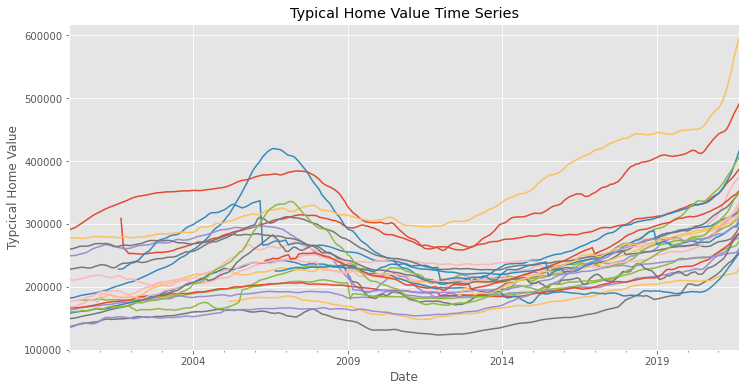

In [5]:
full_ts.plot(figsize=(12,6), legend=False)
plt.ylabel('Typcical Home Value')
plt.xlabel('Date')
plt.title('Typical Home Value Time Series')
plt.show()

In [6]:
final_ts = full_ts['2012':]
final_ts.fillna(inplace=True, method='backfill')

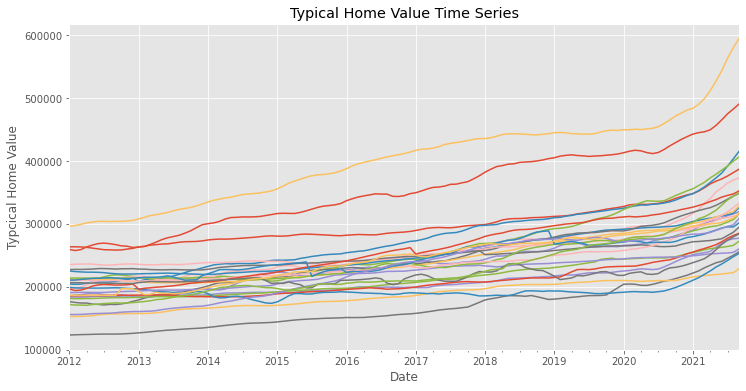

In [7]:
final_ts.plot(figsize=(12,6), legend=False)
plt.ylabel('Typcical Home Value')
plt.xlabel('Date')
plt.title('Typical Home Value Time Series')
plt.show()

I took steps to make the data stationary. I logged the data to normalize it. 

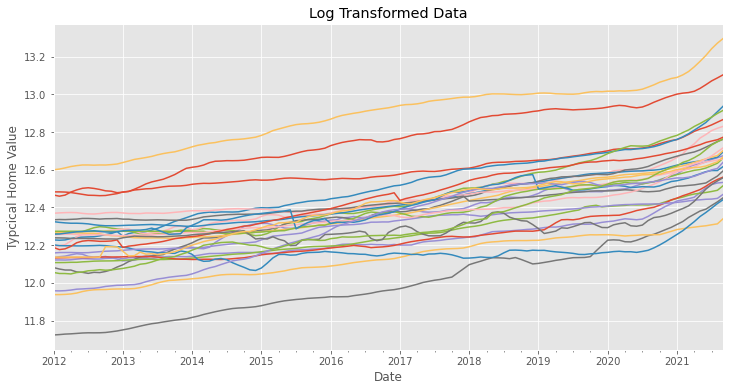

In [8]:
ts_log = np.log(final_ts)
roll_mean = ts_log.rolling(window=7, center=False).mean()
ts_log.plot(figsize=(12,6), legend=False)
plt.title('Log Transformed Data')
plt.xlabel('Date')
plt.ylabel('Typcical Home Value')
plt.show()

I subtracted the exponential rolling mean and differenced the data in order to detrend it.

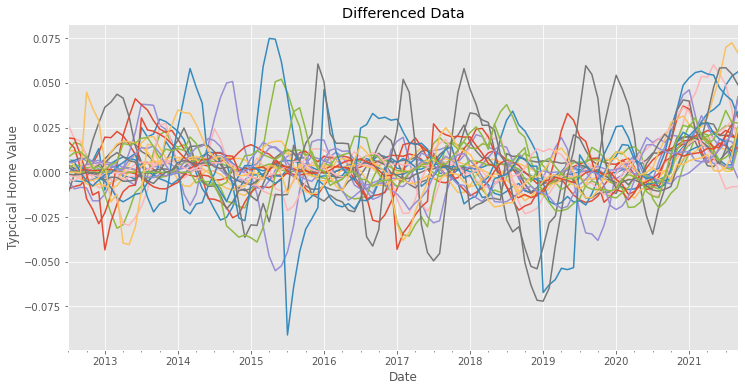

In [9]:
exp_roll_mean = ts_log.ewm(halflife=4).mean()
data_minus_exp_roll_mean = ts_log - exp_roll_mean
data_minus_exp_roll_mean.dropna(inplace=True)
data_diff = data_minus_exp_roll_mean.diff(periods=6)
data_diff.dropna(inplace=True)
data_diff.plot(figsize=(12,6), legend=False)
plt.title('Differenced Data')
plt.xlabel('Date')
plt.ylabel('Typcical Home Value')
plt.show()

I checked the autocorrelation and the partial autocorrelation. The autocorrelation looks great, starts with a high correlation but immediately drops and then flucuates around 0. For the partial autocorrelation, while most performed great, some of the time series didnt preform as well as others with spikes of correlation popping up towards the end as well as beginning.

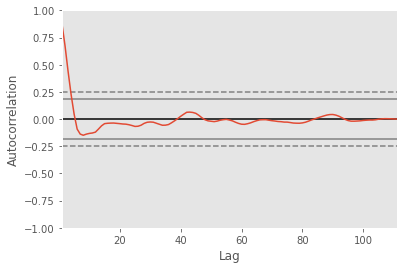

In [10]:
pd.plotting.autocorrelation_plot(data_diff);

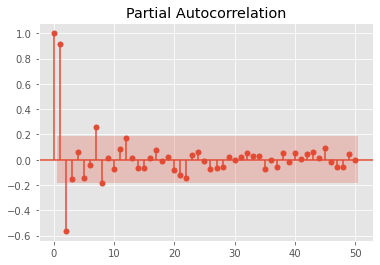

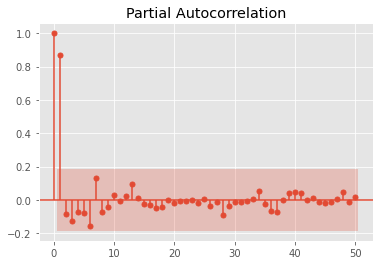

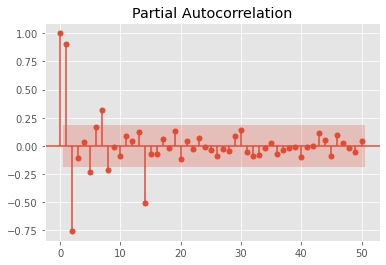

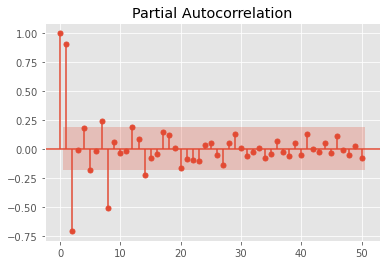

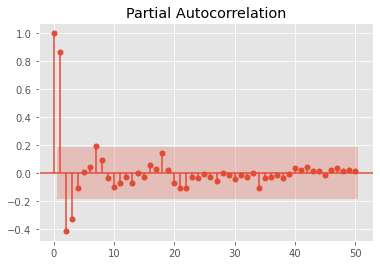

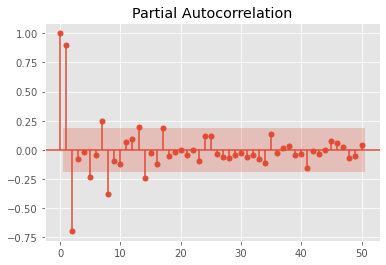

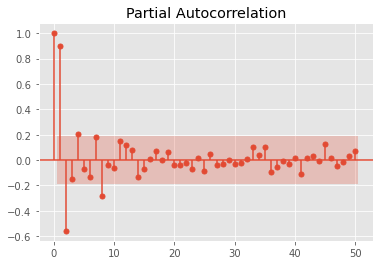

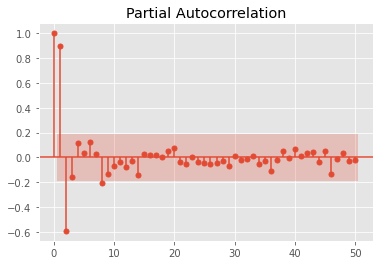

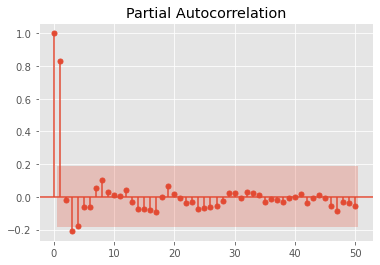

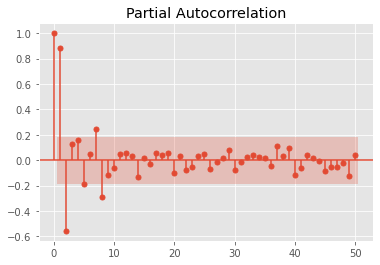

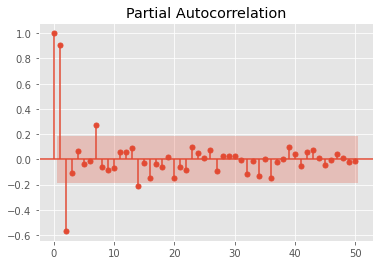

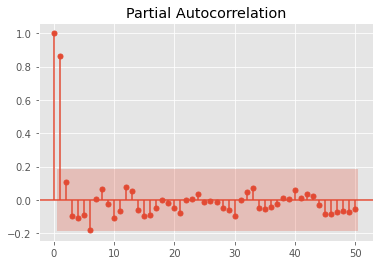

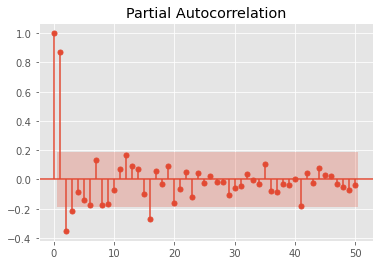

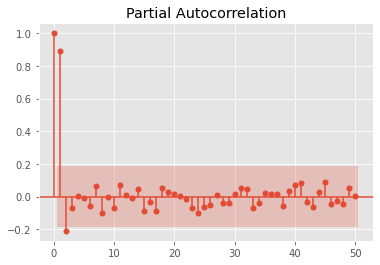

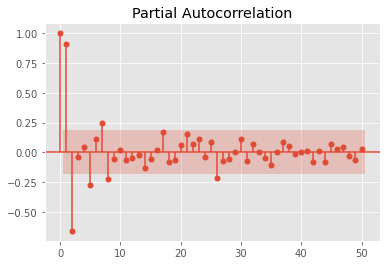

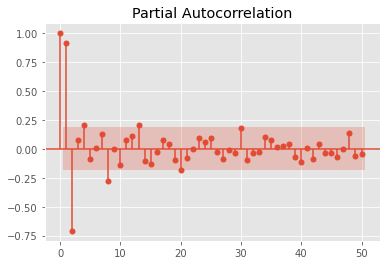

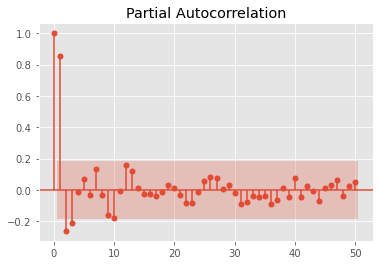

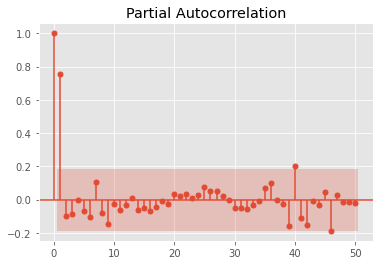

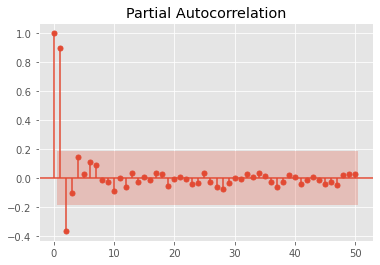

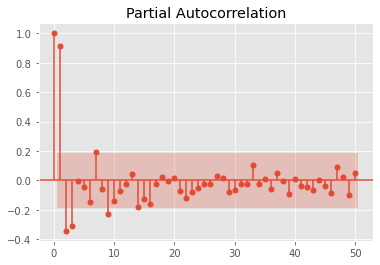

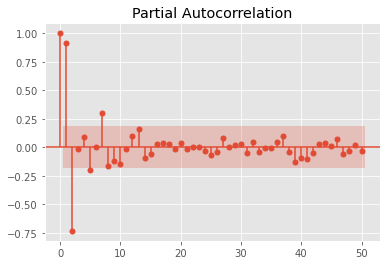

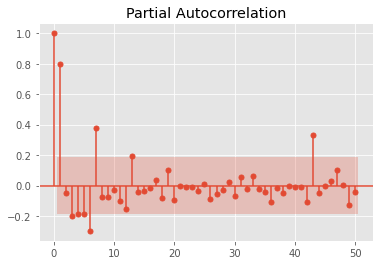

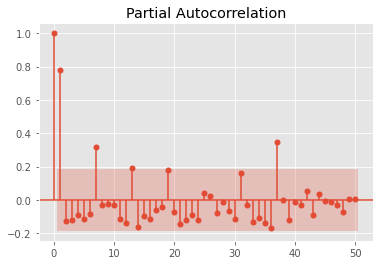

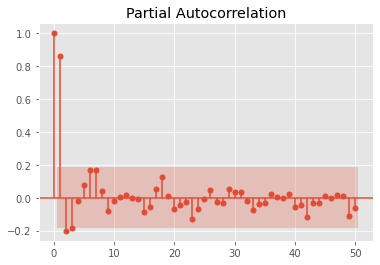

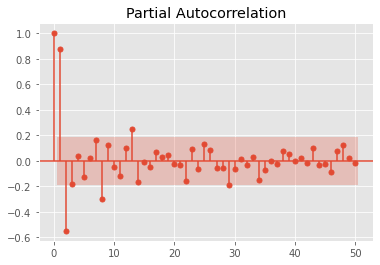

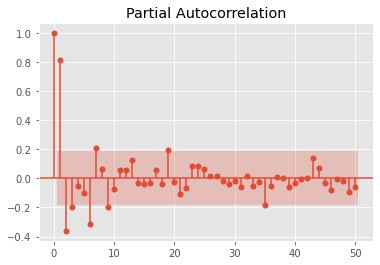

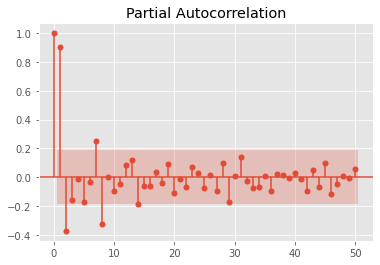

In [11]:
for column in data_diff.columns:
    plot_pacf(data_diff[column], lags=50, method='ywm');

In [18]:
def display_preds(output, column, observed):
    pred = output.get_prediction(start=pd.to_datetime('2018-01-31'), dynamic=False)
    pred_conf = pred.conf_int()
    
    rcParams['figure.figsize'] = 15, 6
    ax = observed[column].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)
    ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)
    ax.set_xlabel('Date')
    ax.set_ylabel('Typical Home Value')
    ax.set_title(column)
    plt.legend()
    plt.show()
    
def display_dynamic_preds(output, column, observed):
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2018-01-31'), dynamic=True, full_results=True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    rcParams['figure.figsize'] = 15, 6
    ax = observed[column].plot(label='observed')
    pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)
    ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)
    ax.set_xlabel('Date')
    ax.set_ylabel('Typical Home Value')
    ax.set_title(column)
    plt.legend()
    plt.show()
    
def generate_forecast(output, column, observed):
    prediction = output.get_forecast(steps=48)
    pred_conf = prediction.conf_int()
    ax = observed[column].plot(label='observed', figsize=(20, 15))
    prediction.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='k', alpha=0.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Typical Home Value')
    ax.set_title(column)
    plt.legend()
    plt.show()
    
def get_mse(output, column, observed, dynamic=False):
    pred = output.get_prediction(start=pd.to_datetime('2018-01-31'), dynamic=dynamic)
    forecasted = pred.predicted_mean
    truth = observed[column]['2018-01-31':]
    mse = ((forecasted - truth) ** 2).mean()
    return mse

def get_mae(output, column, observed, dynamic=False):
    pred = output.get_prediction(start=pd.to_datetime('2018-01-31'), dynamic=dynamic)
    forecasted = pred.predicted_mean
    truth = observed[column]['2018-01-31':]
    return(mean_absolute_error(truth, forecasted))

I put both the original data and my differenced data through a method that gave me the best combination of orders. See this [notebook](./MaidenVoyage.ipynb). I used these combinations to fit models on both sets of data.

In [13]:
pre_models = []
for column in final_ts.columns:
    pre_mod = sm.tsa.statespace.SARIMAX(final_ts[column],
                                    order=(1, 1, 1),
                                    seasonal_order=(1, 1, 1, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    output = pre_mod.fit()
    pre_models.append(output)

In [14]:
models = []
for column in data_diff.columns:
    mod = sm.tsa.statespace.SARIMAX(data_diff[column],
                                    order=(0, 0, 0),
                                    seasonal_order=(1, 1, 0, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    output = mod.fit()
    models.append(output)

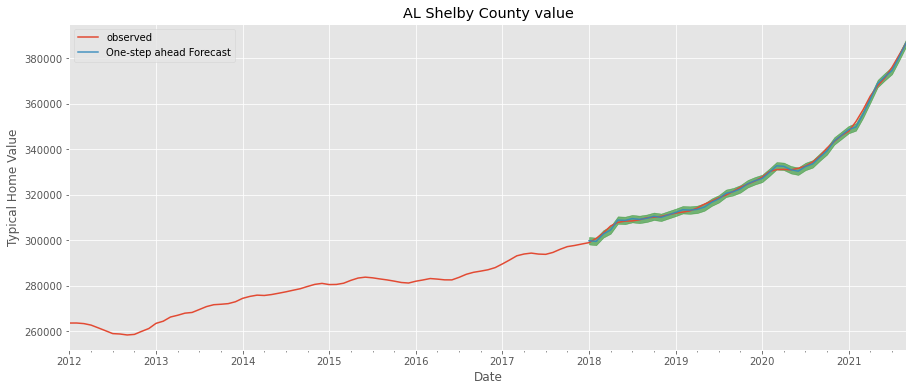

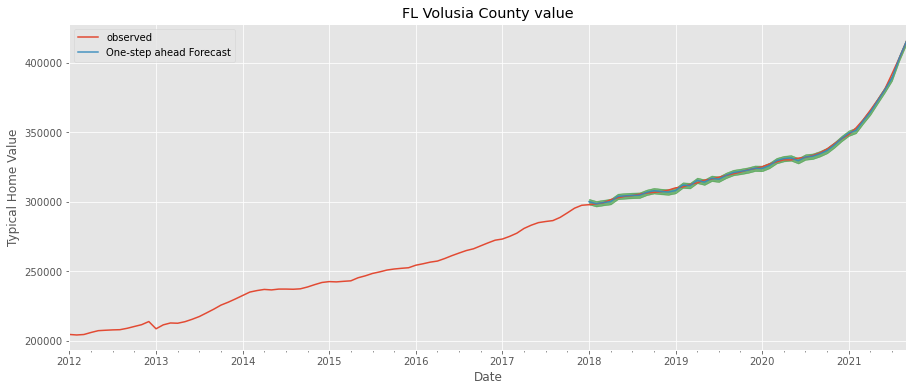

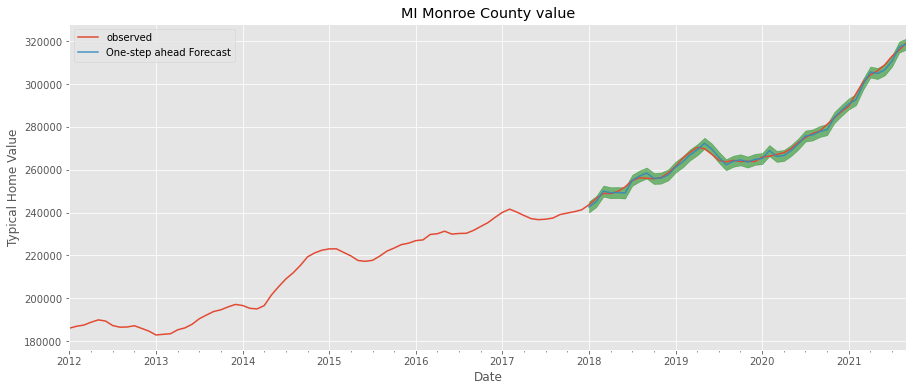

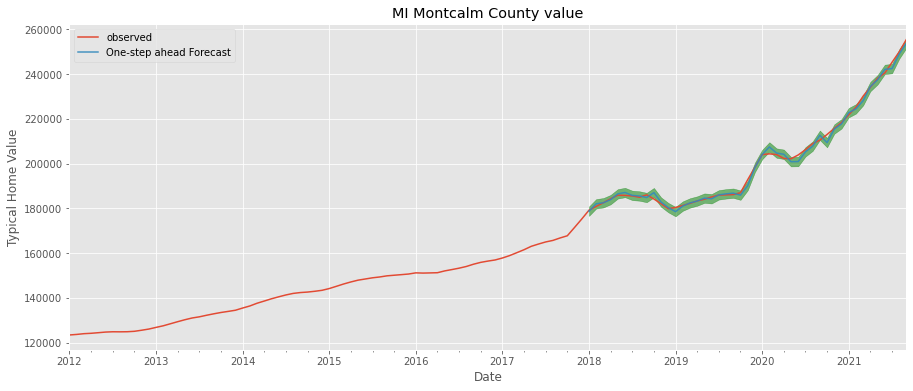

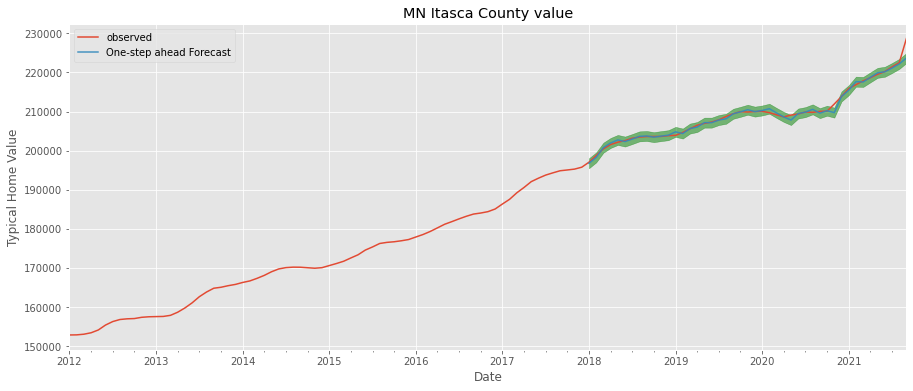

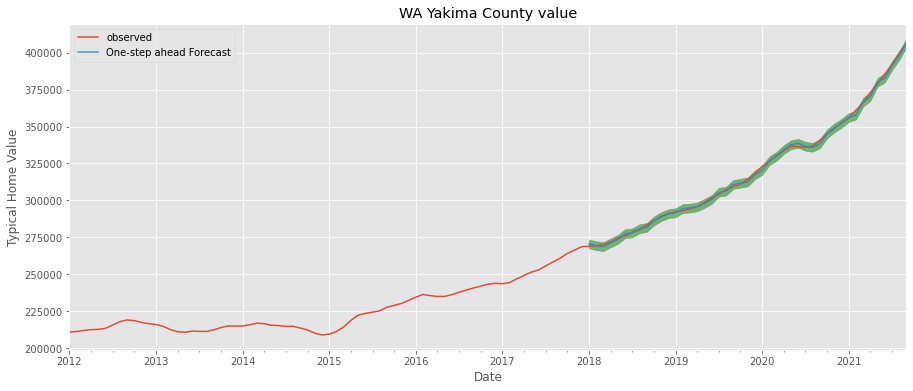

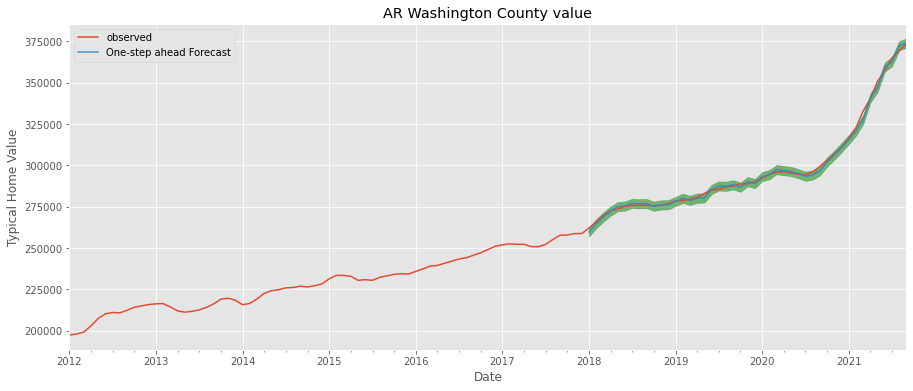

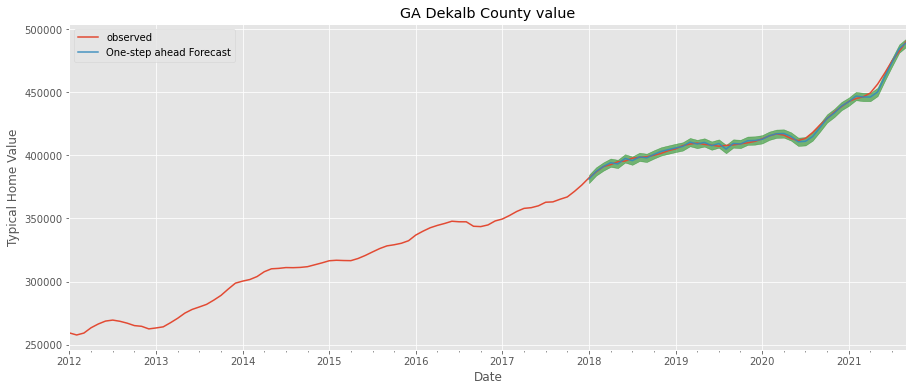

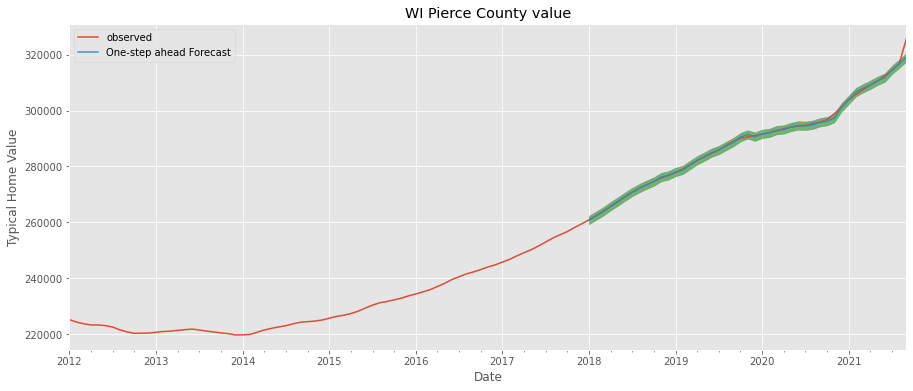

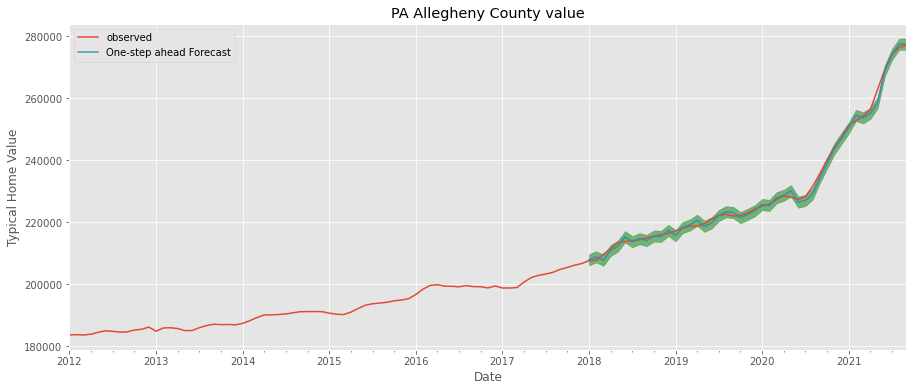

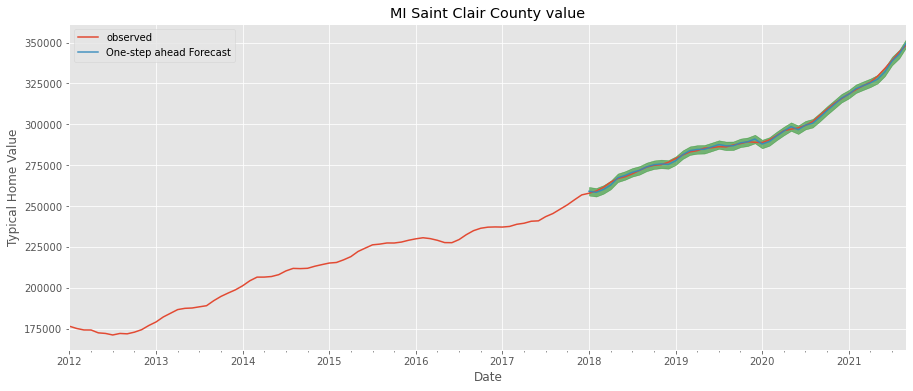

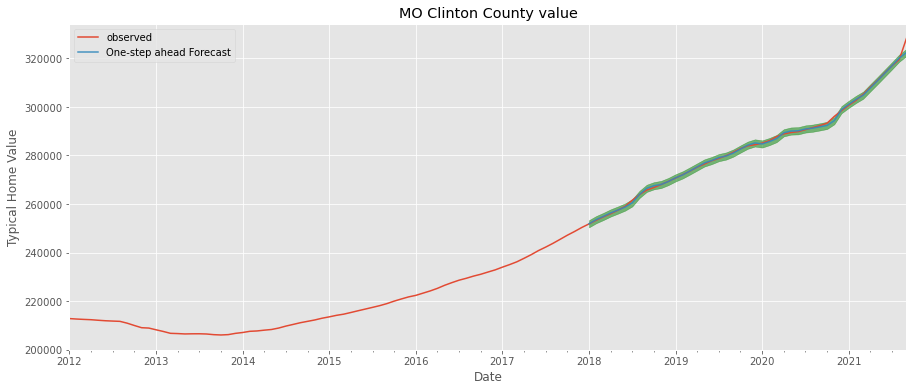

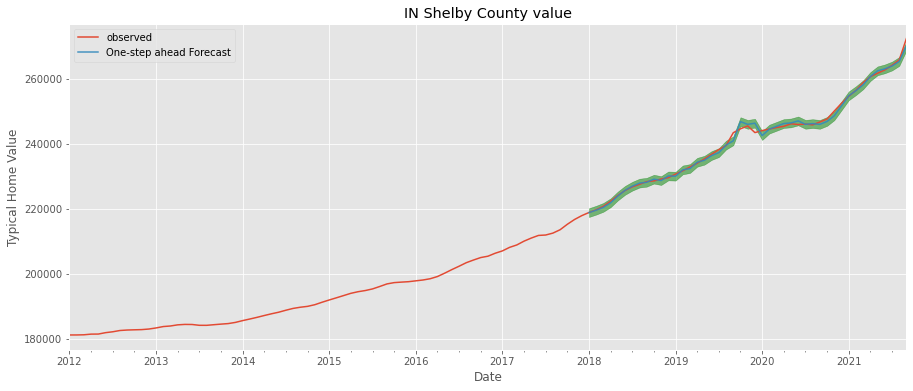

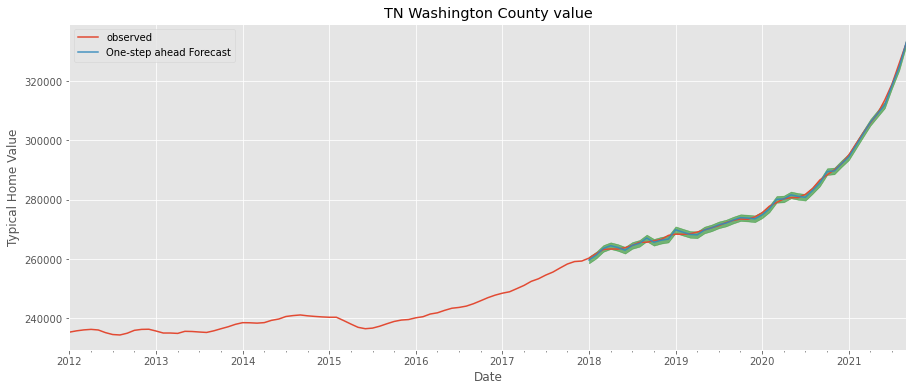

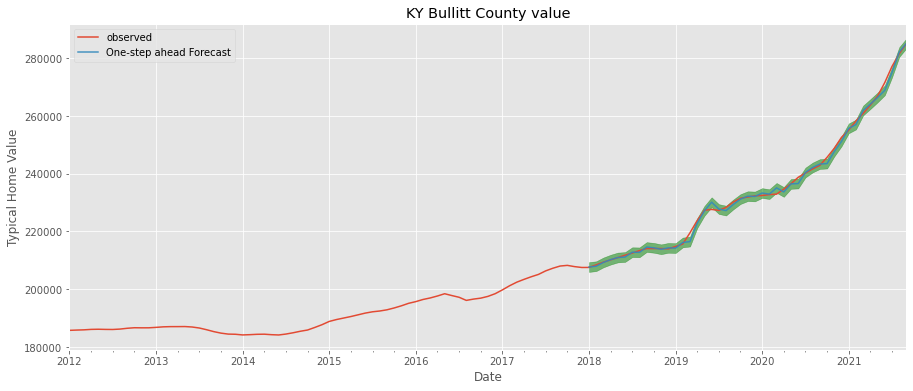

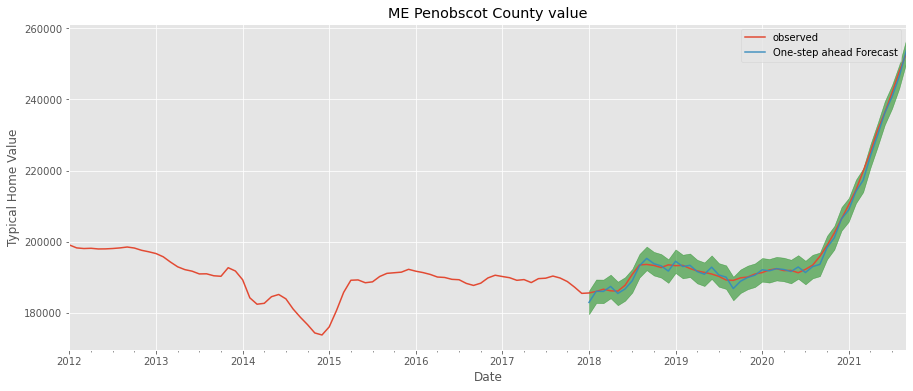

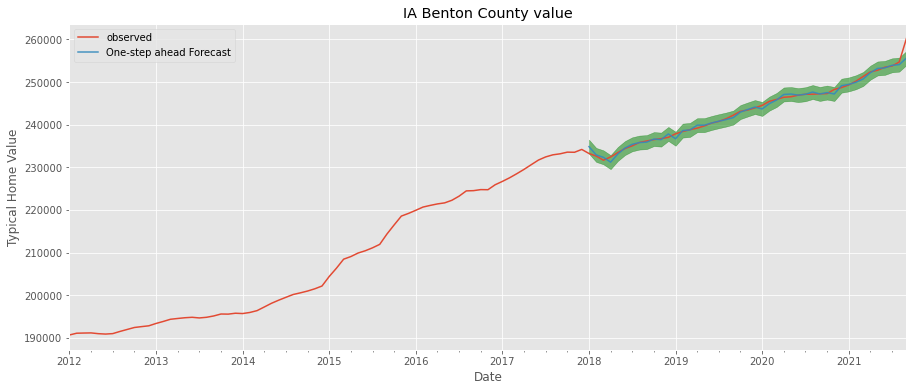

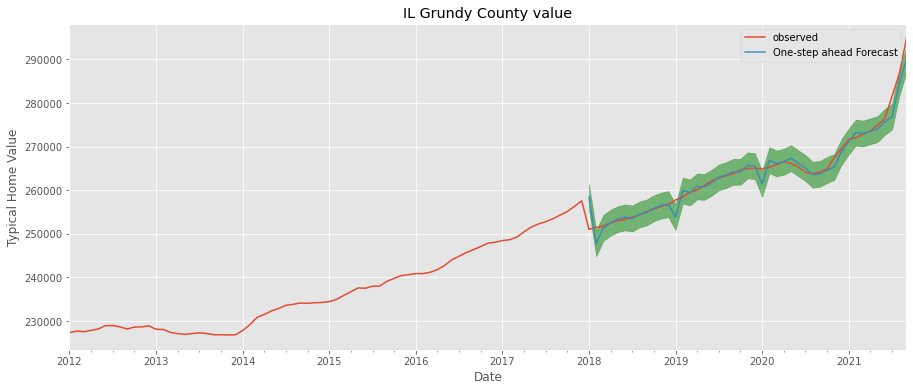

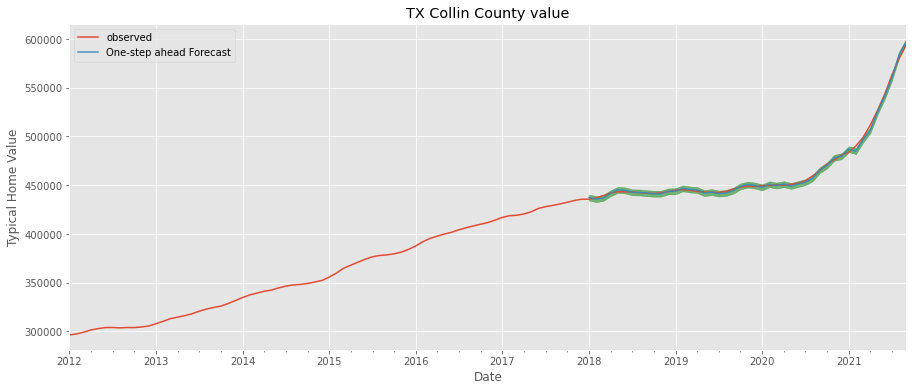

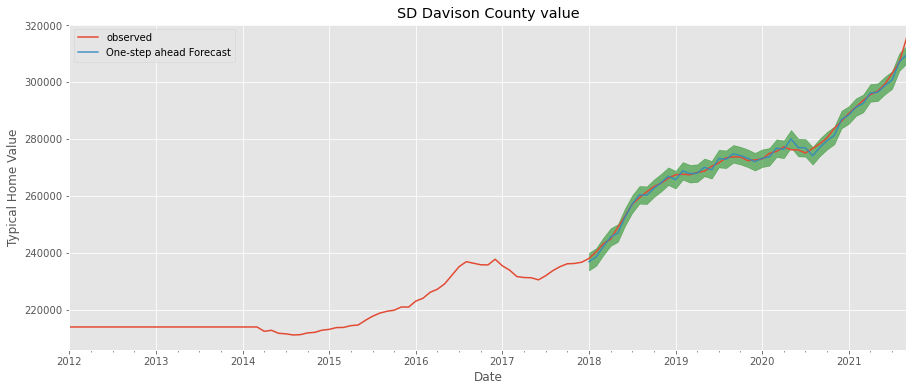

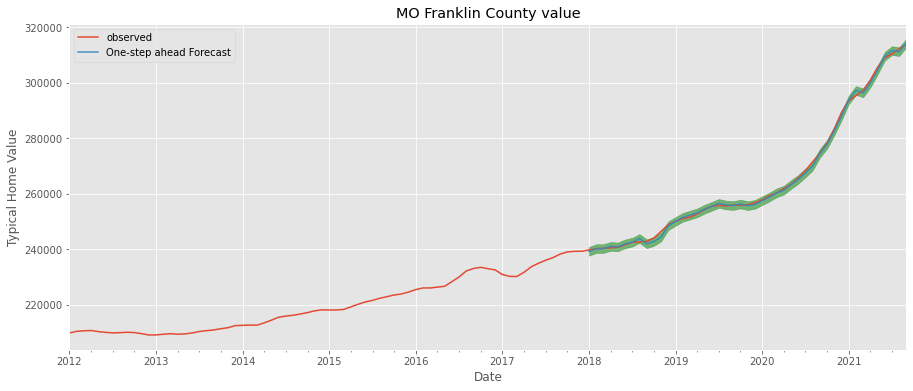

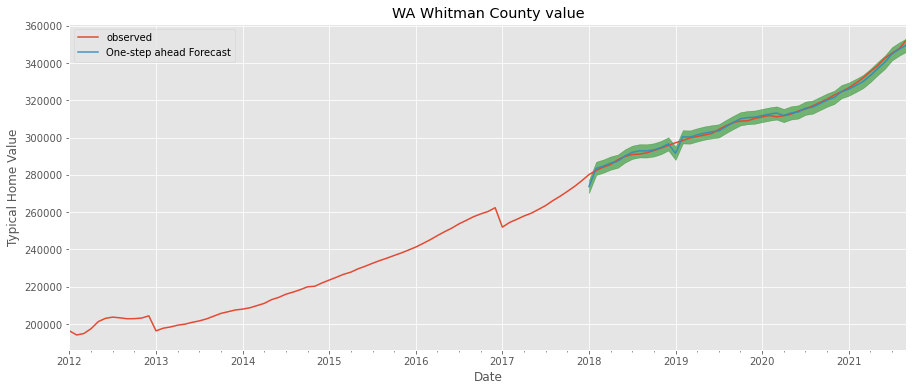

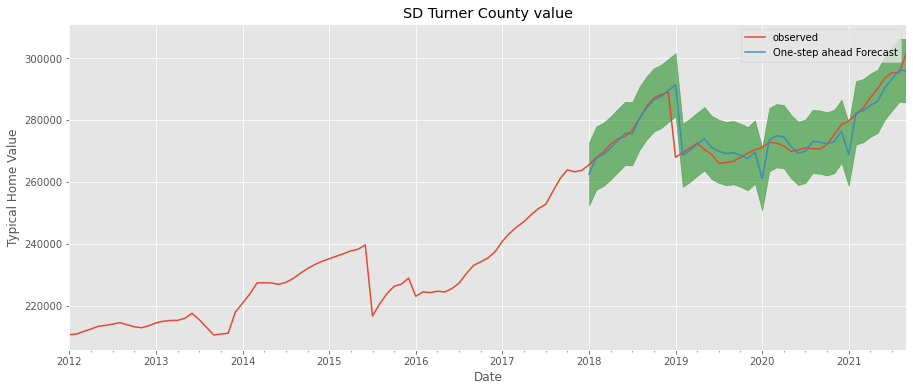

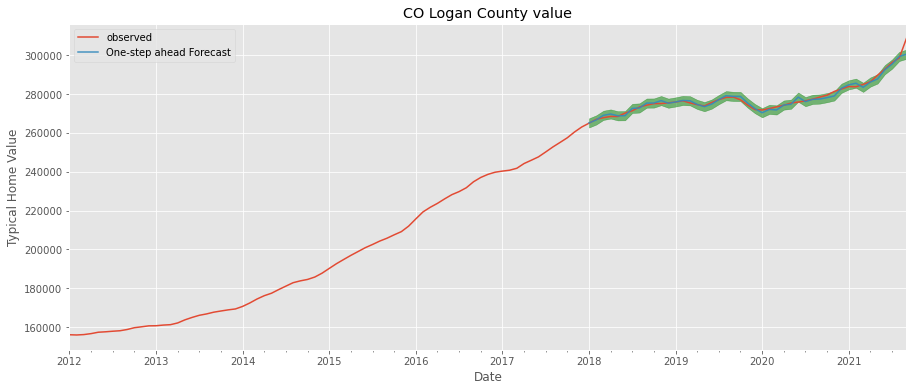

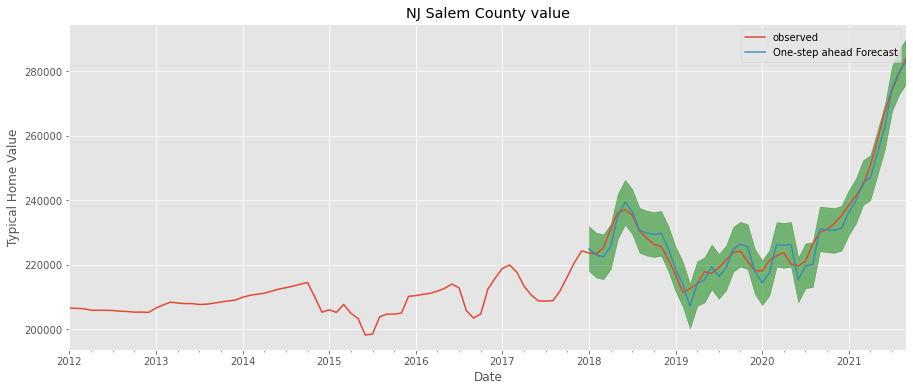

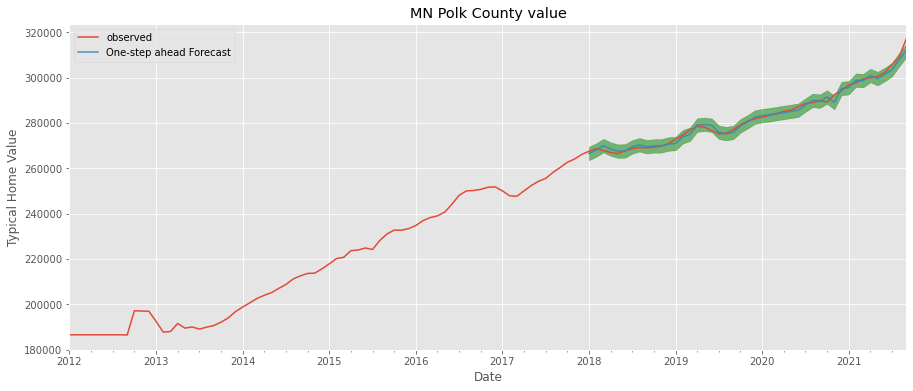

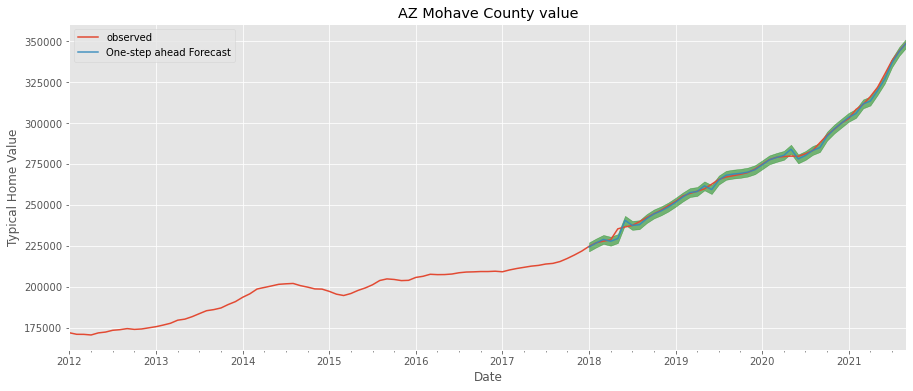

In [15]:
for i in range(len(pre_models)):
    display_preds(pre_models[i], final_ts.columns[i], final_ts)

In [19]:
pre_maes = [get_mae(models[x], final_ts.columns[x], final_ts, dynamic=True) for x in range(len(models))]
pre_maes

[329456.4472168285,
 329522.82788712694,
 272480.28953490127,
 201537.05064163325,
 209281.71435982088,
 320986.50119358243,
 297678.83452102396,
 418786.89243217336,
 288970.72658979945,
 230376.58568385834,
 294174.2125169501,
 283582.93673820957,
 241671.51223400346,
 280552.8528956728,
 234467.43825757198,
 199733.57573698807,
 243194.68395962246,
 264034.04148377763,
 465366.41549761087,
 273538.20380122913,
 265130.592886446,
 310117.69169194833,
 276207.1581298999,
 277847.2060092139,
 231209.27633696637,
 282845.68949198484,
 273948.858172243]

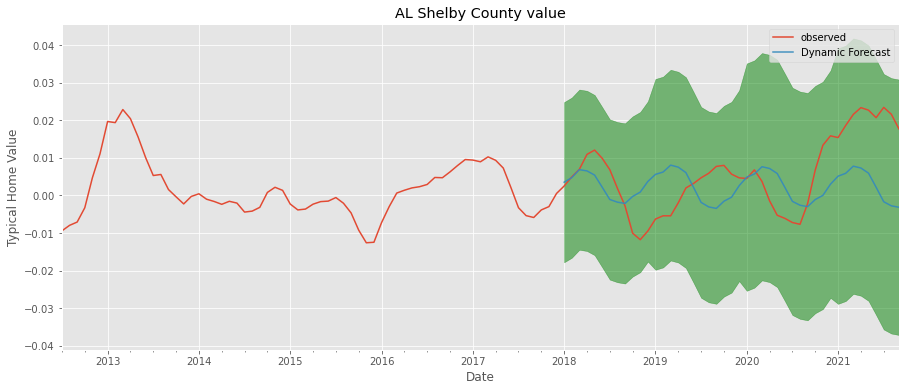

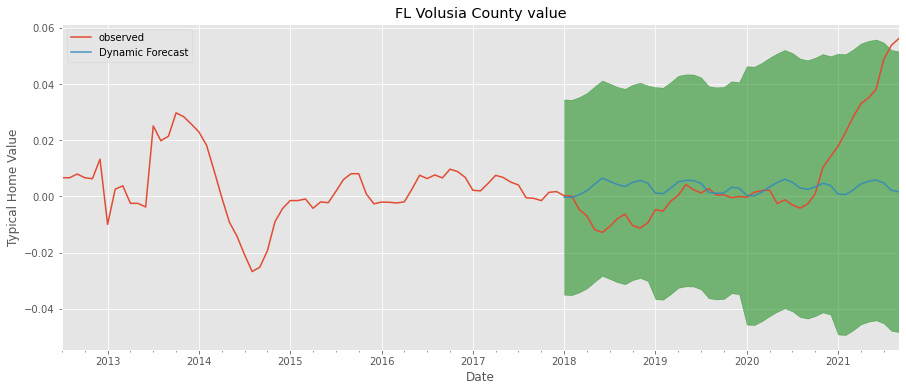

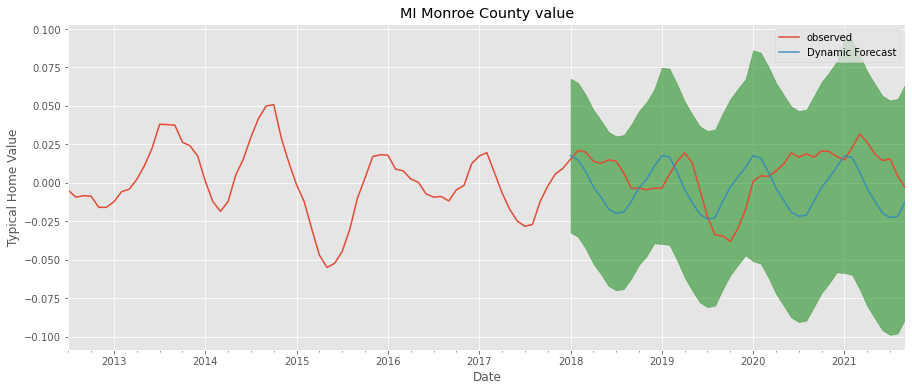

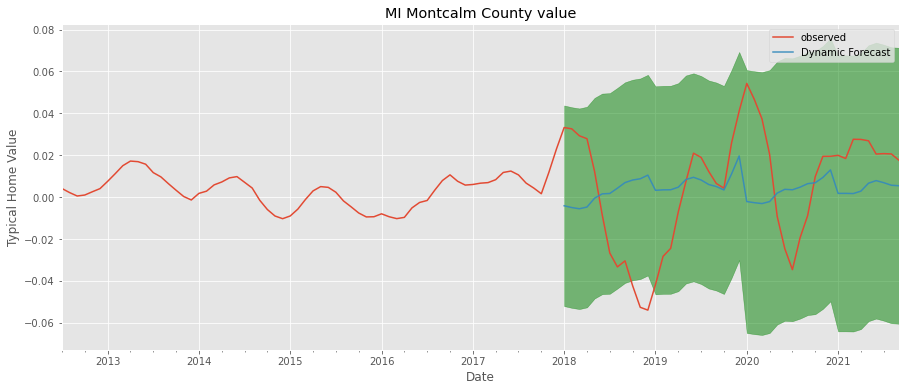

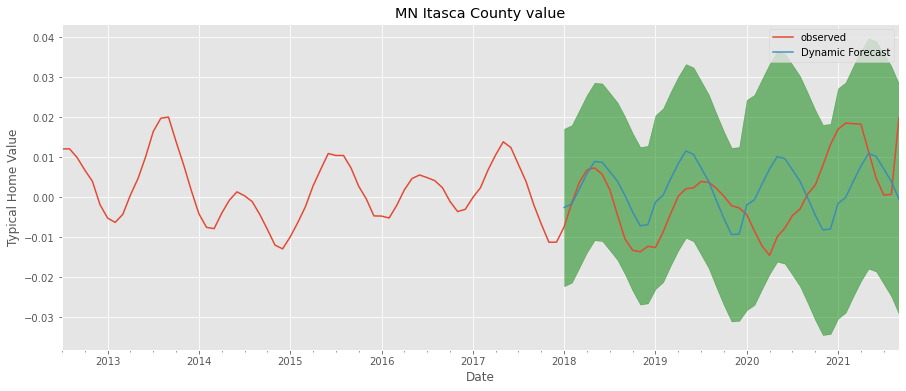

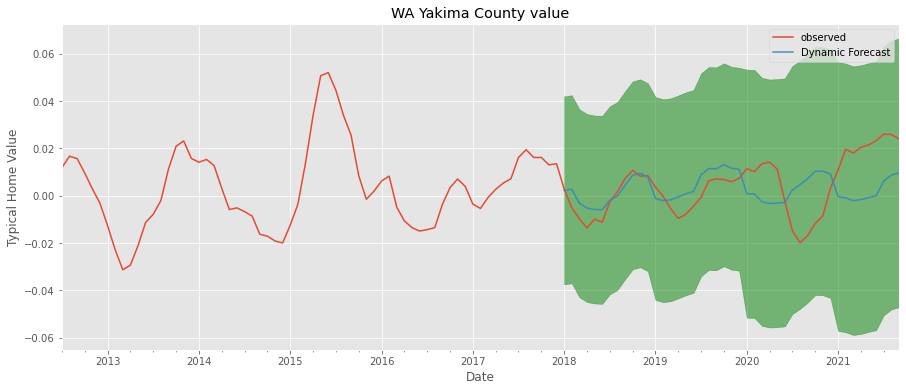

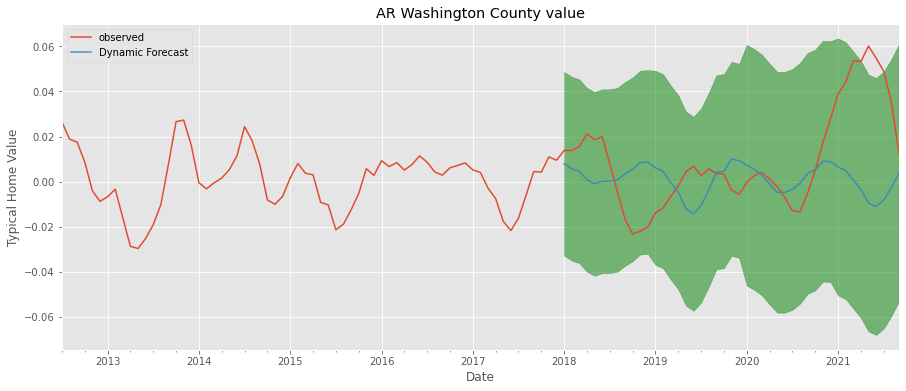

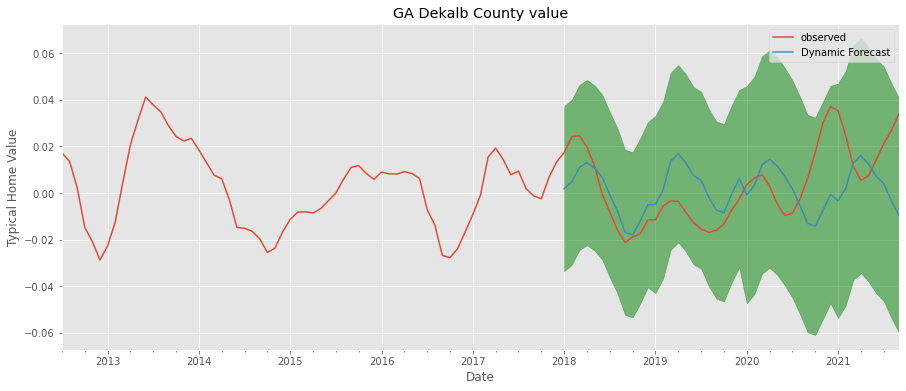

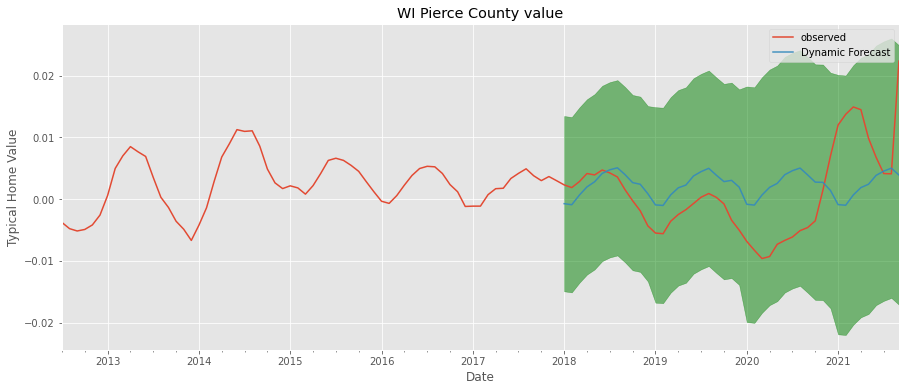

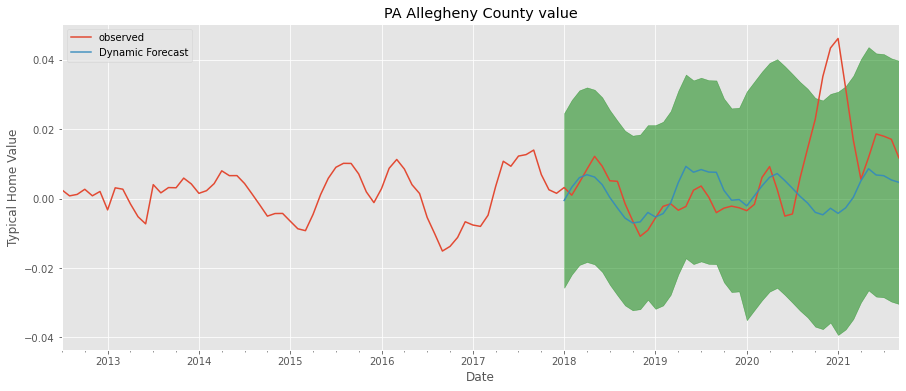

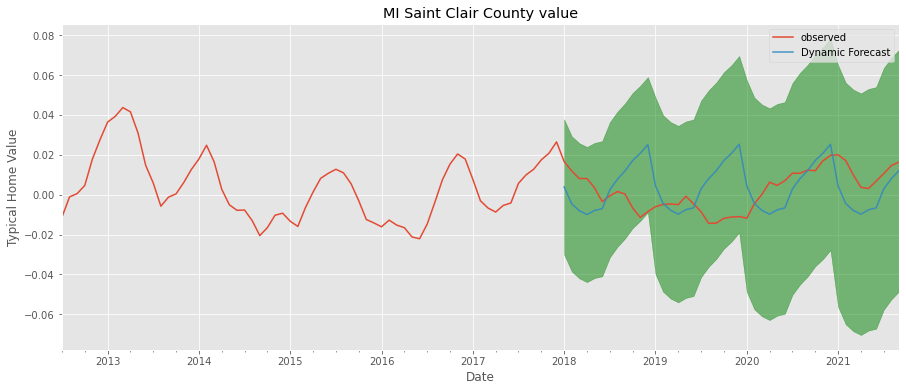

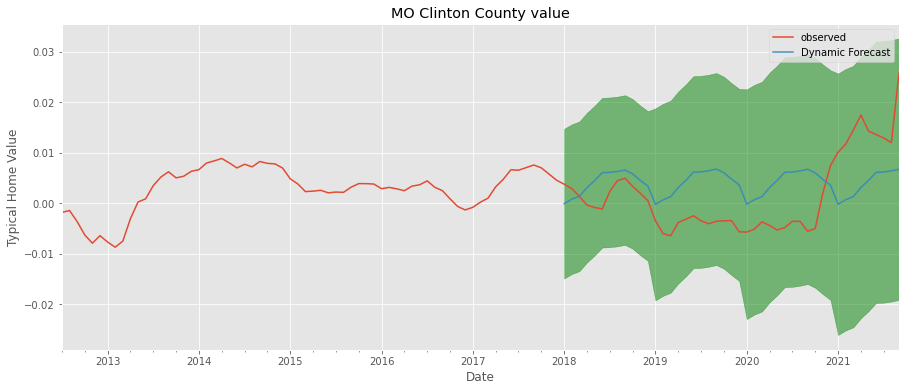

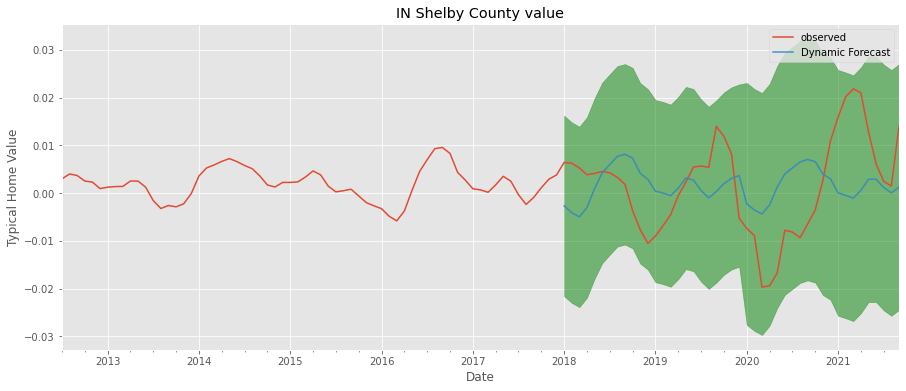

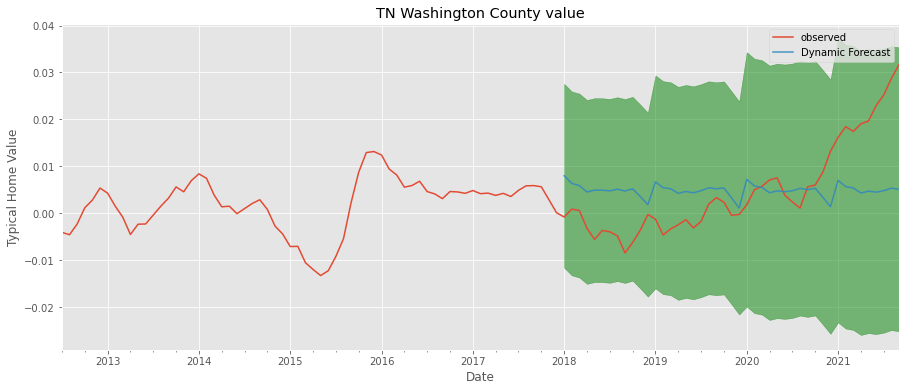

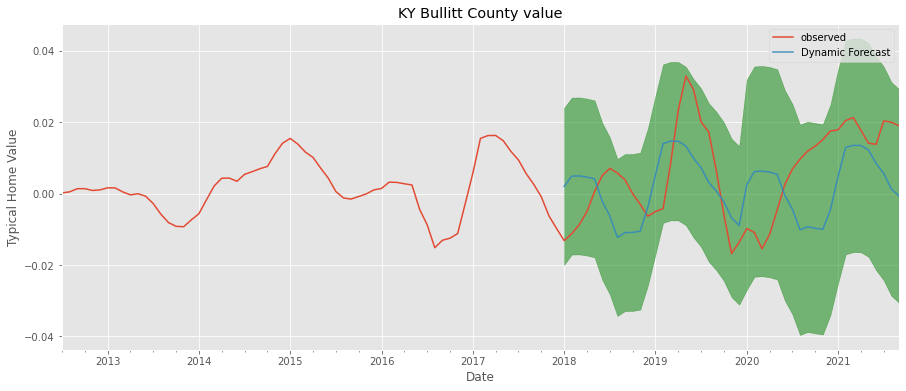

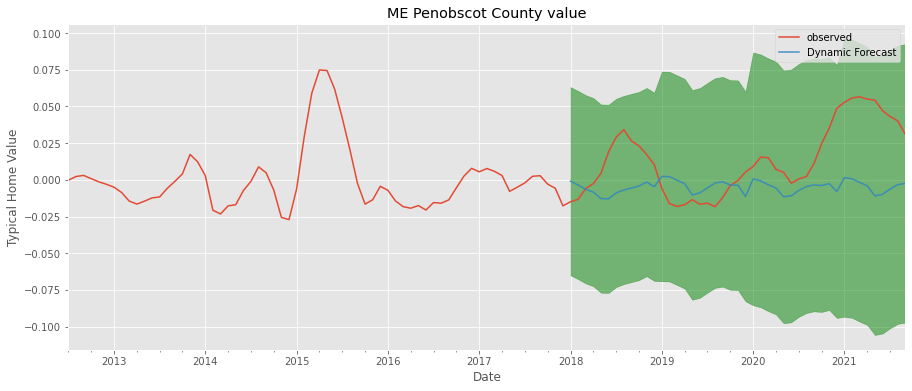

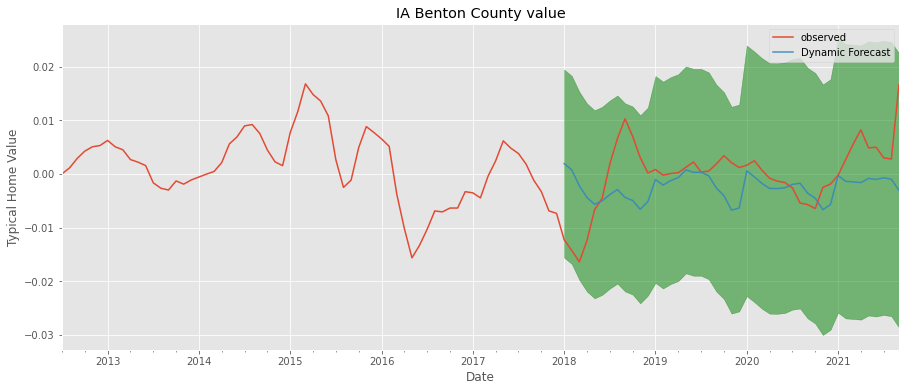

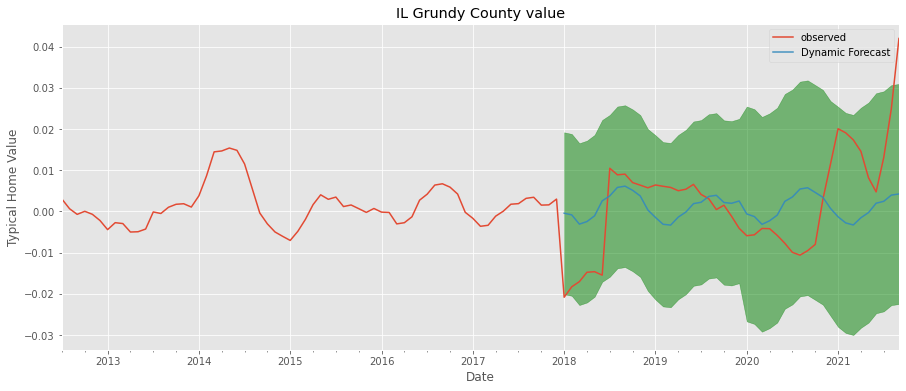

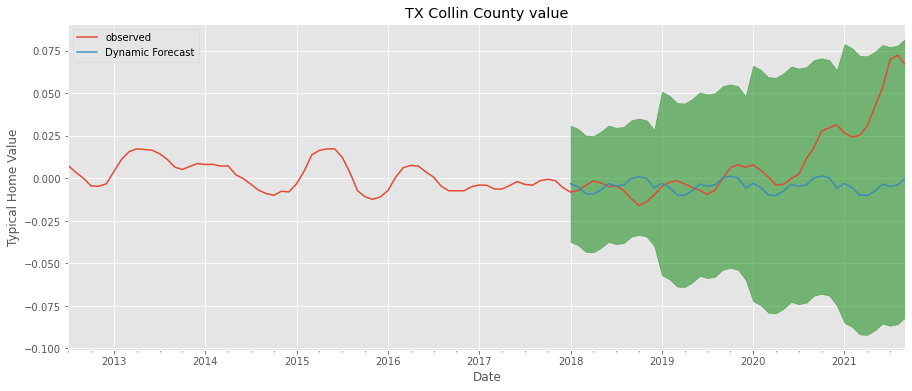

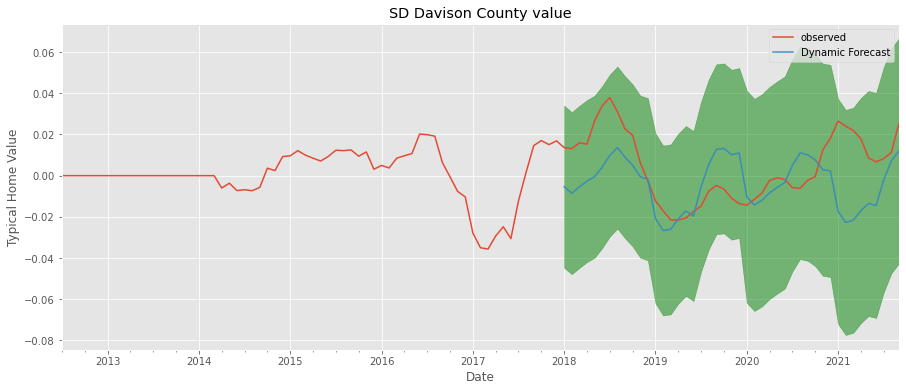

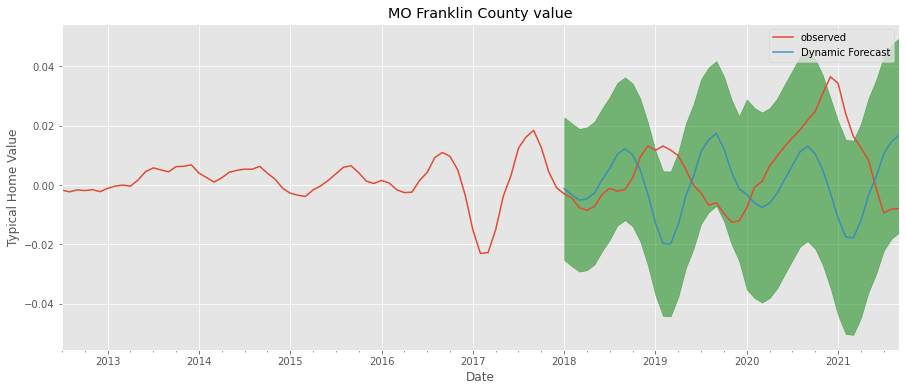

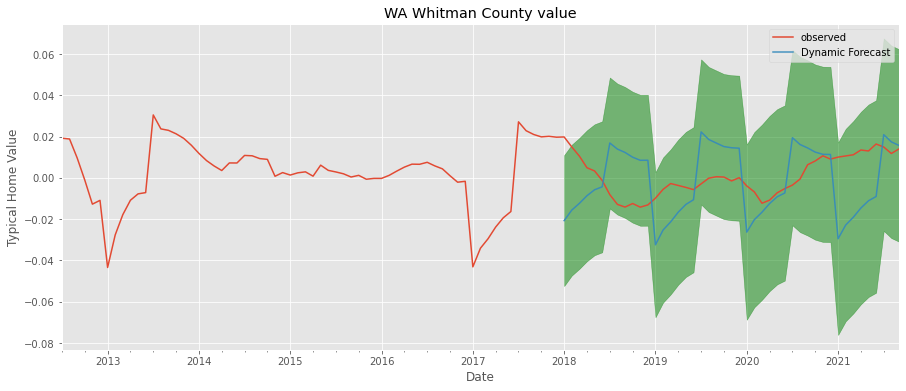

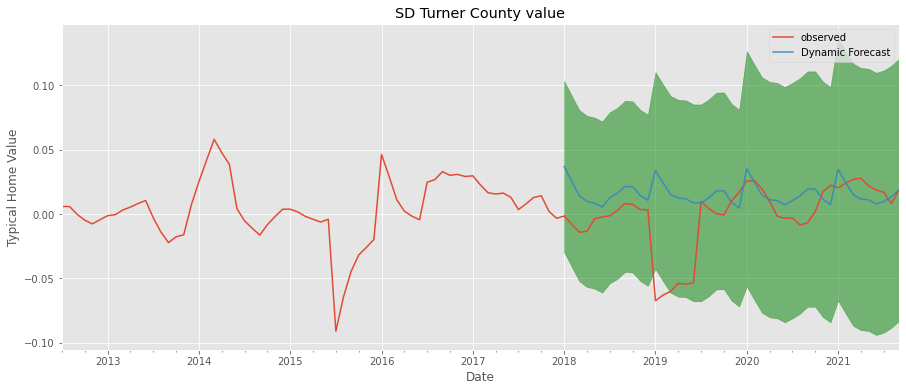

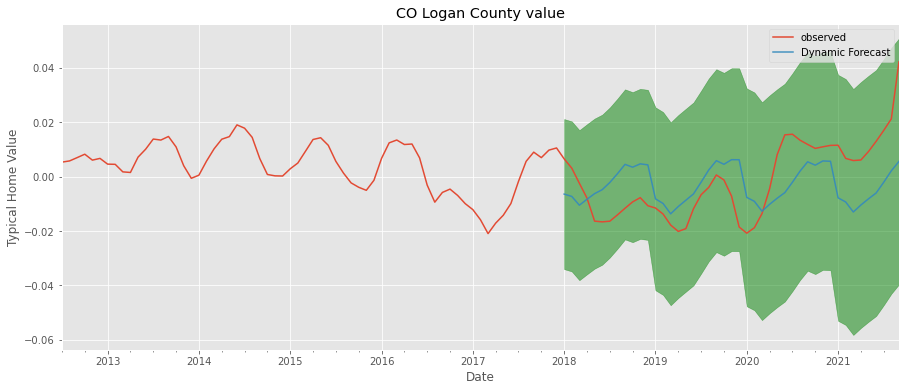

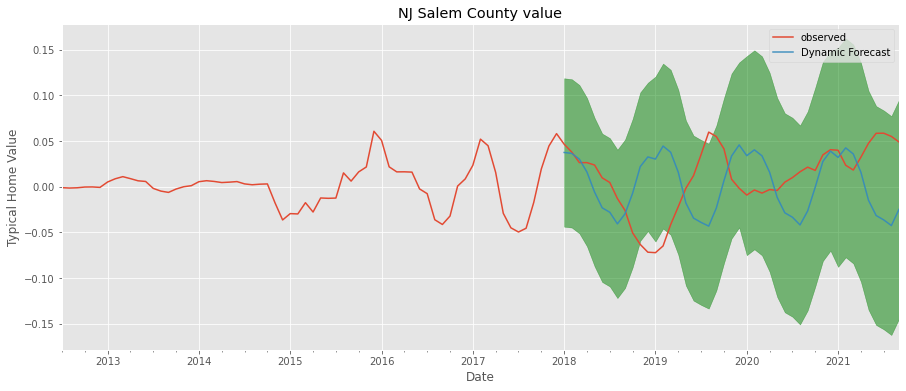

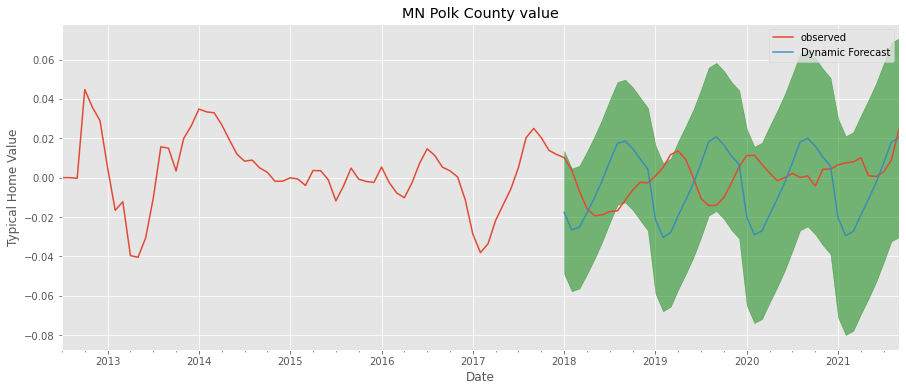

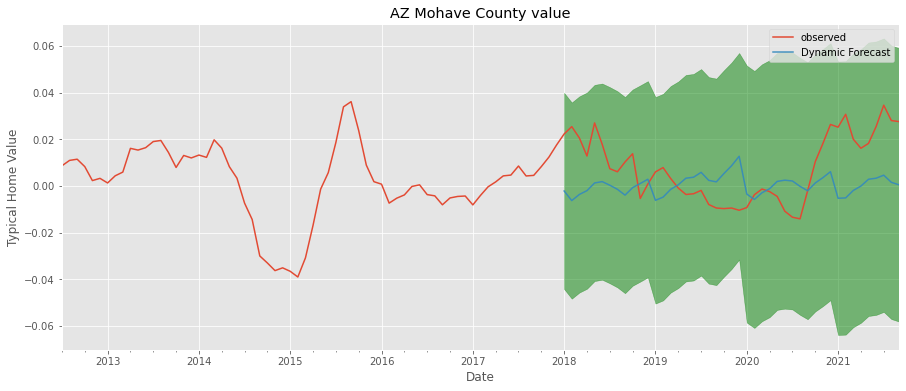

In [20]:
for i in range(len(models)):
    display_dynamic_preds(models[i], data_diff.columns[i], data_diff) 

In [21]:
maes = [get_mae(models[x], data_diff.columns[x], data_diff, dynamic=True) for x in range(len(models))]
maes

[0.008921484033636155,
 0.01194088979908437,
 0.019506288717471728,
 0.024323462016116463,
 0.00856088165345908,
 0.010296911652114172,
 0.018653919209803634,
 0.013895689430407445,
 0.005918972965878478,
 0.00932143048686525,
 0.012815615871649986,
 0.0072689495759440306,
 0.009026295343148614,
 0.00791245522119591,
 0.012494091687497254,
 0.024119158932362293,
 0.005205982704455582,
 0.009645969302501192,
 0.01714001350759142,
 0.015318254536051524,
 0.015557341527378171,
 0.016711409667674877,
 0.021107416834269057,
 0.011928993191302438,
 0.044007083729477564,
 0.019663764654035746,
 0.01441538937172807]

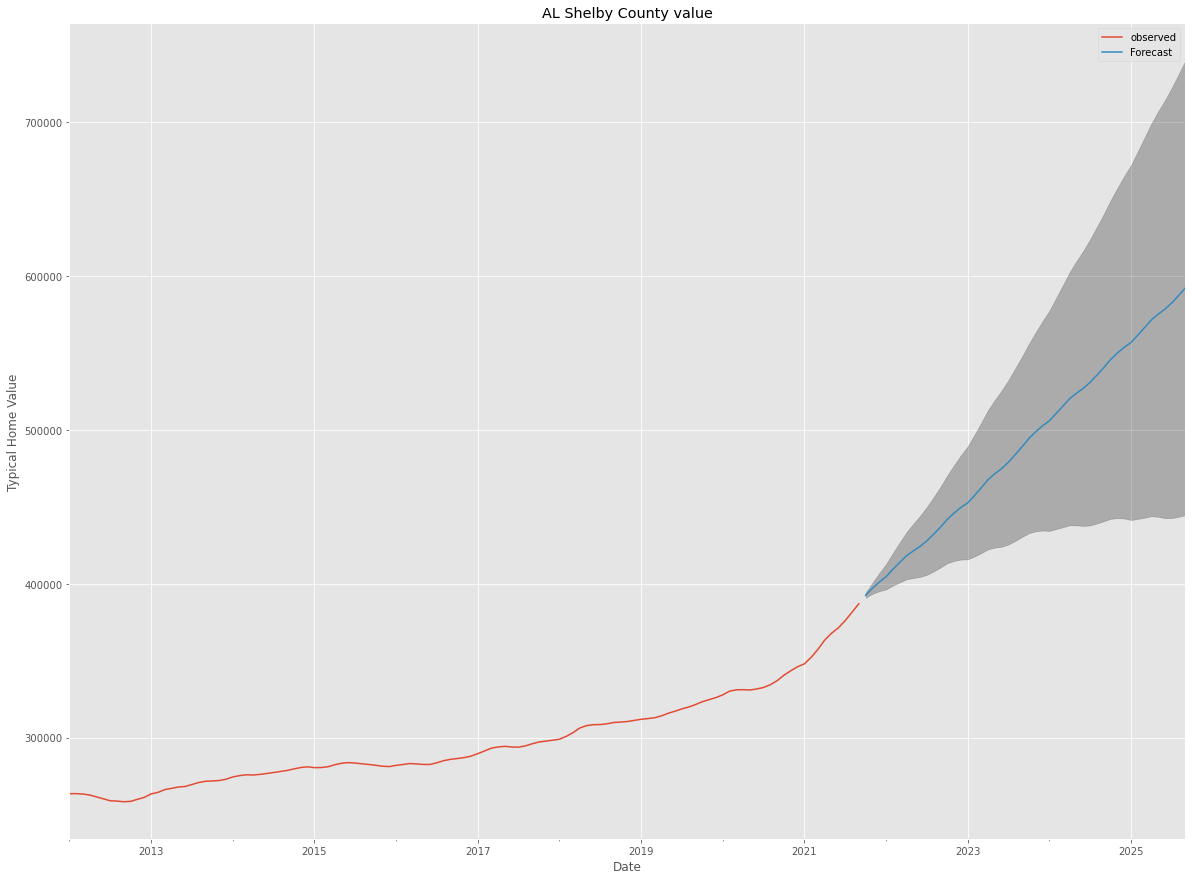

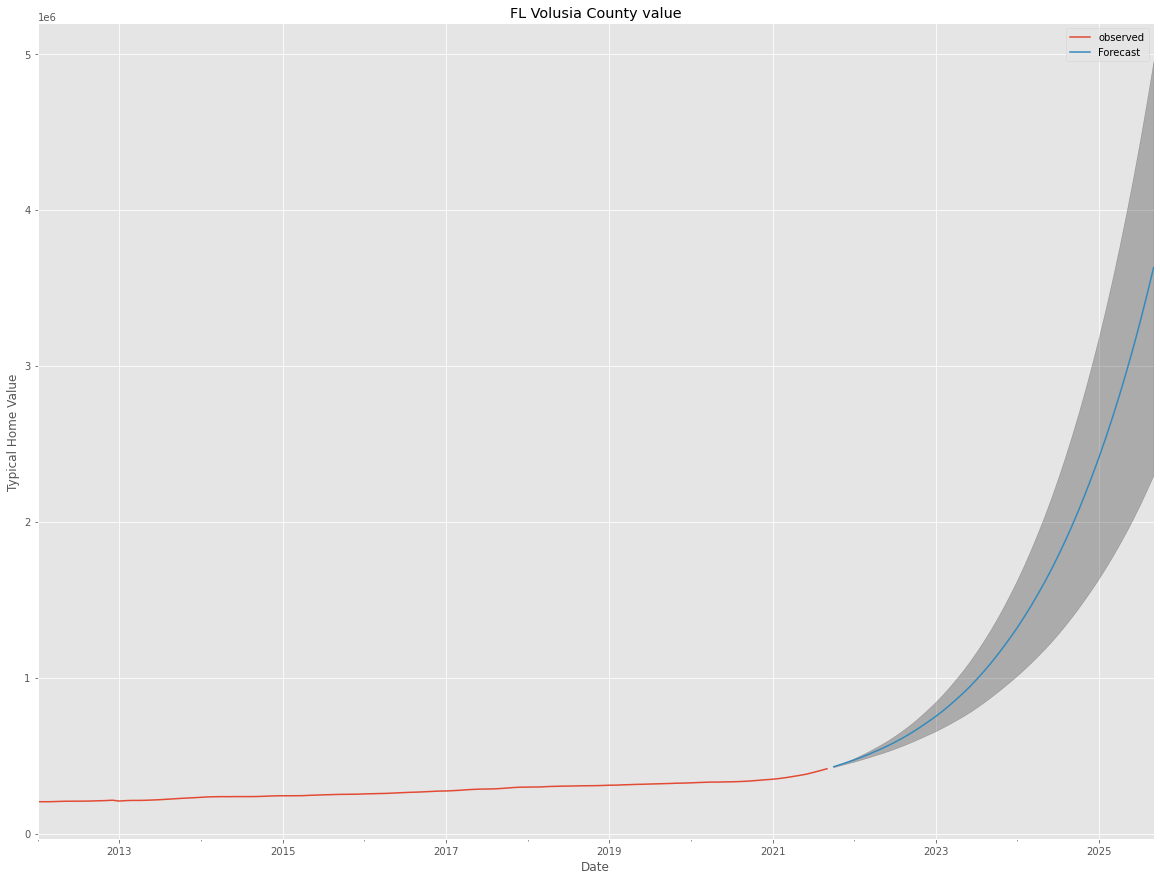

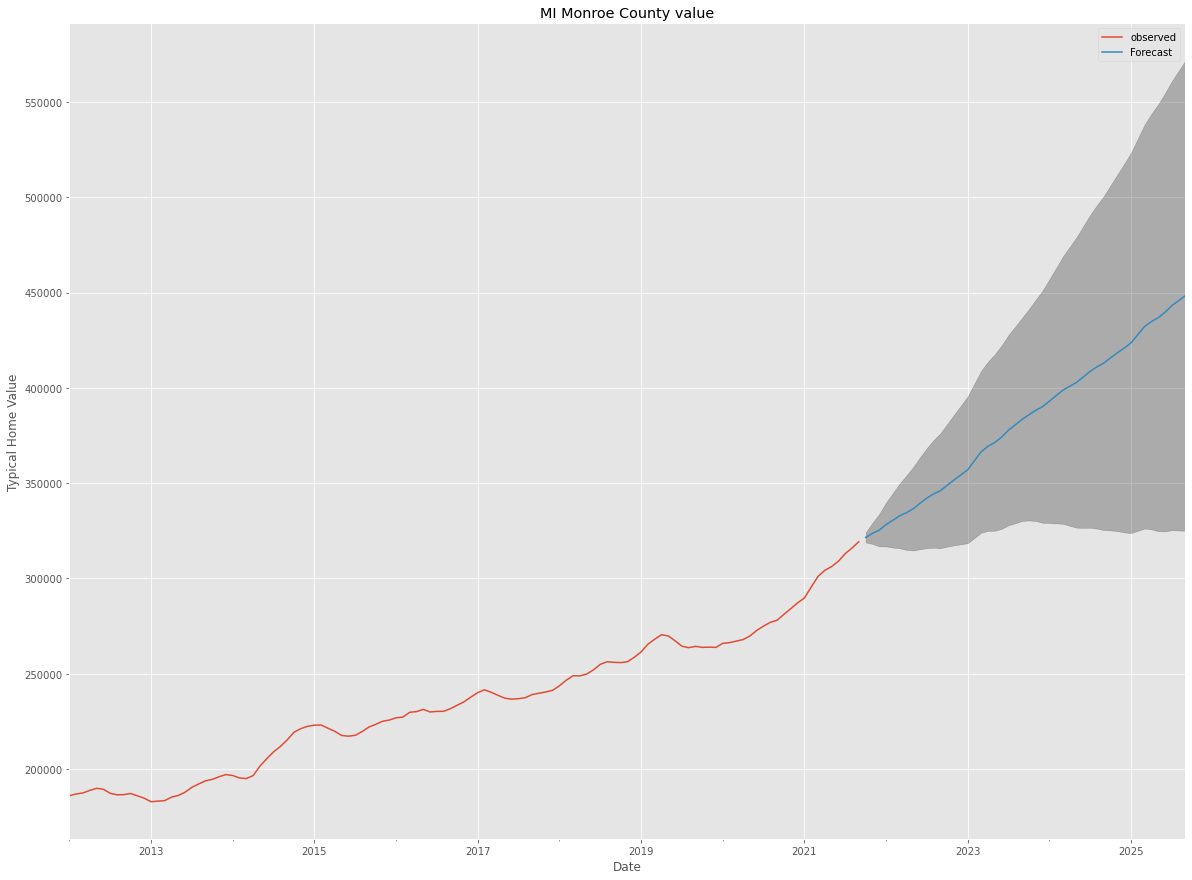

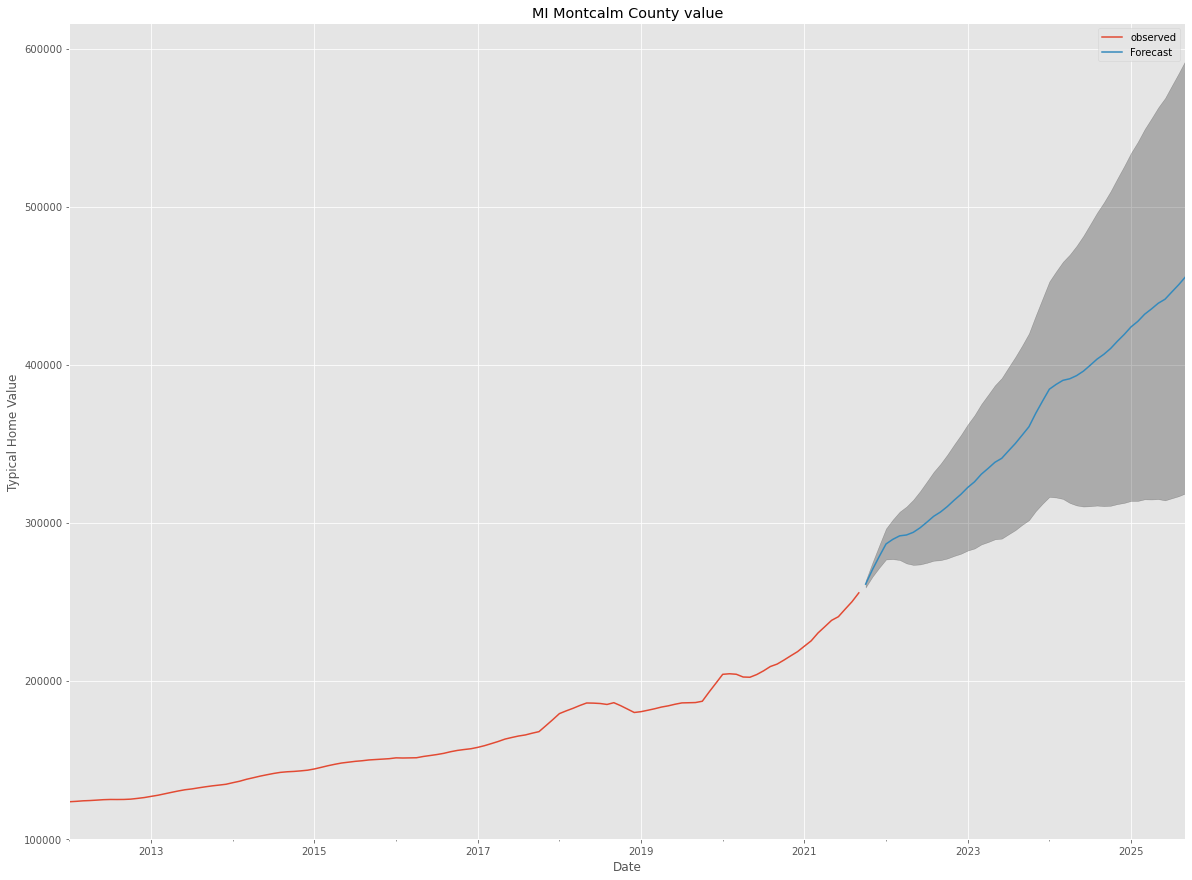

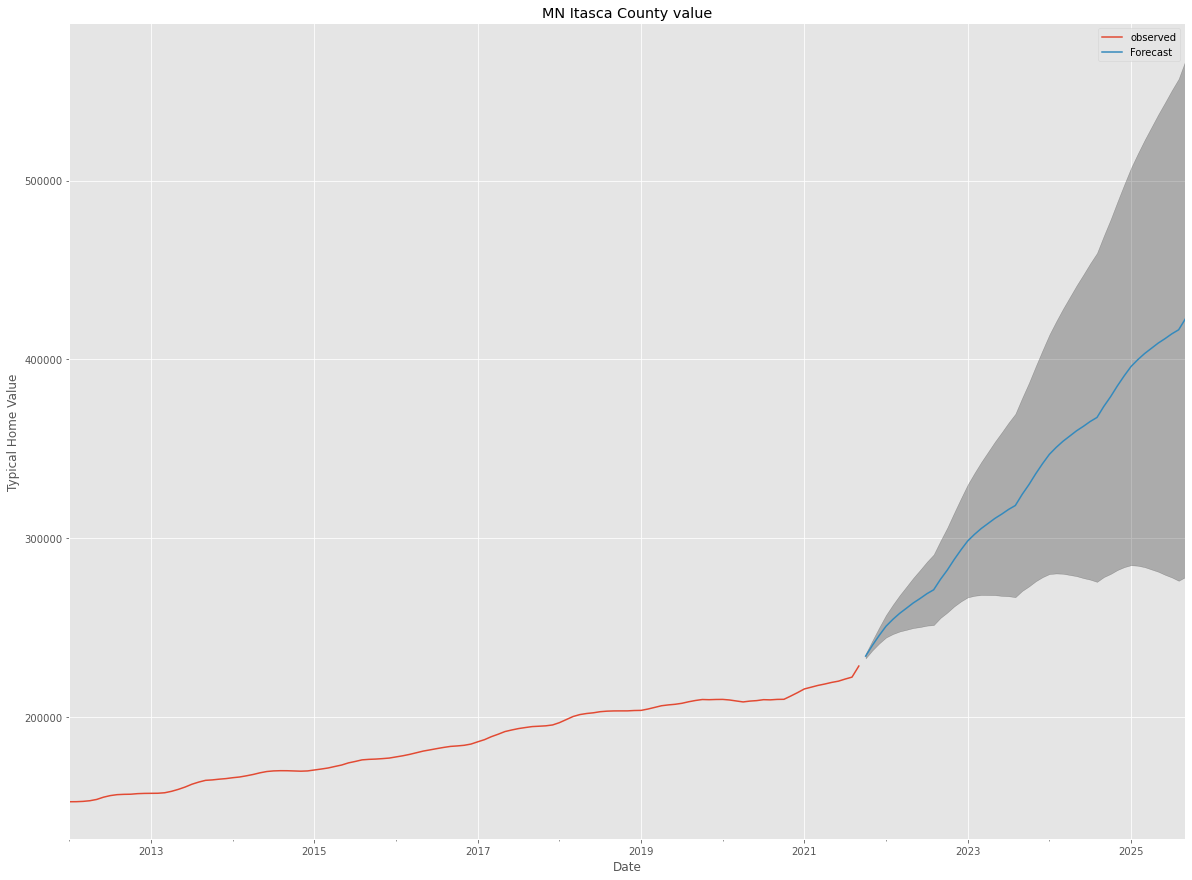

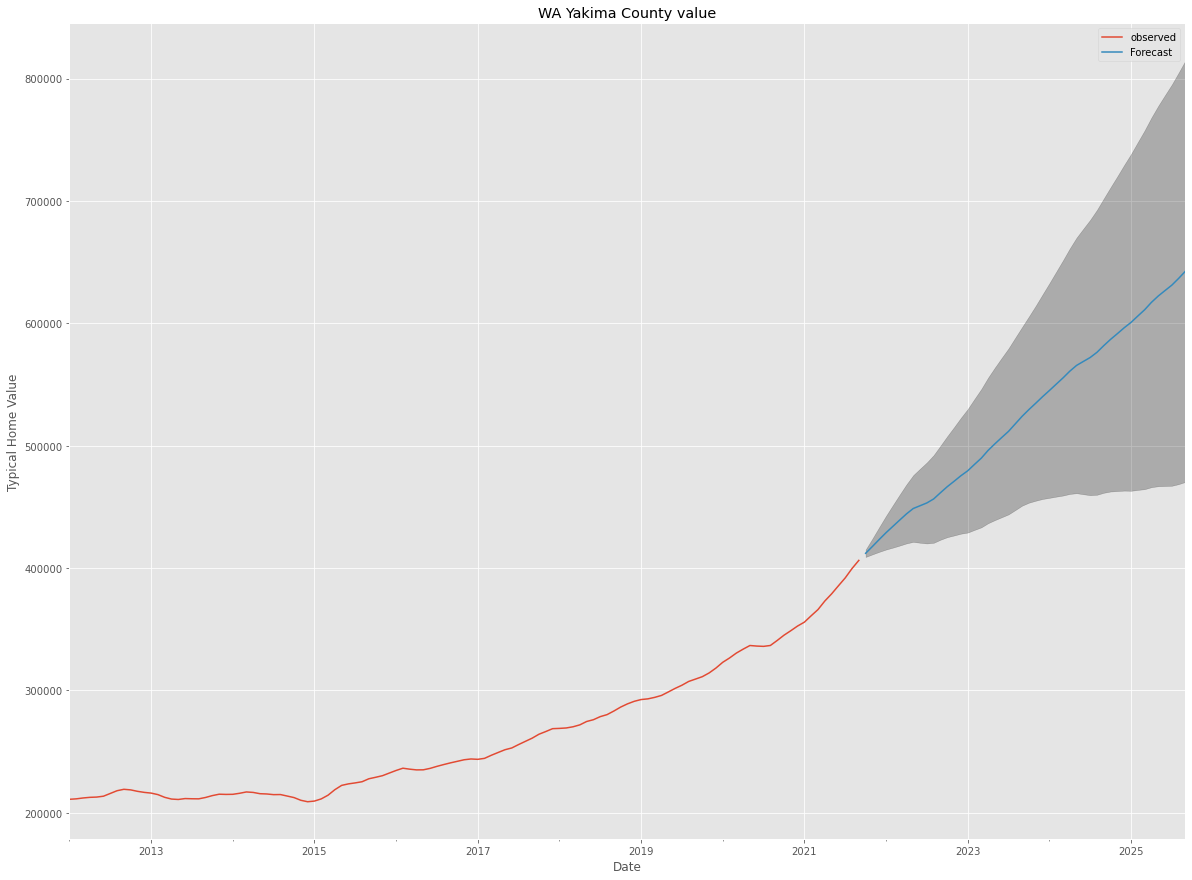

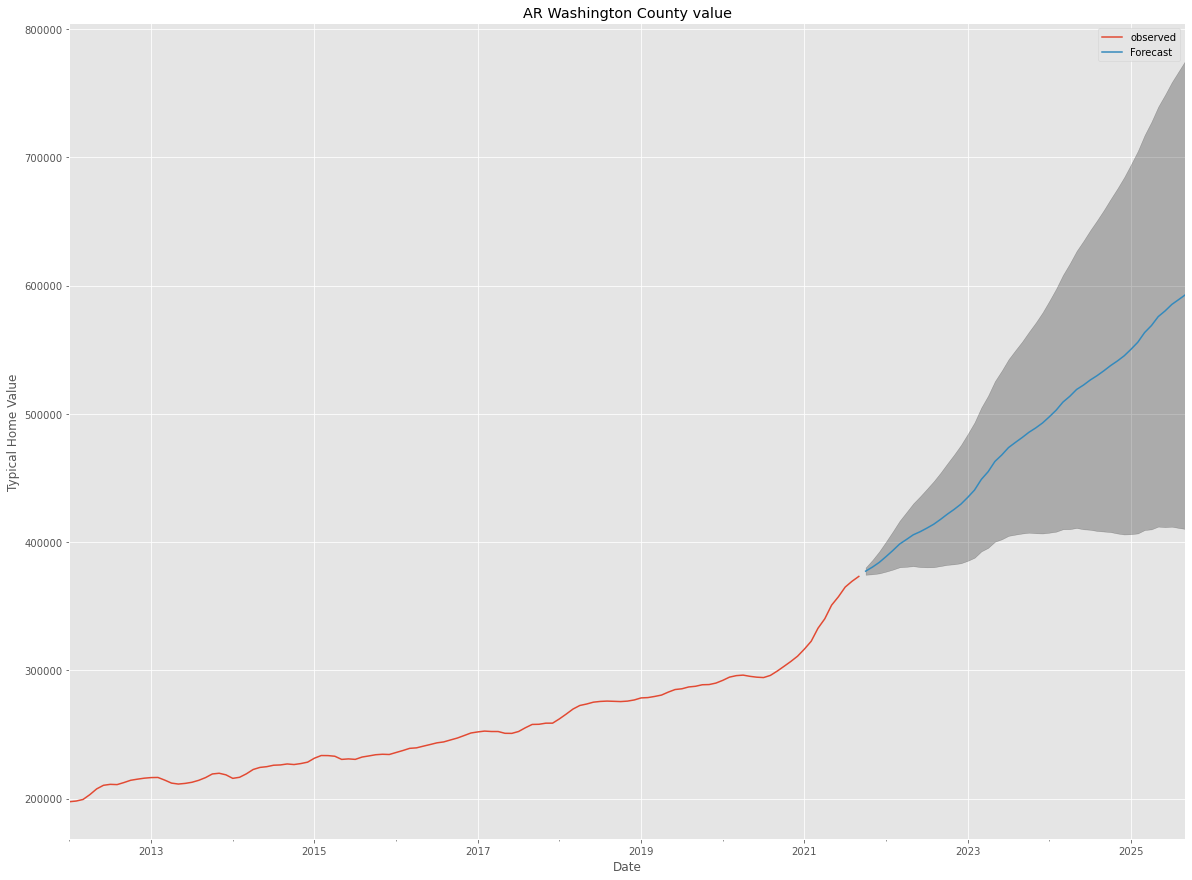

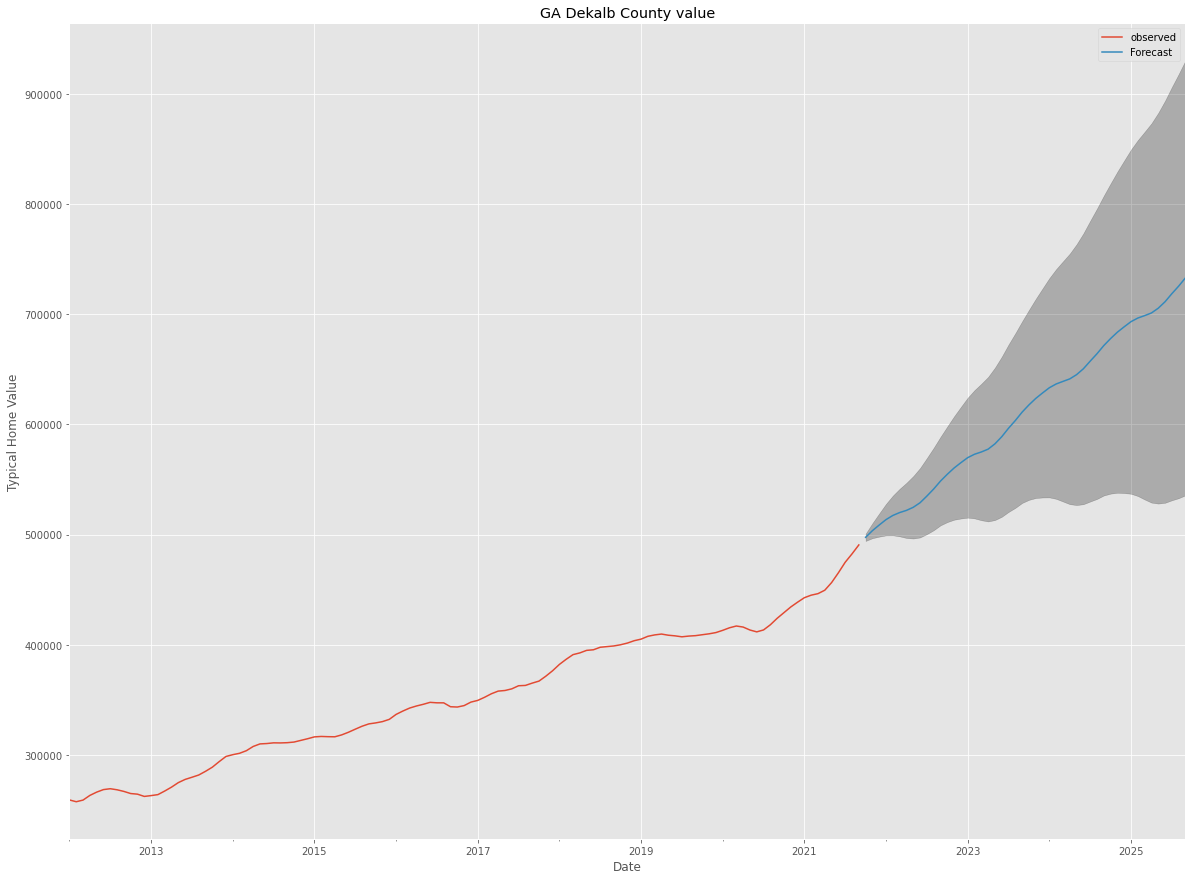

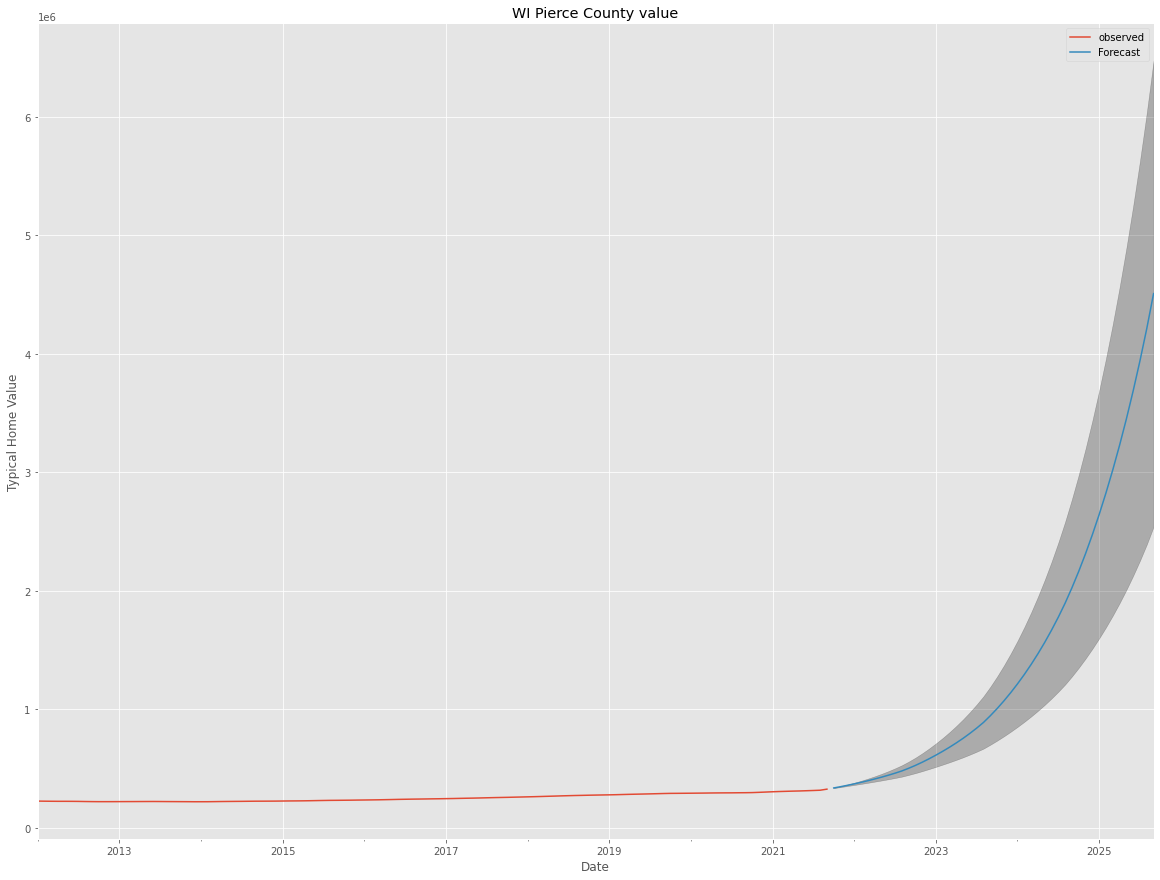

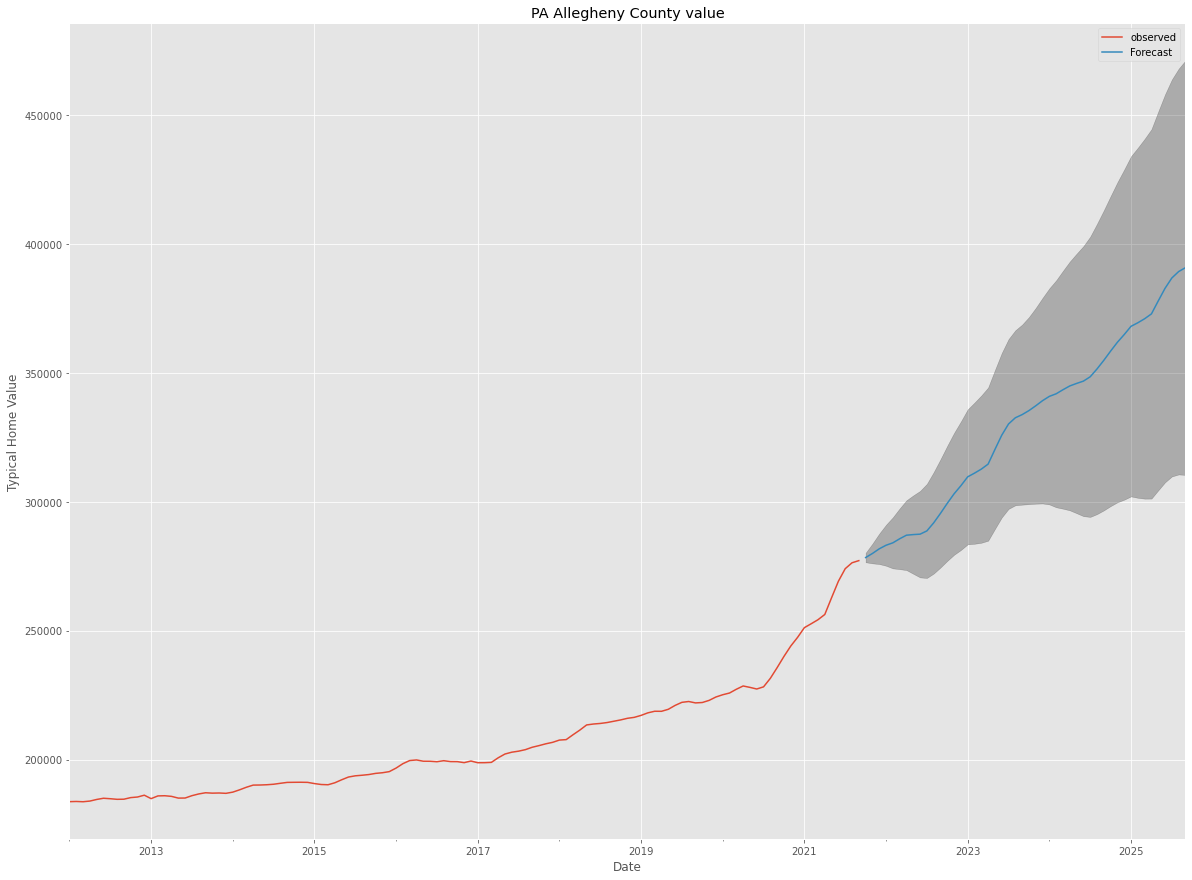

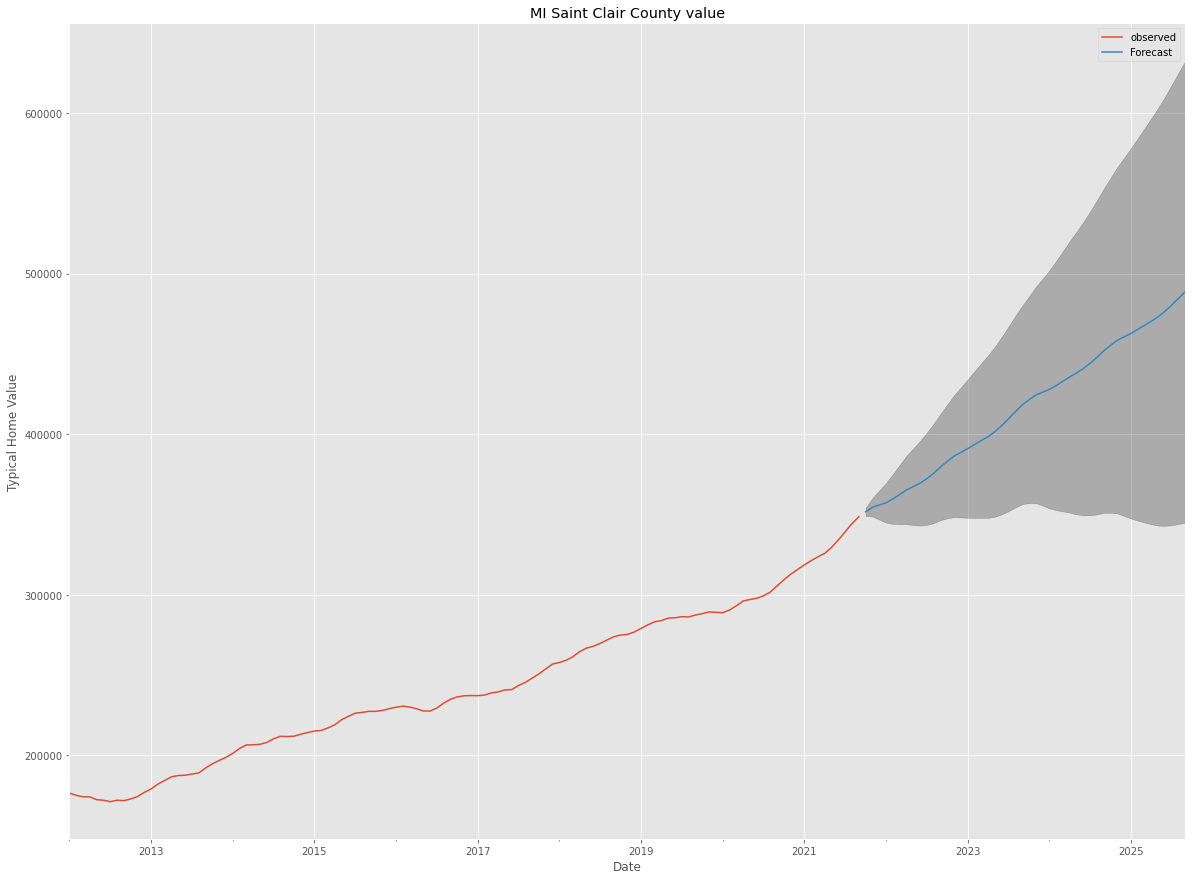

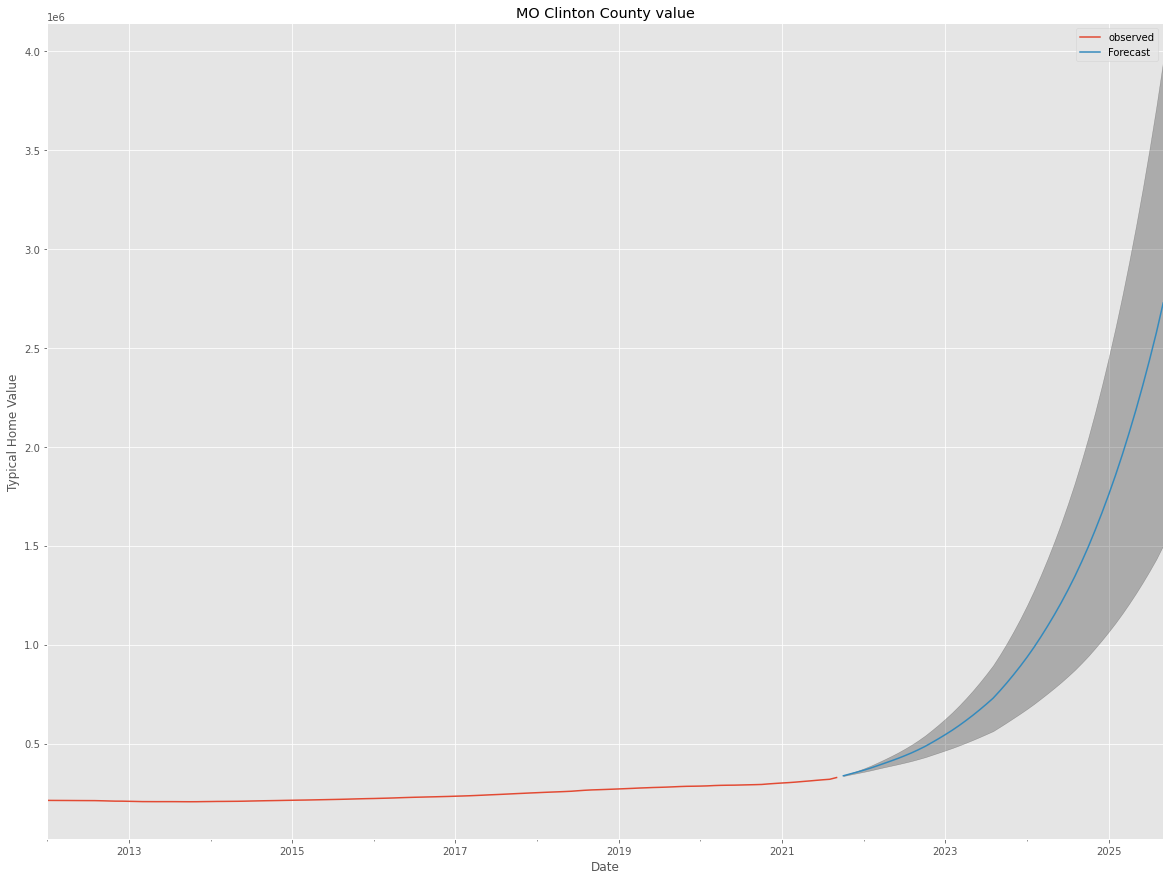

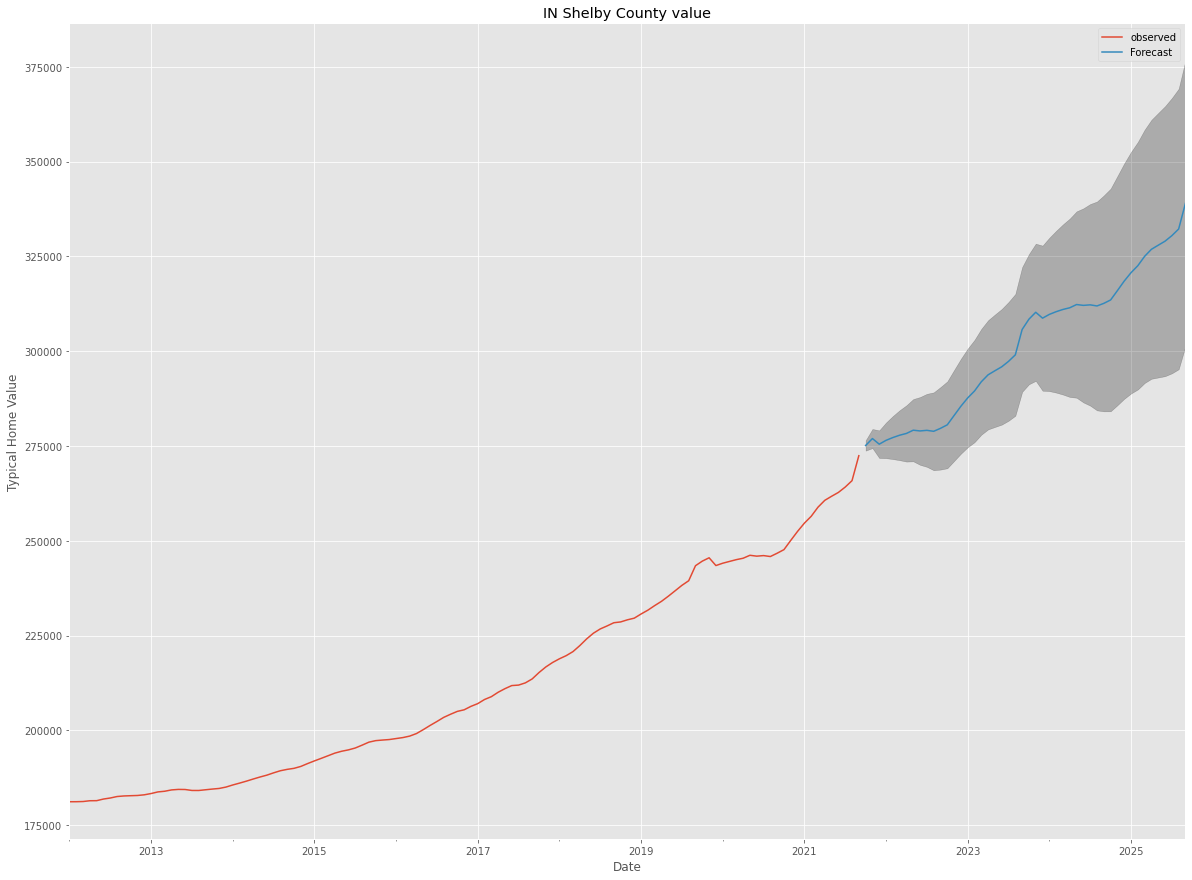

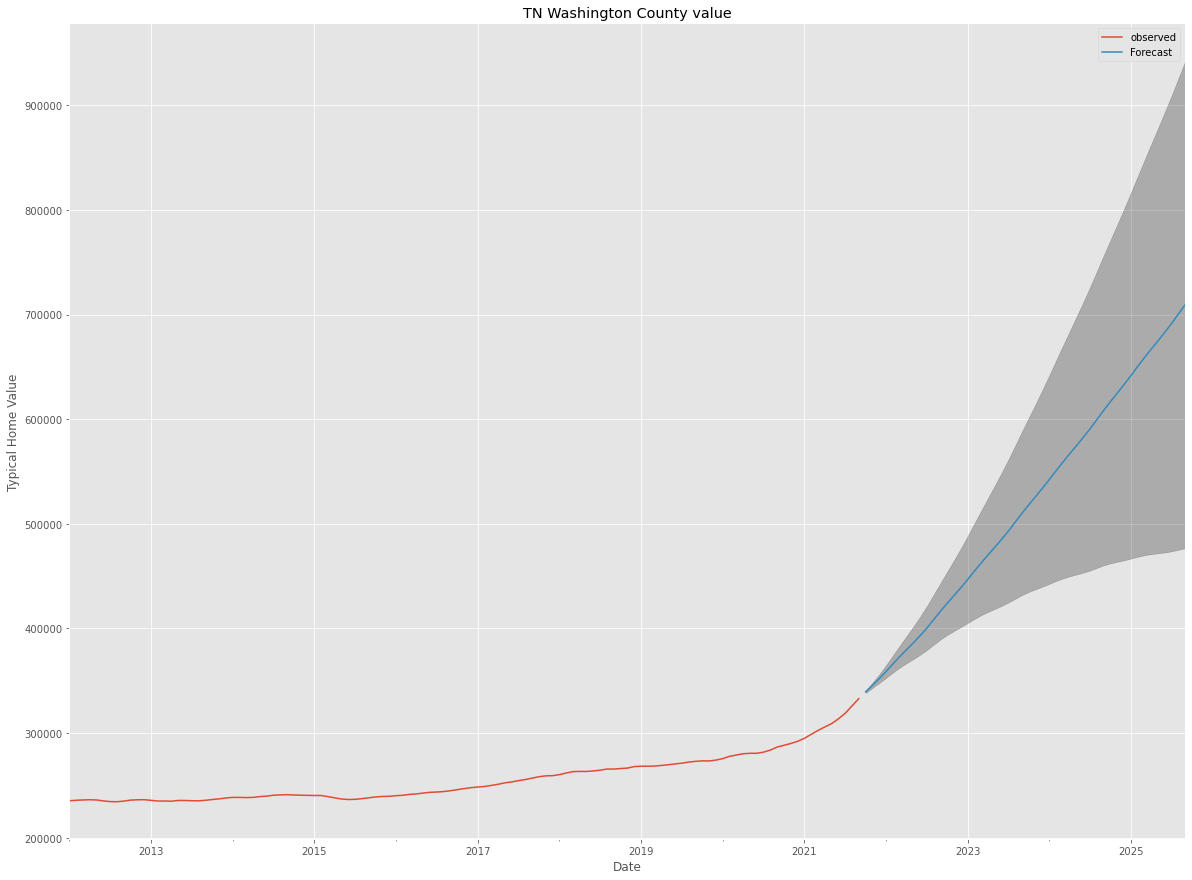

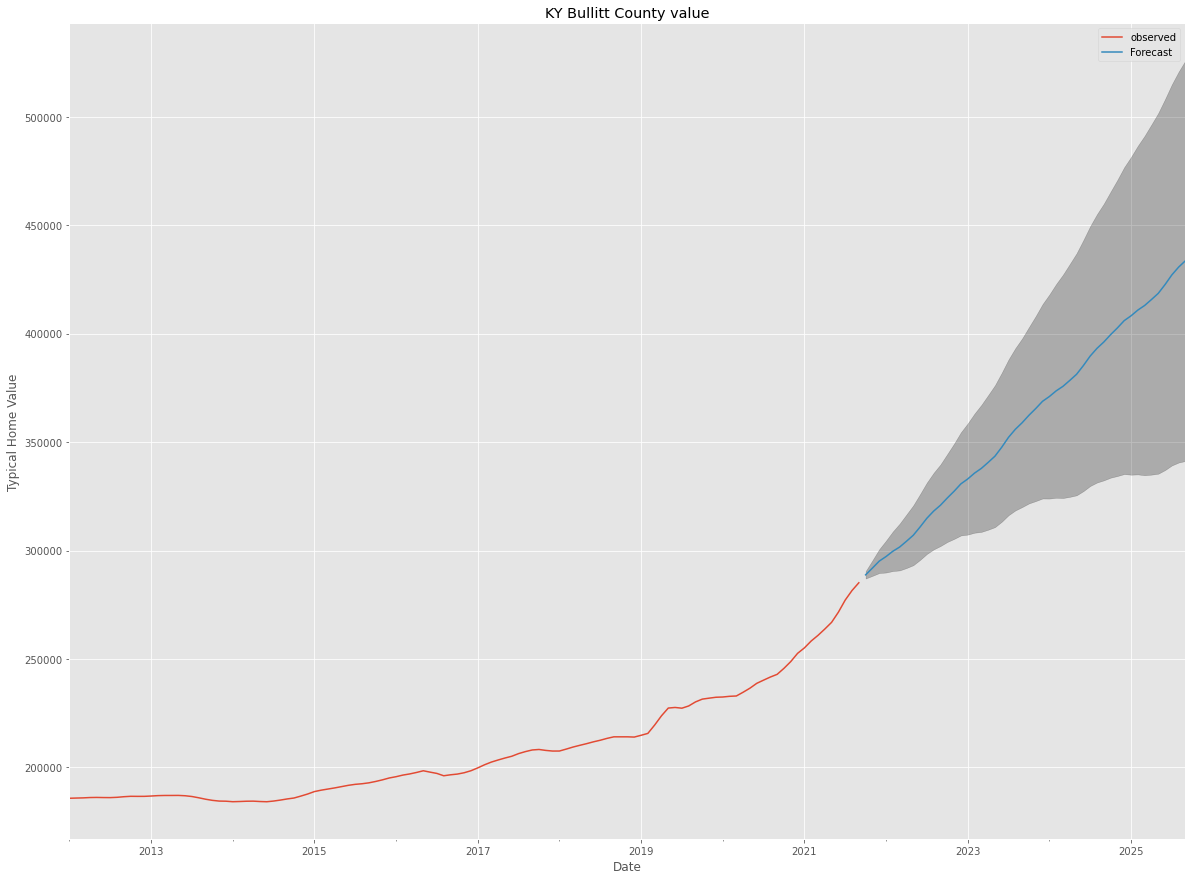

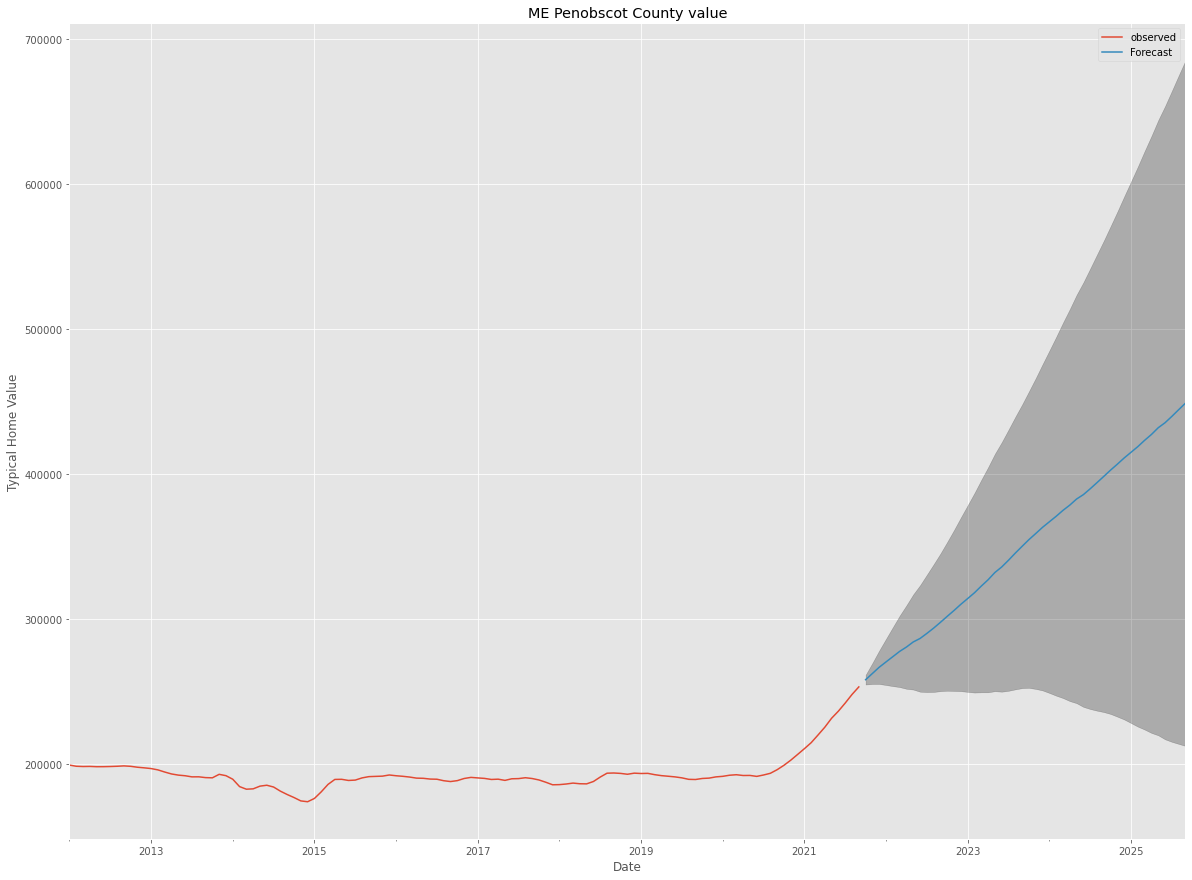

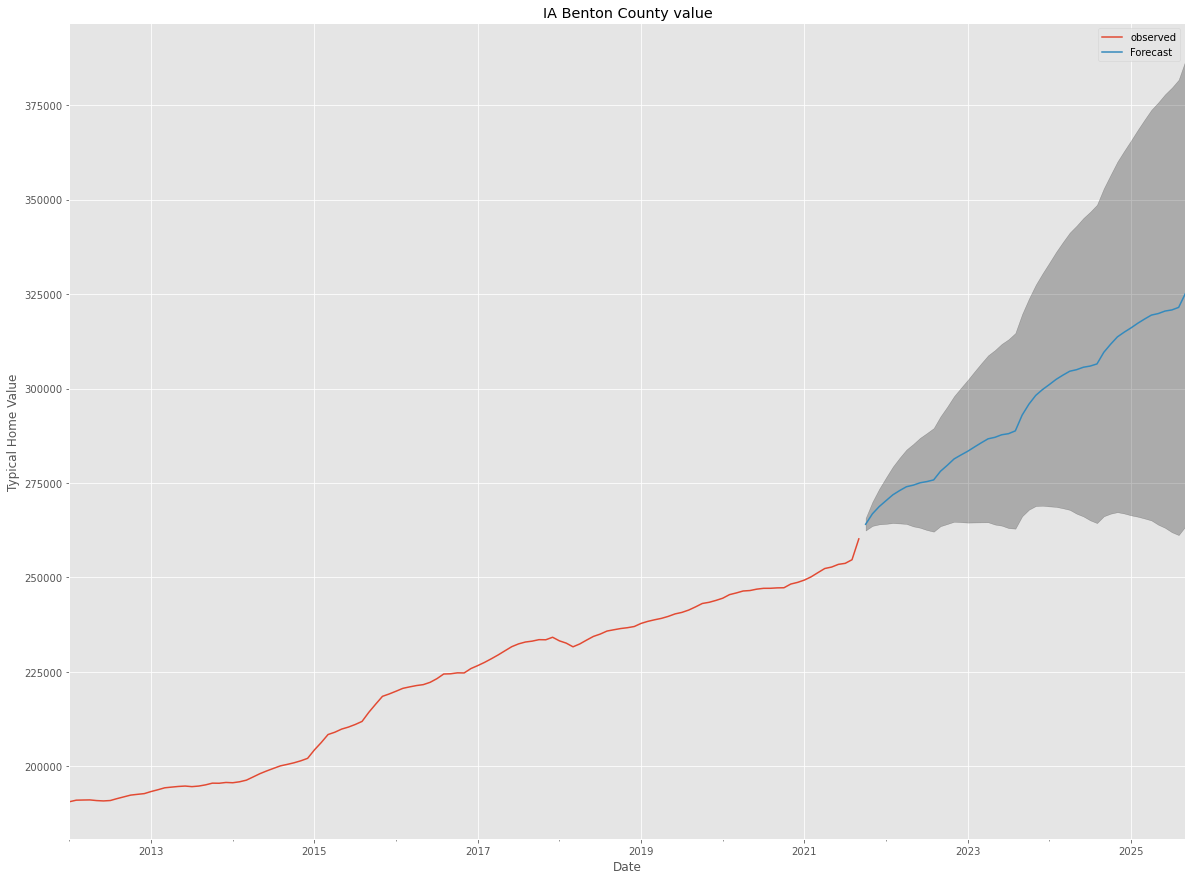

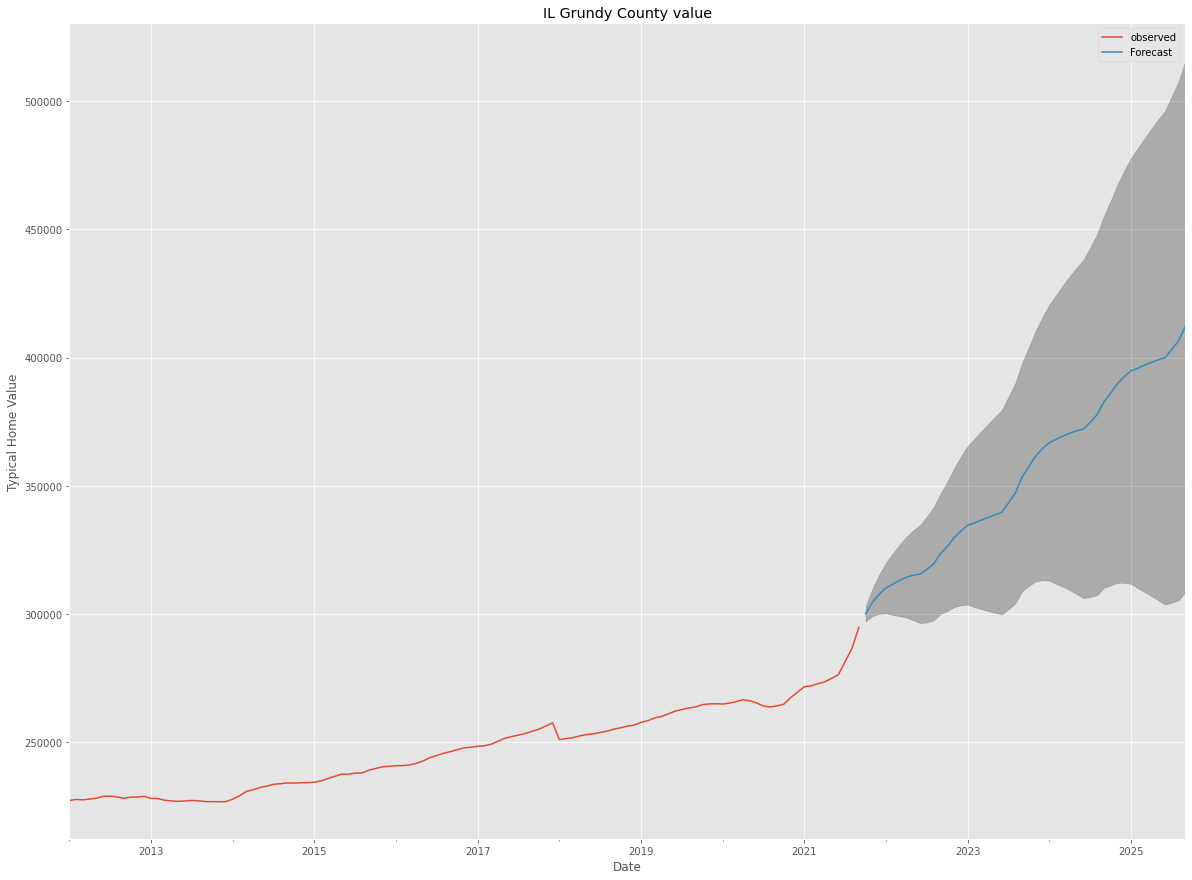

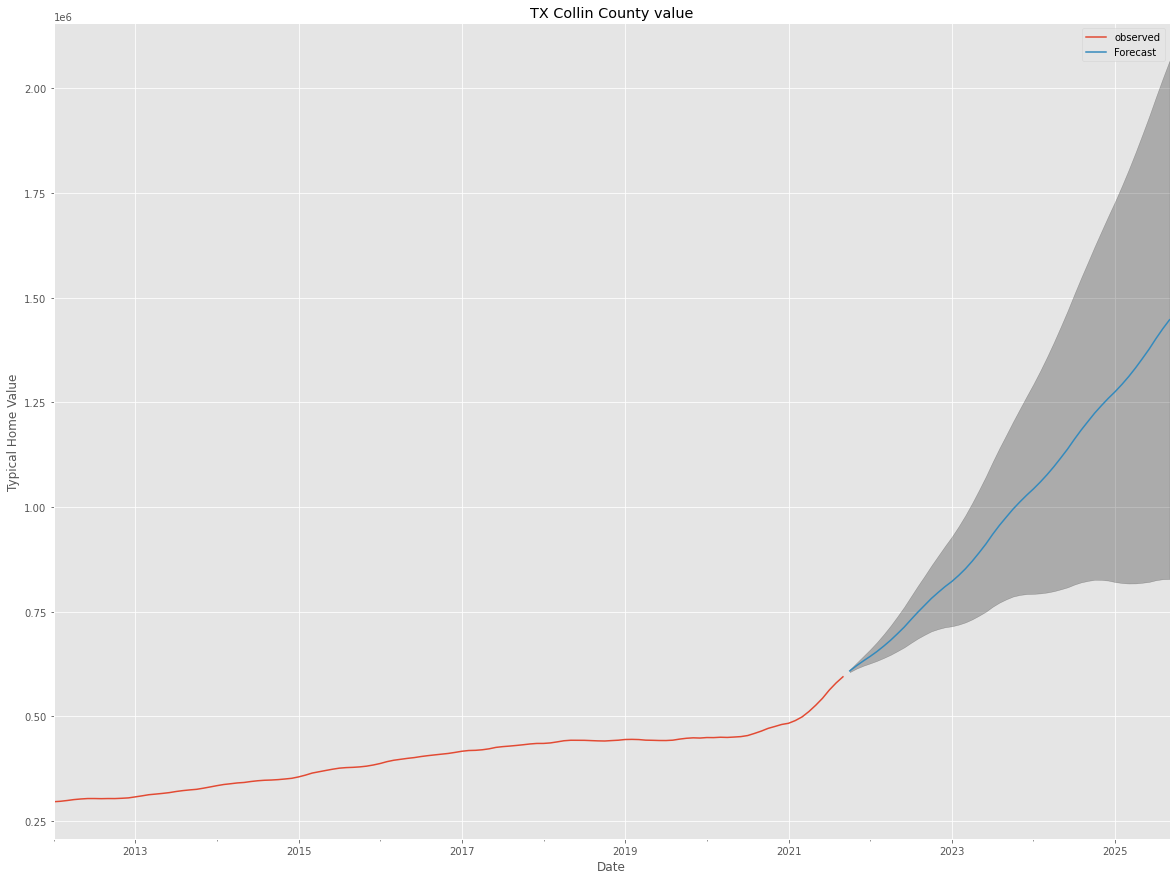

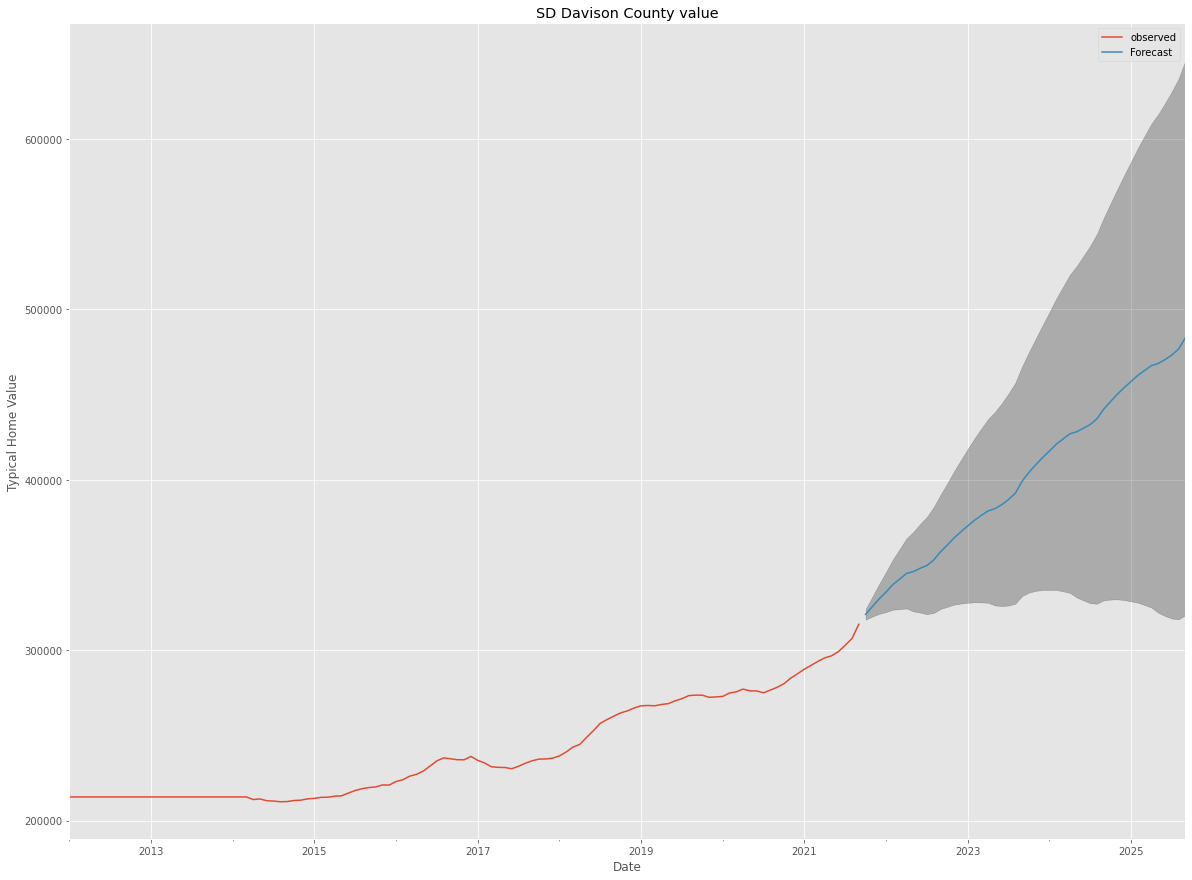

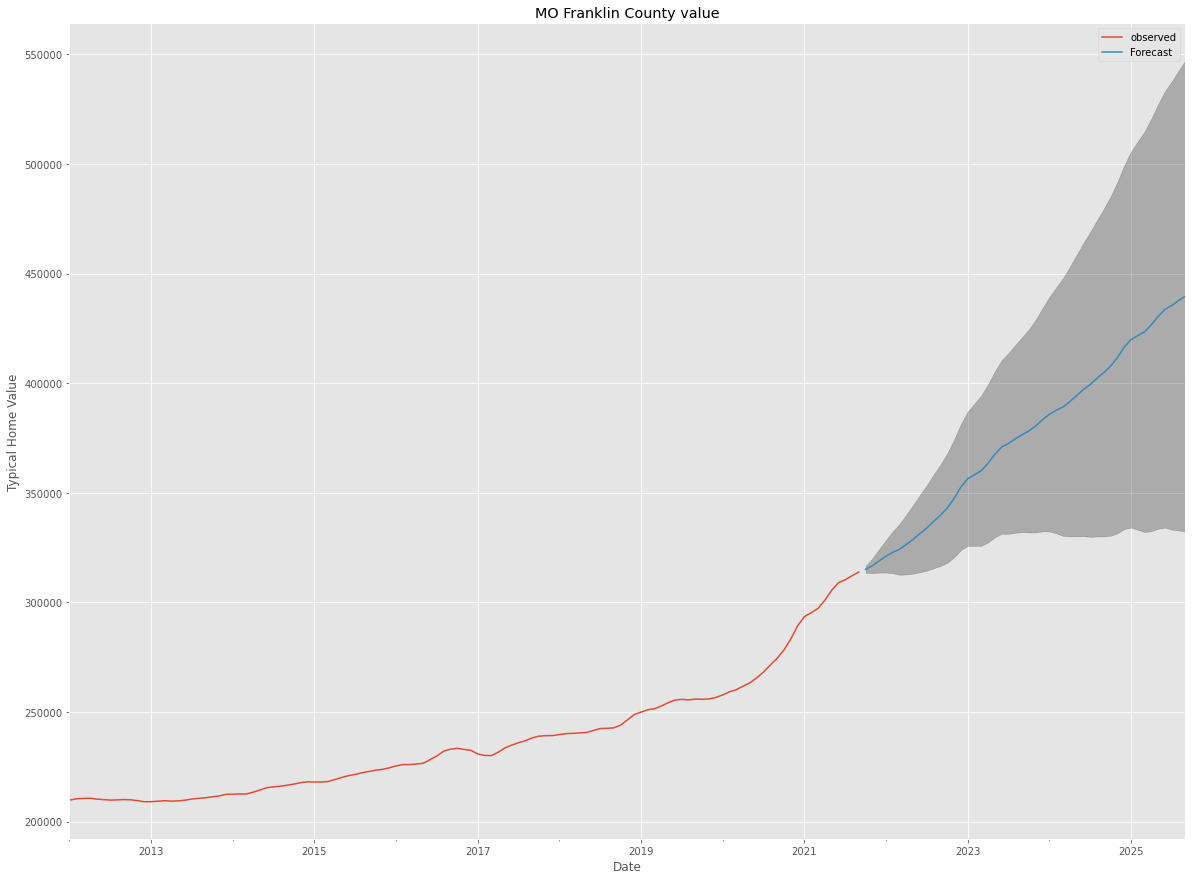

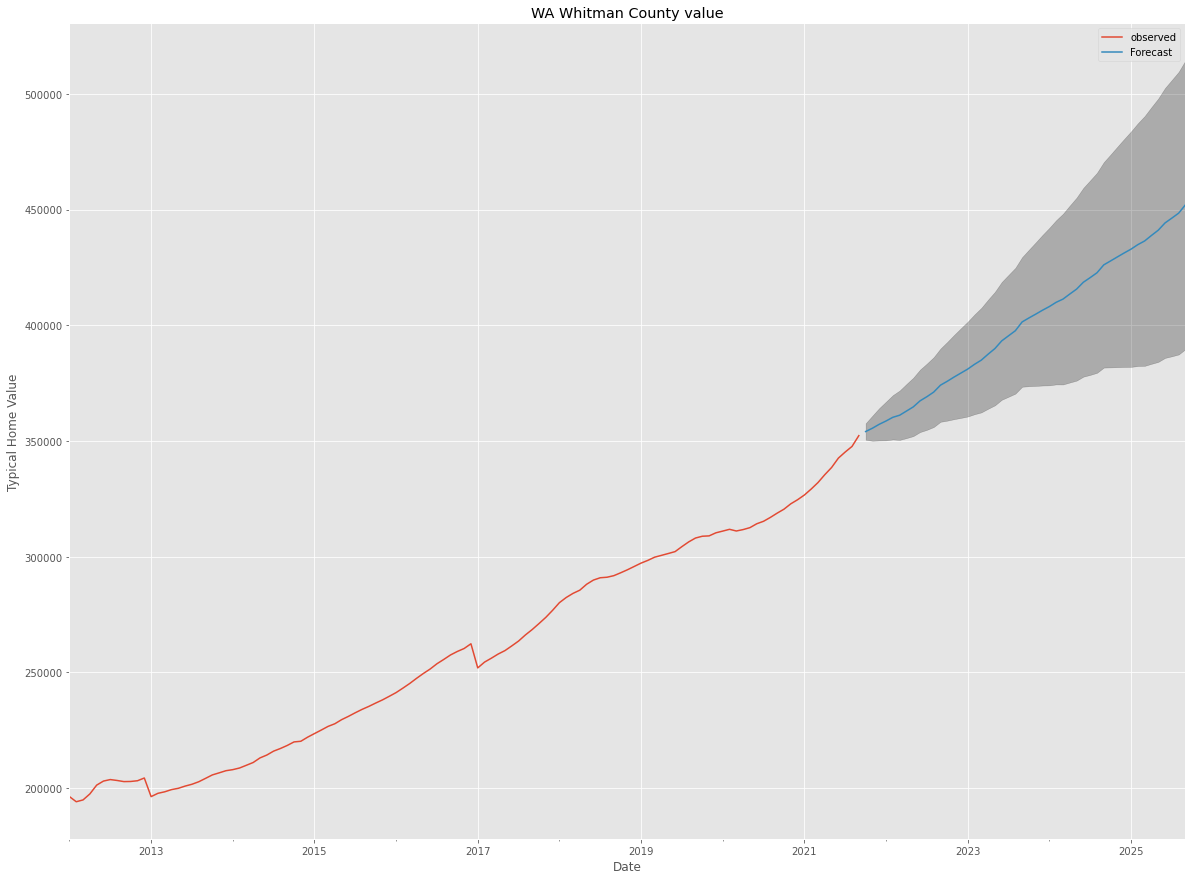

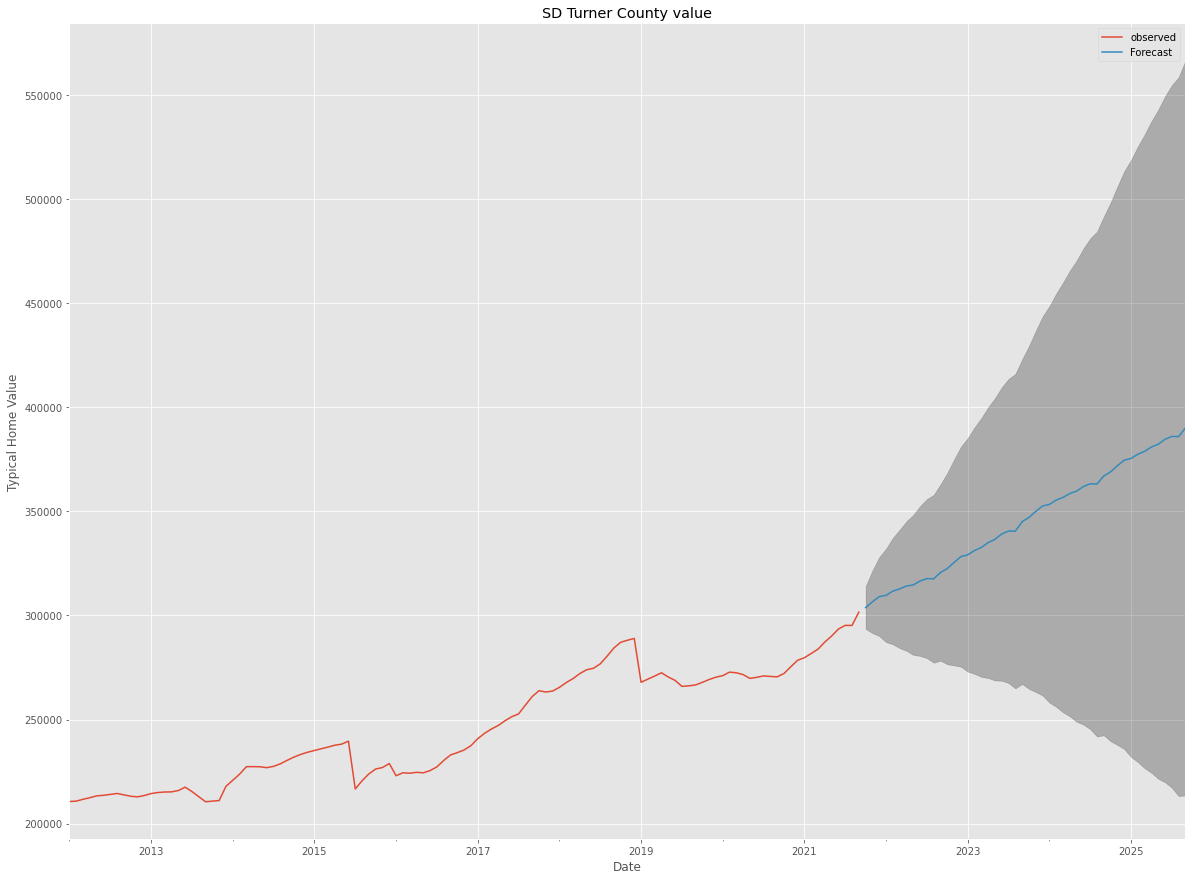

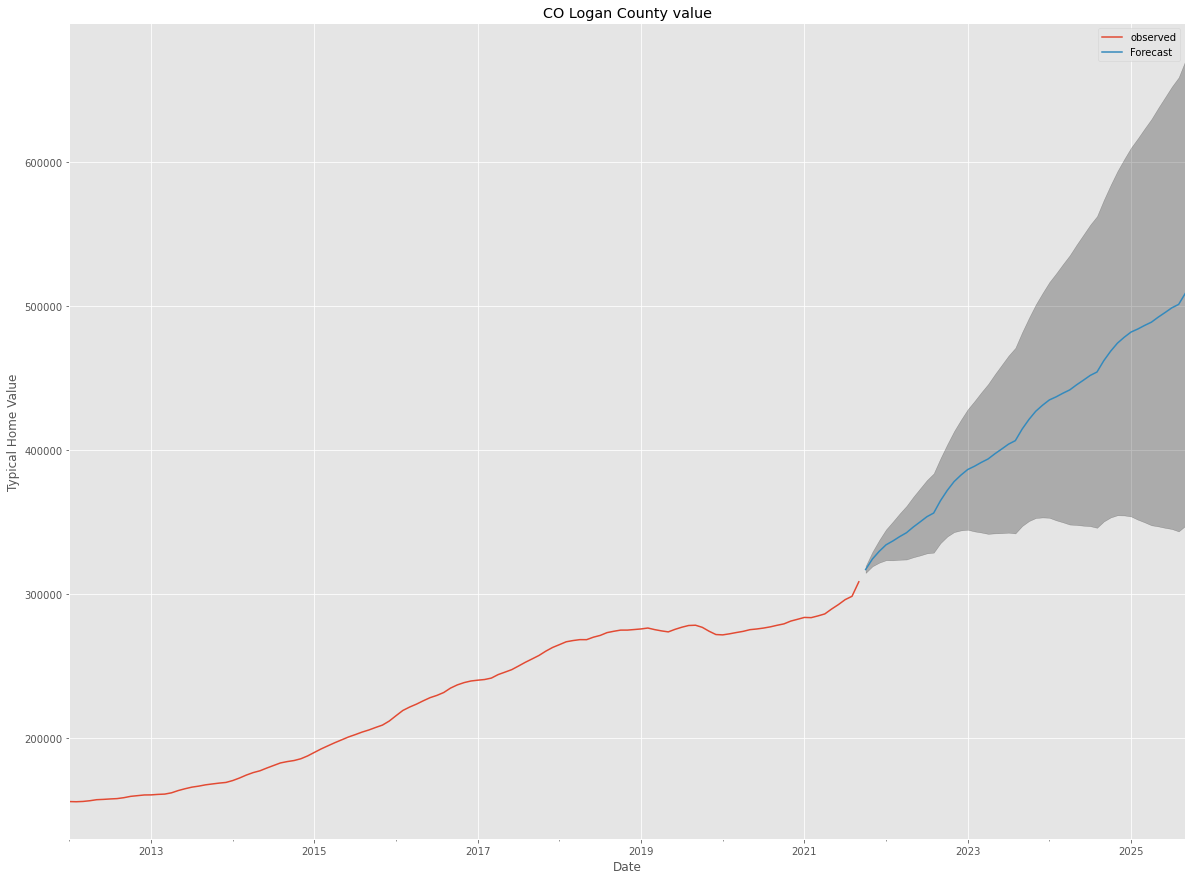

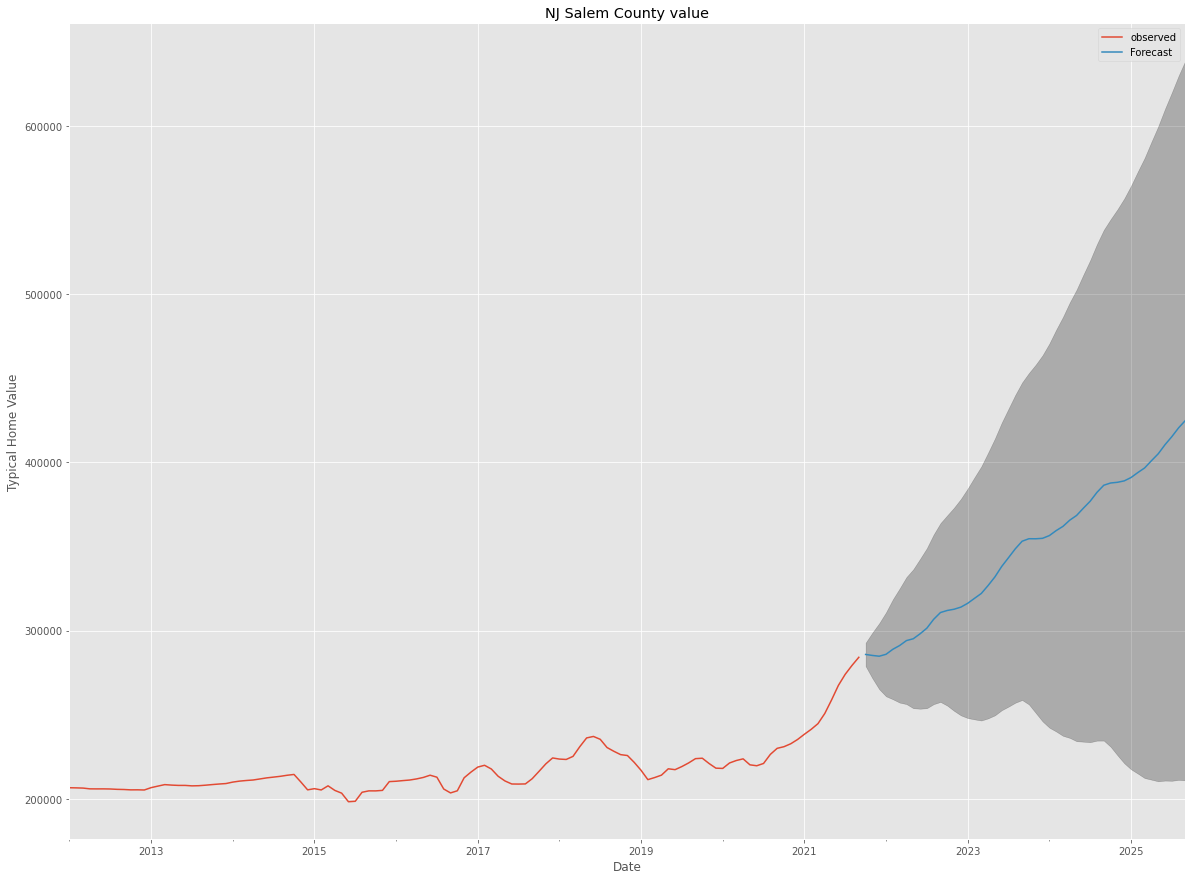

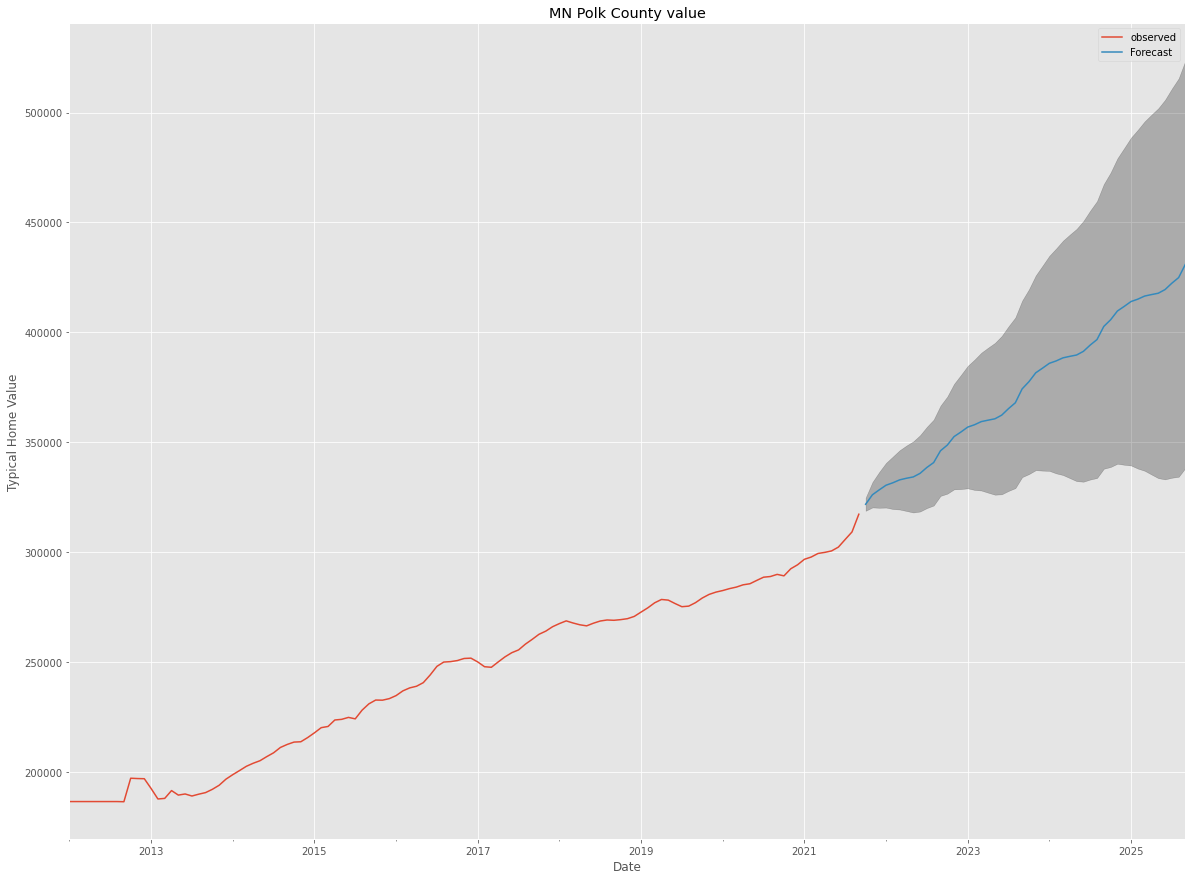

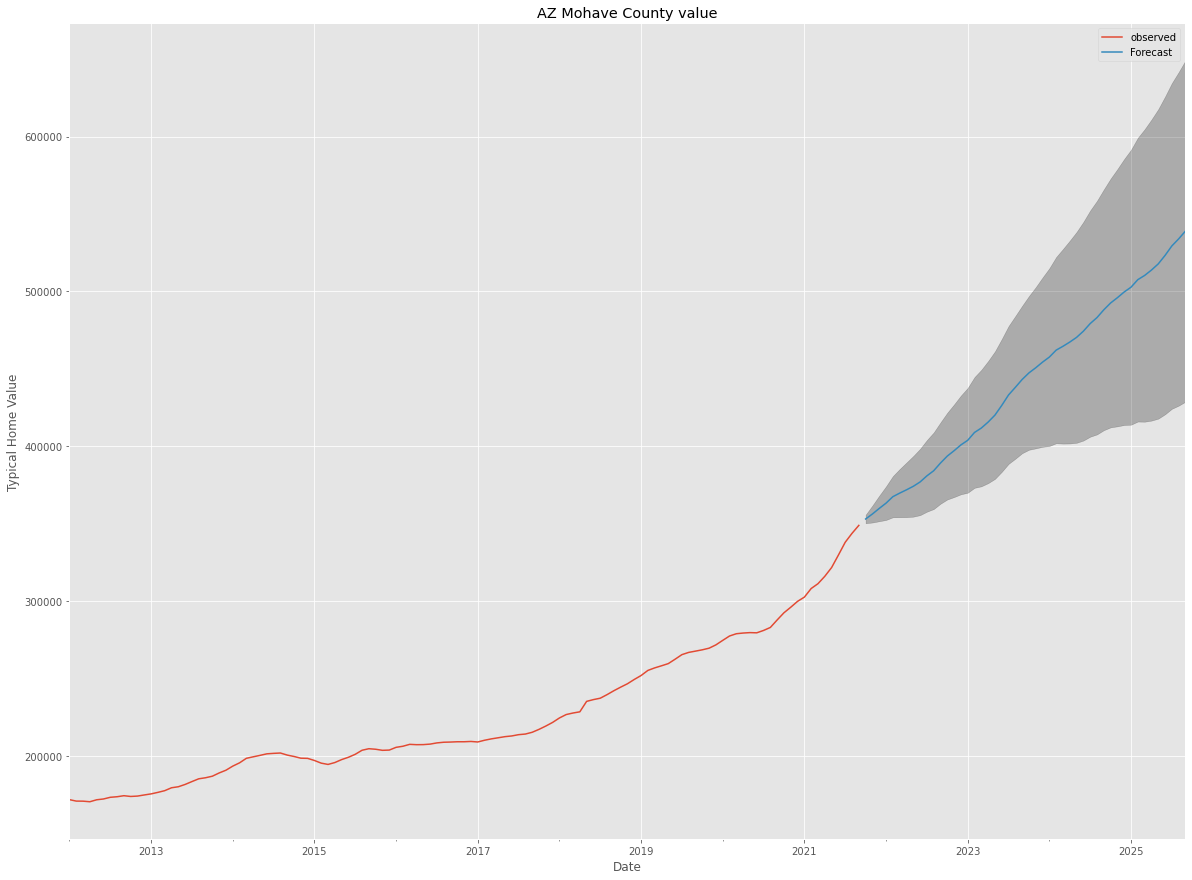

In [22]:
for i in range(len(pre_models)):
    generate_forecast(pre_models[i], final_ts.columns[i], final_ts)

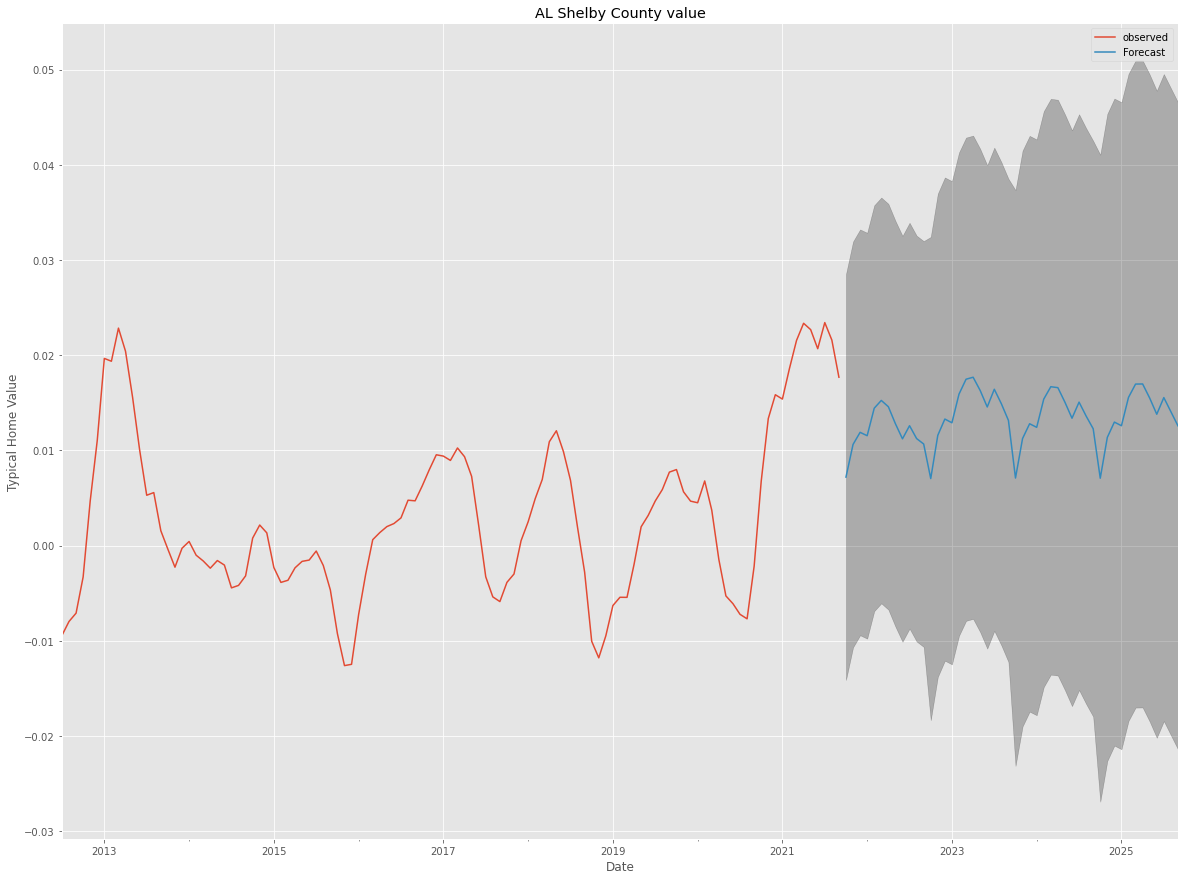

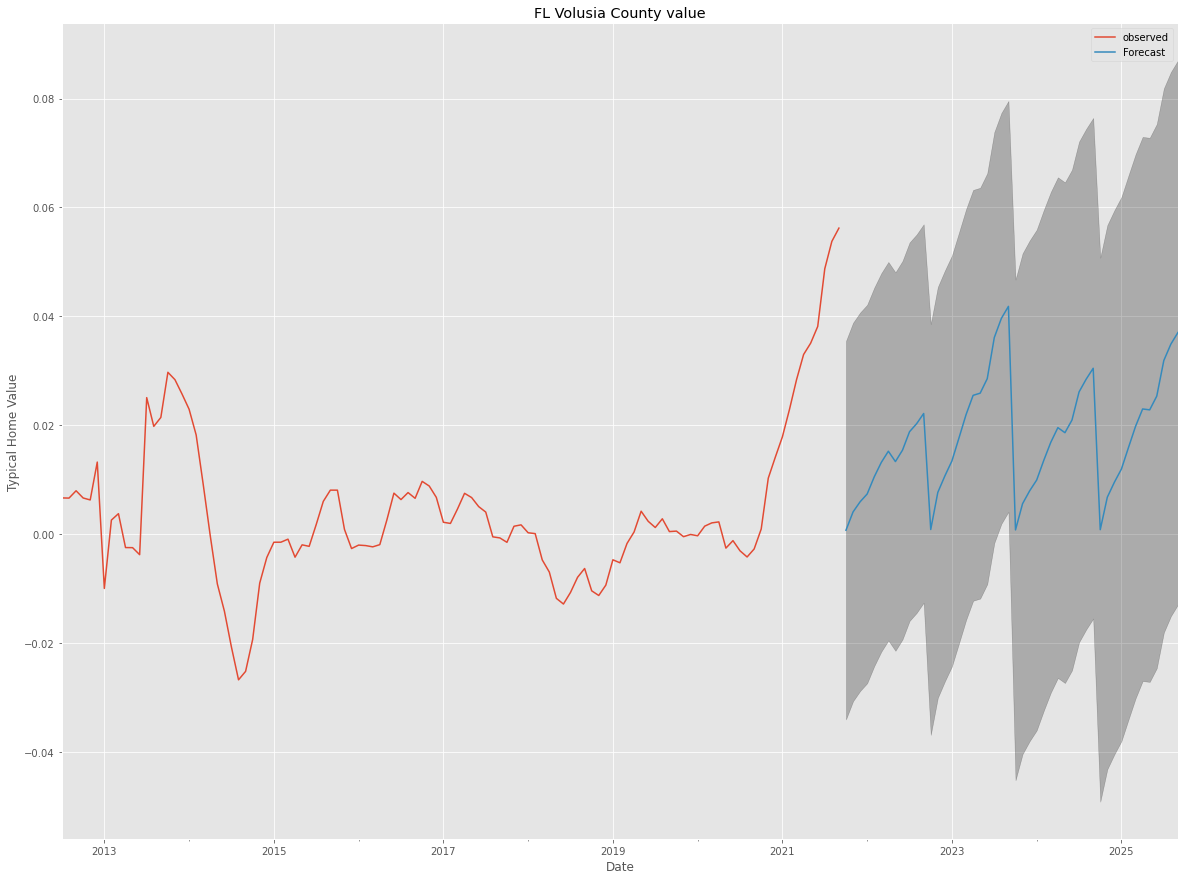

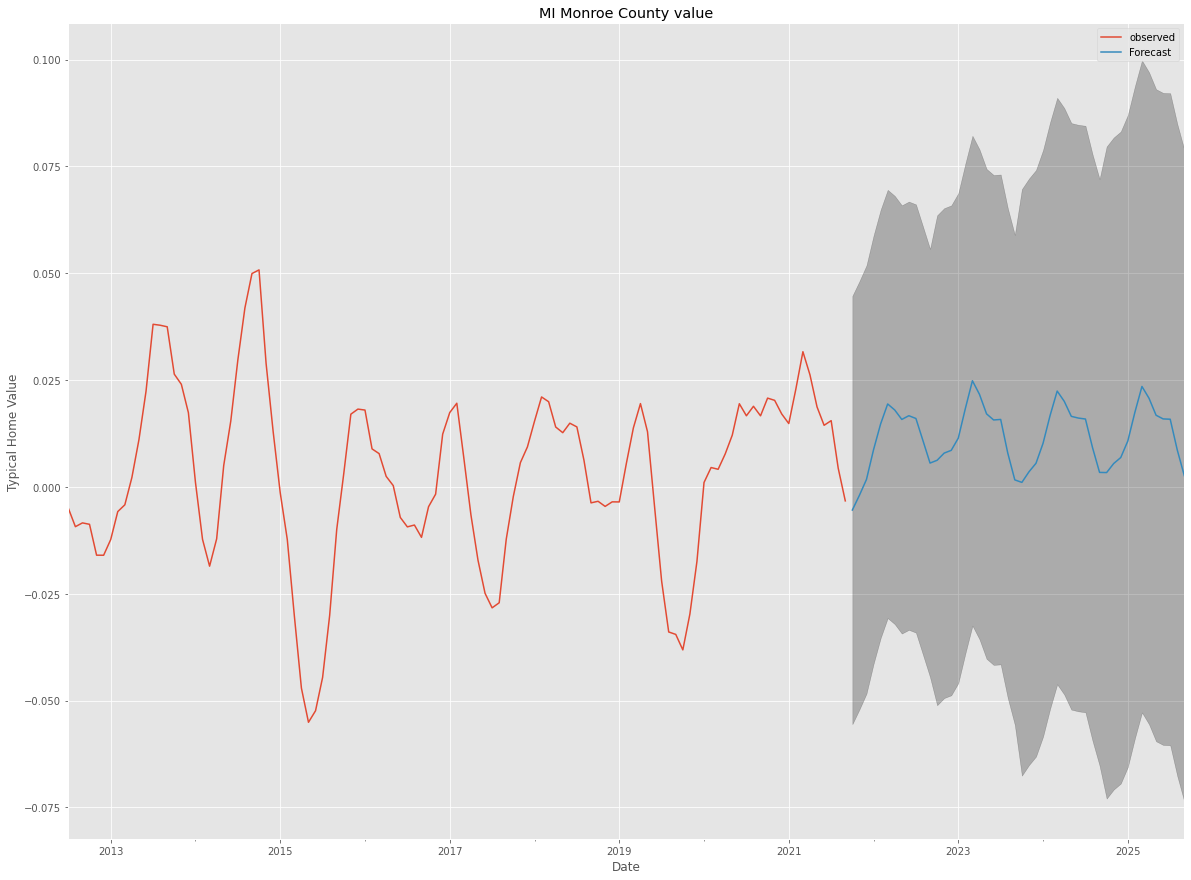

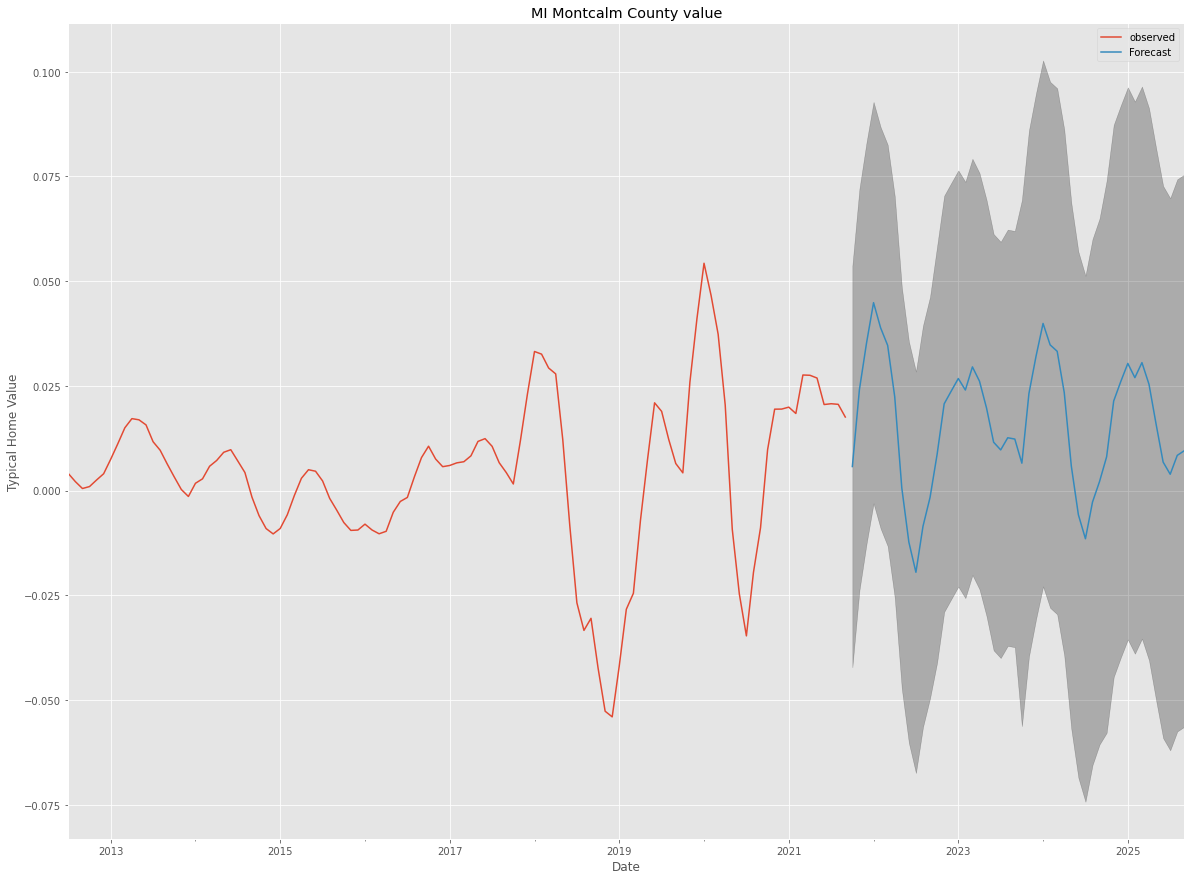

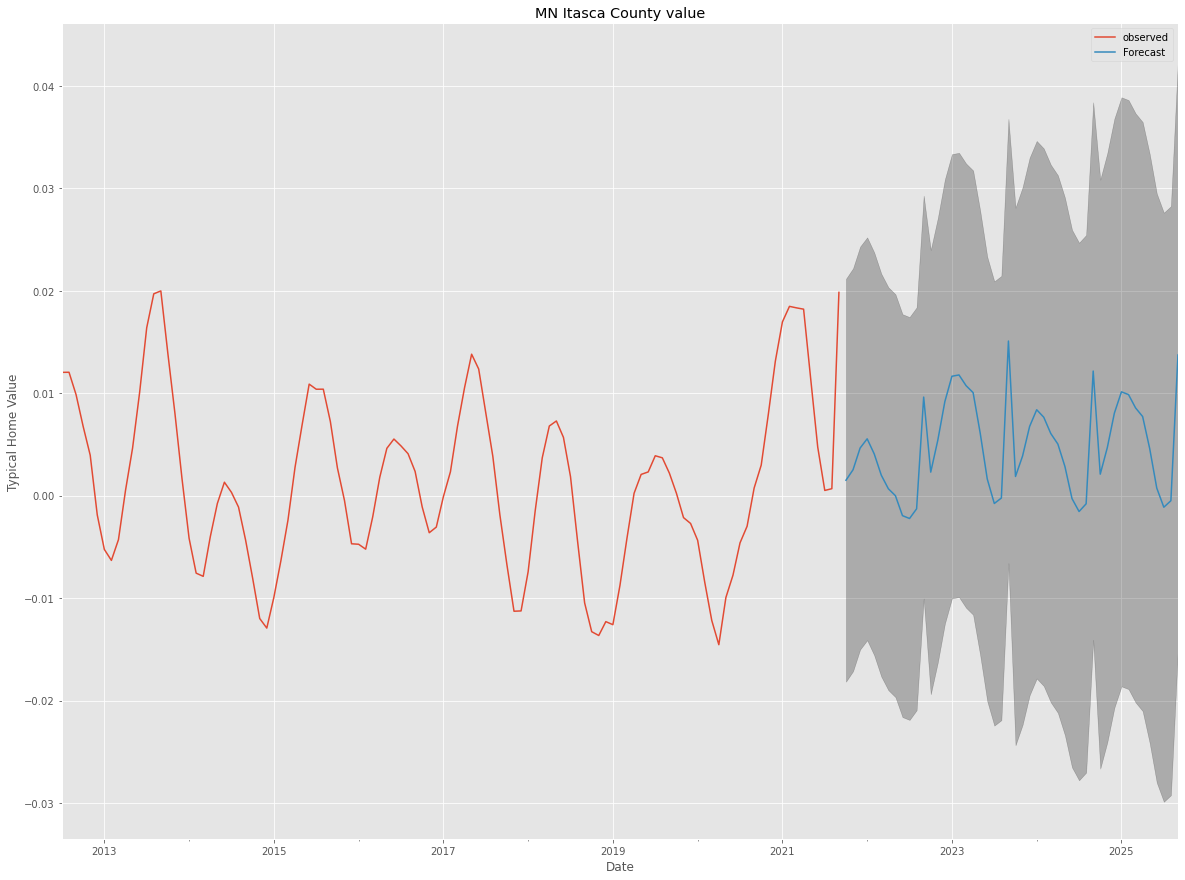

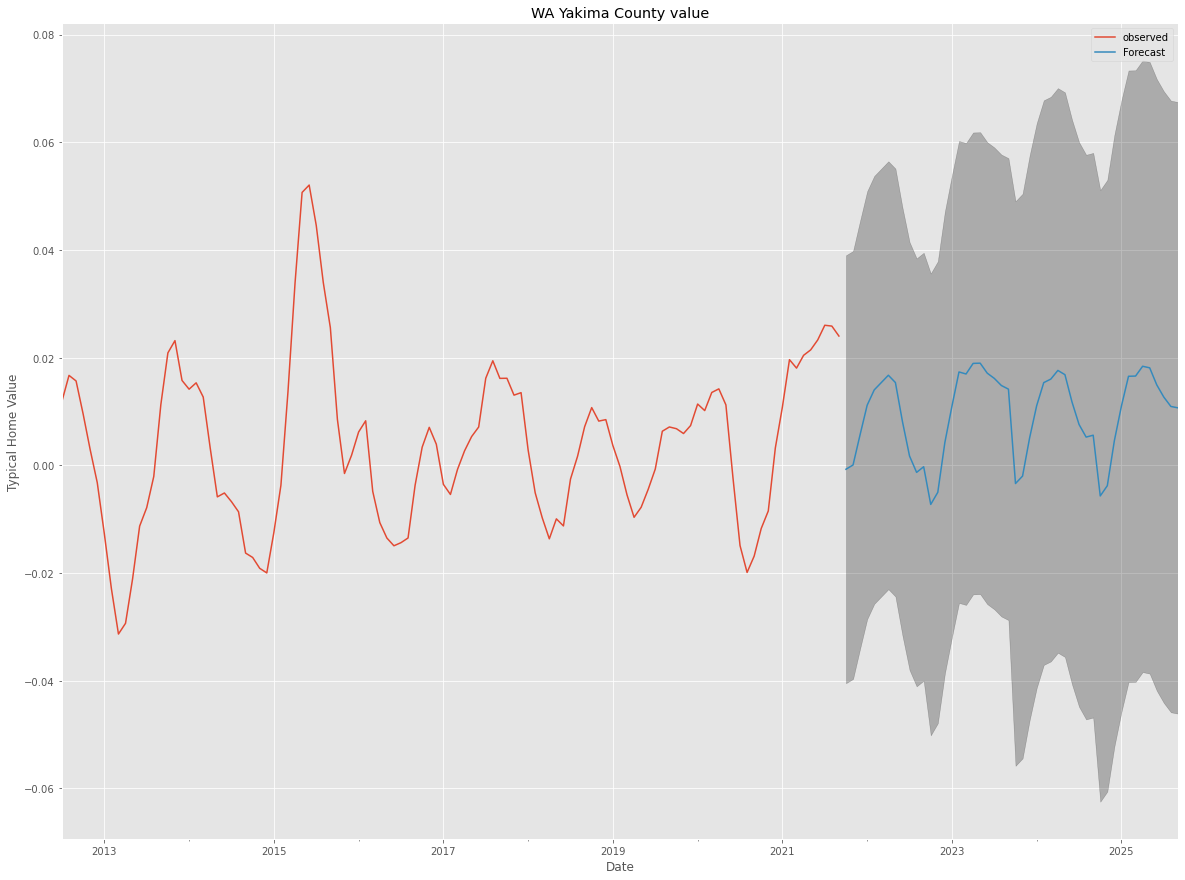

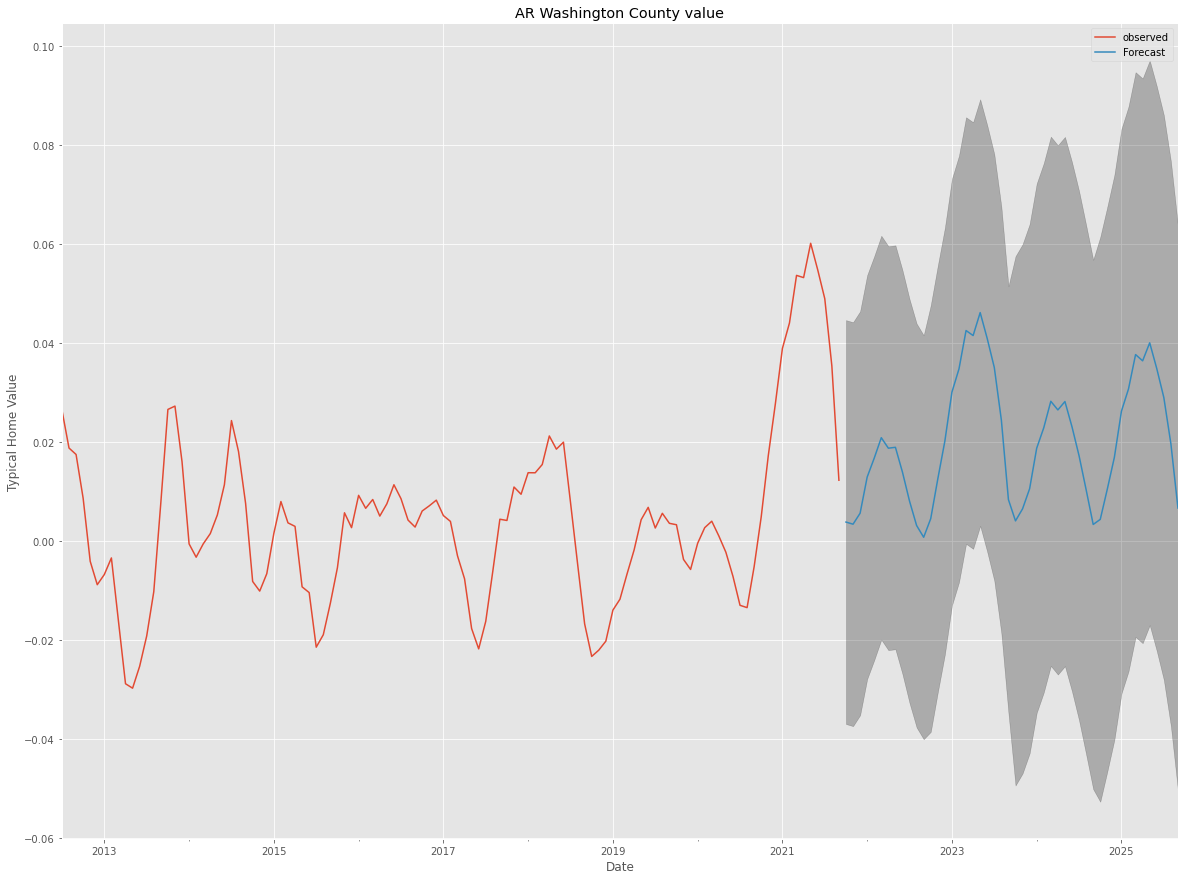

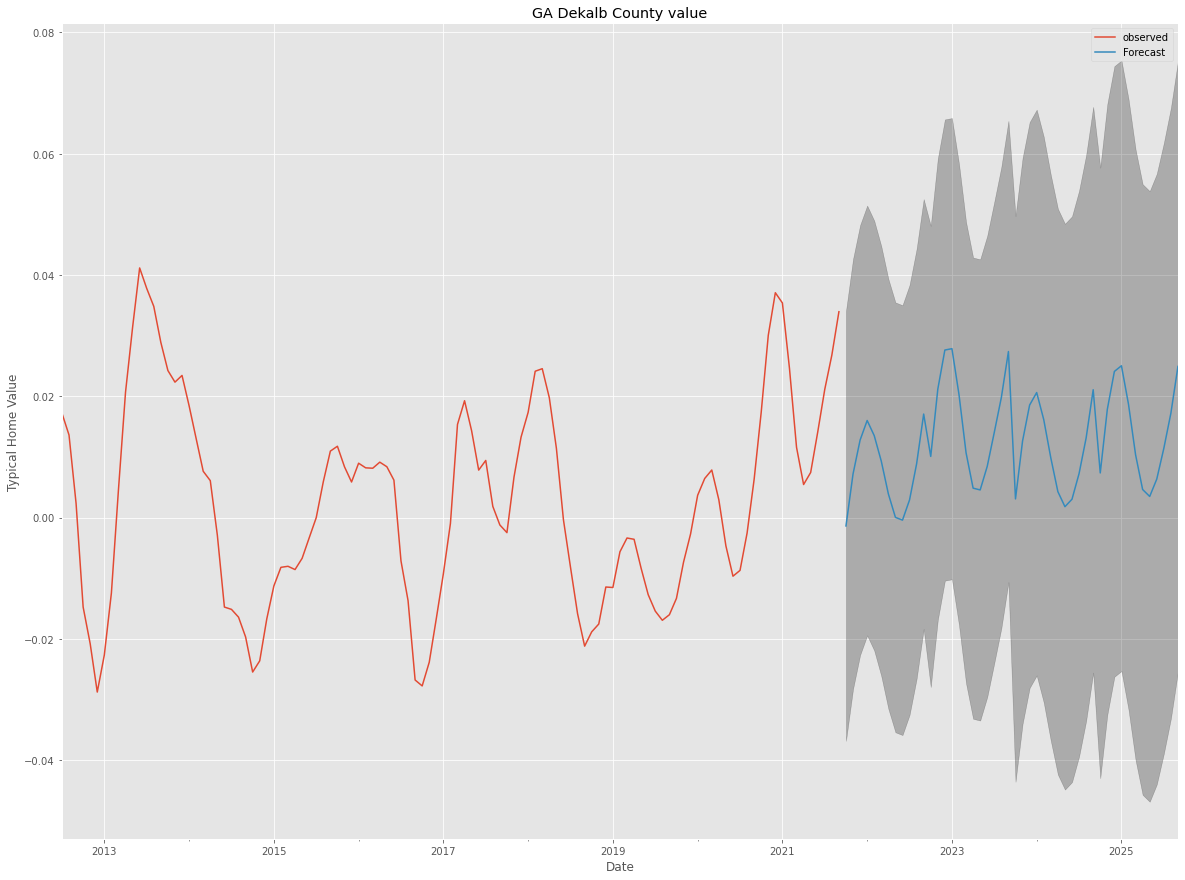

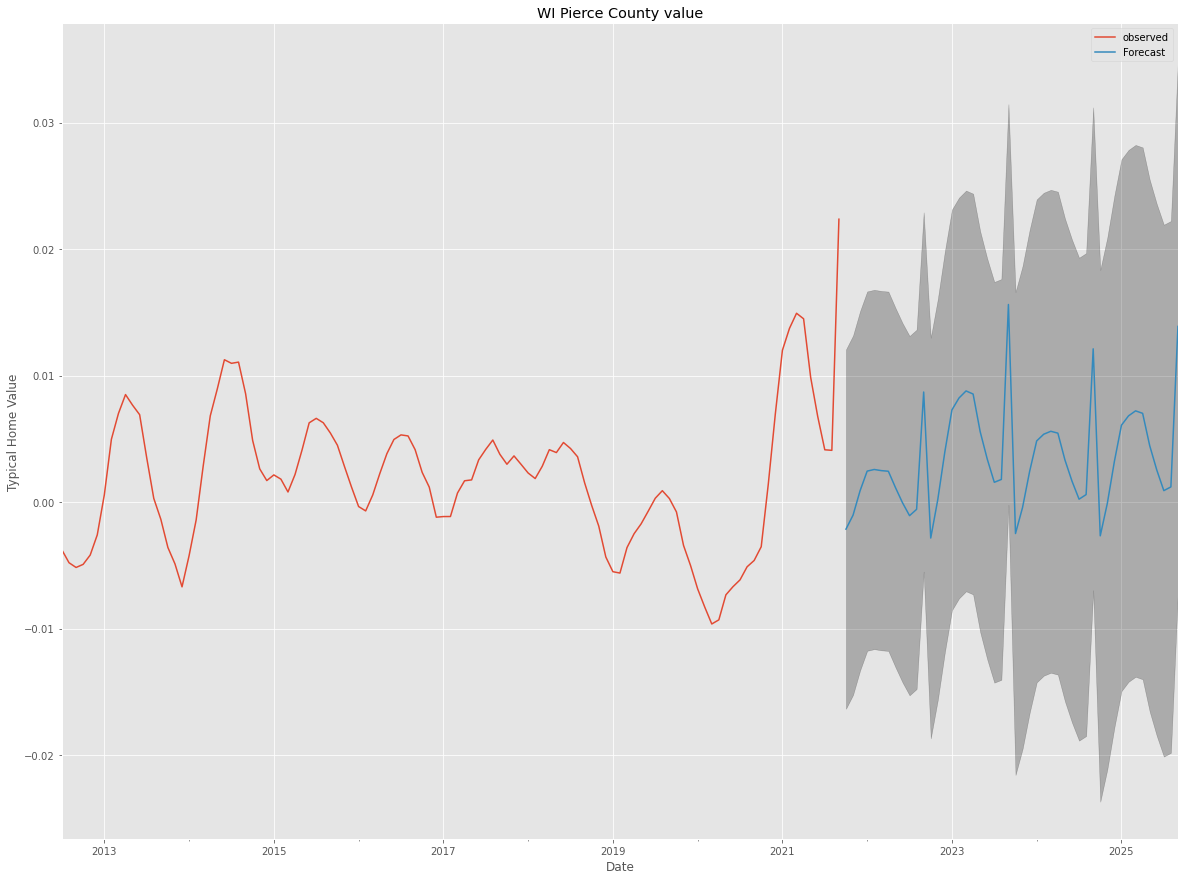

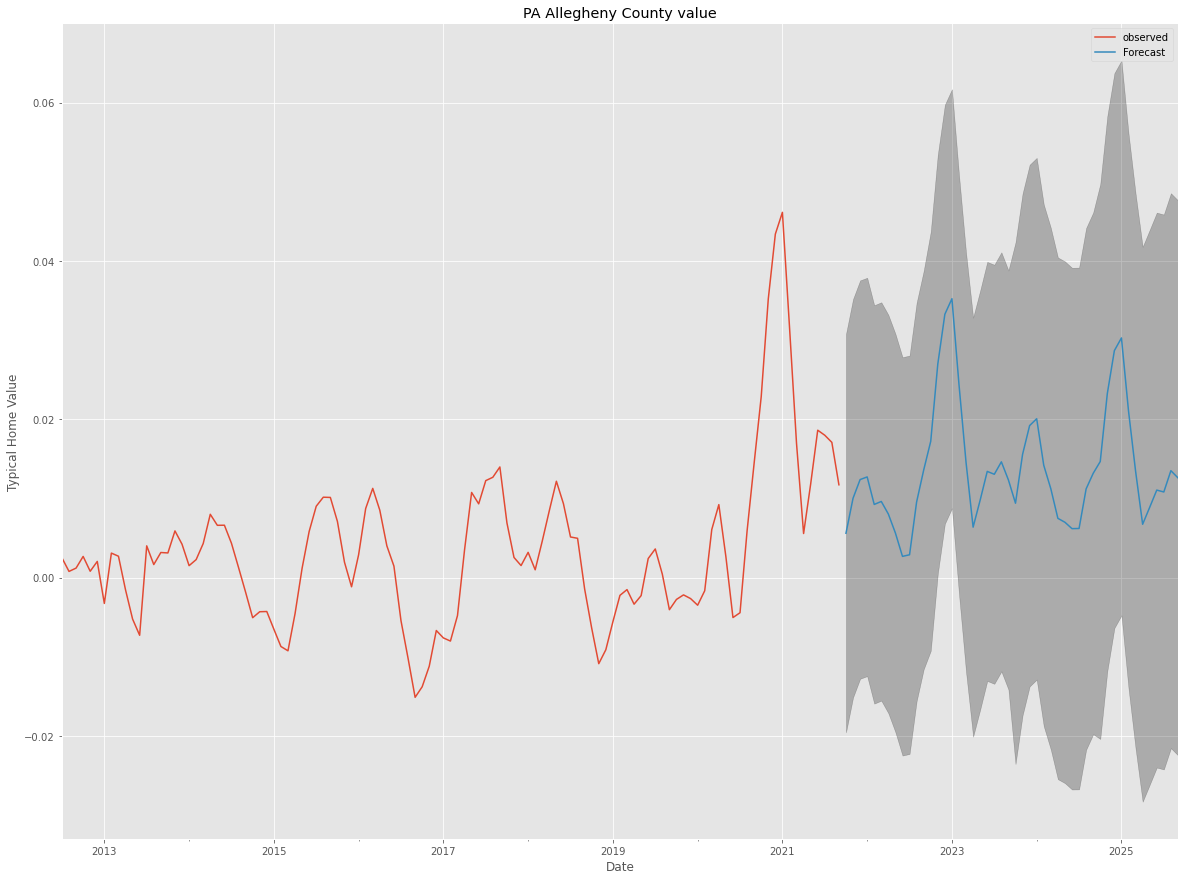

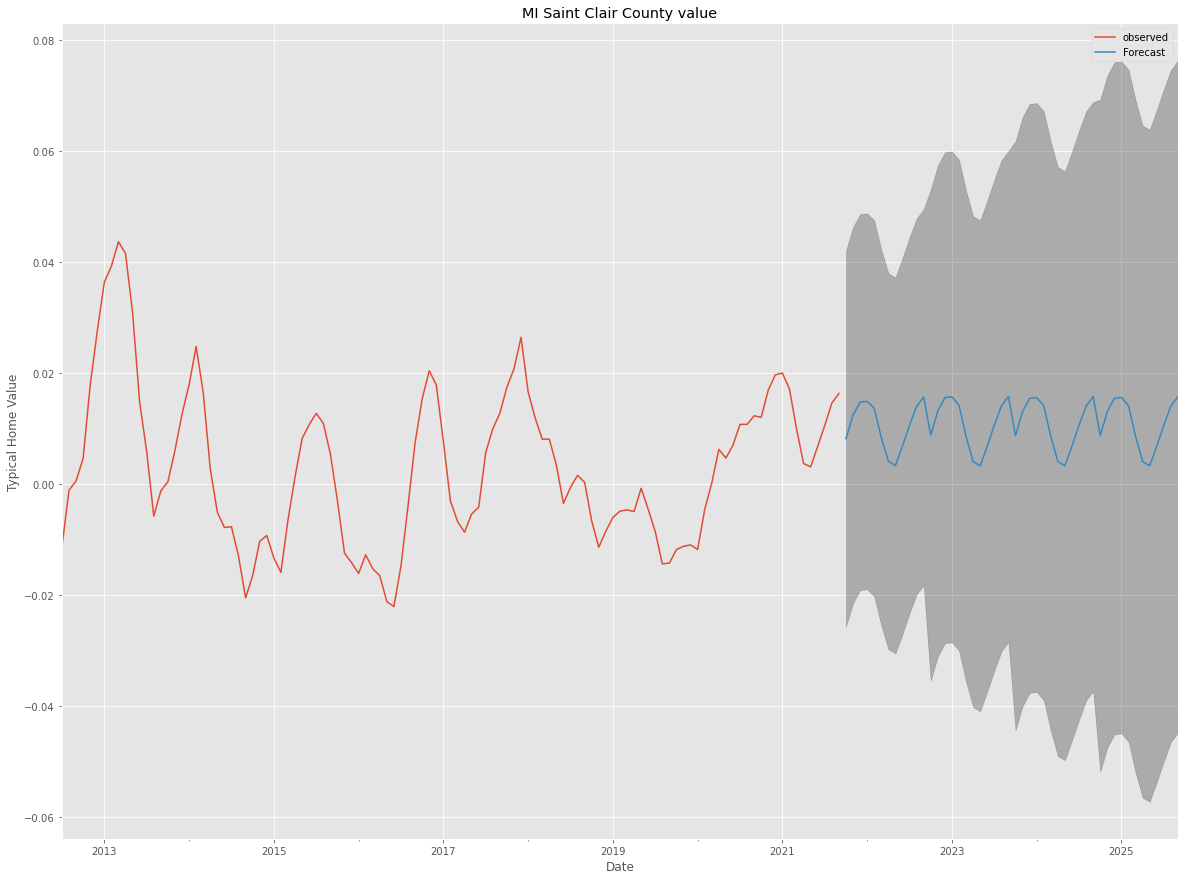

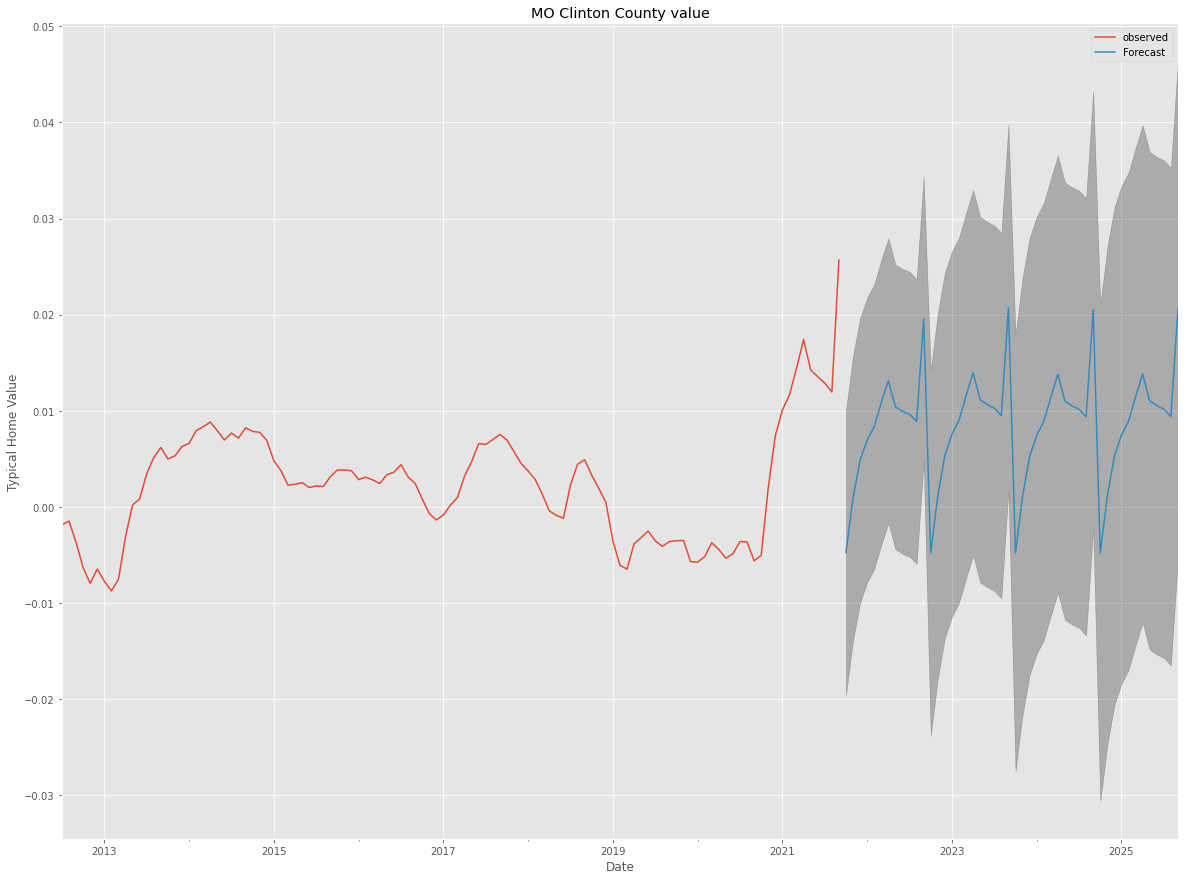

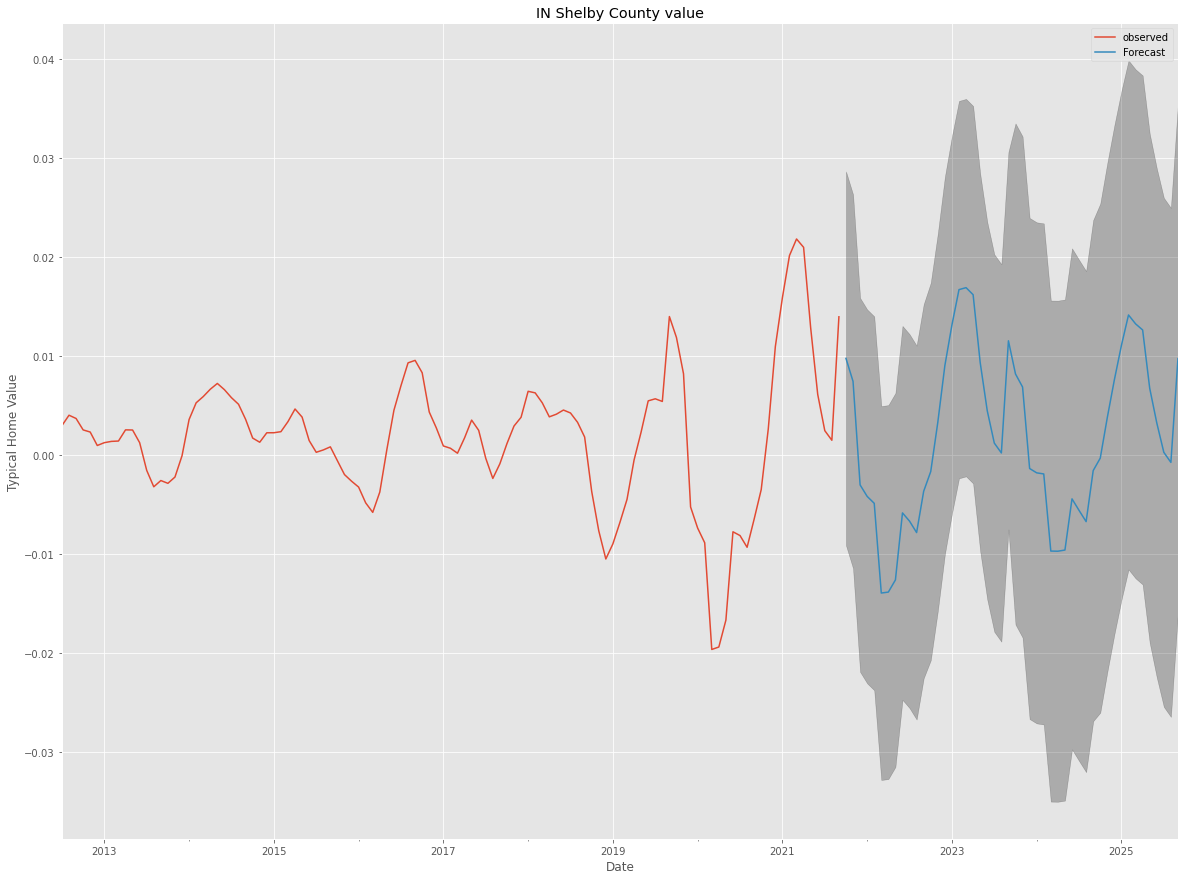

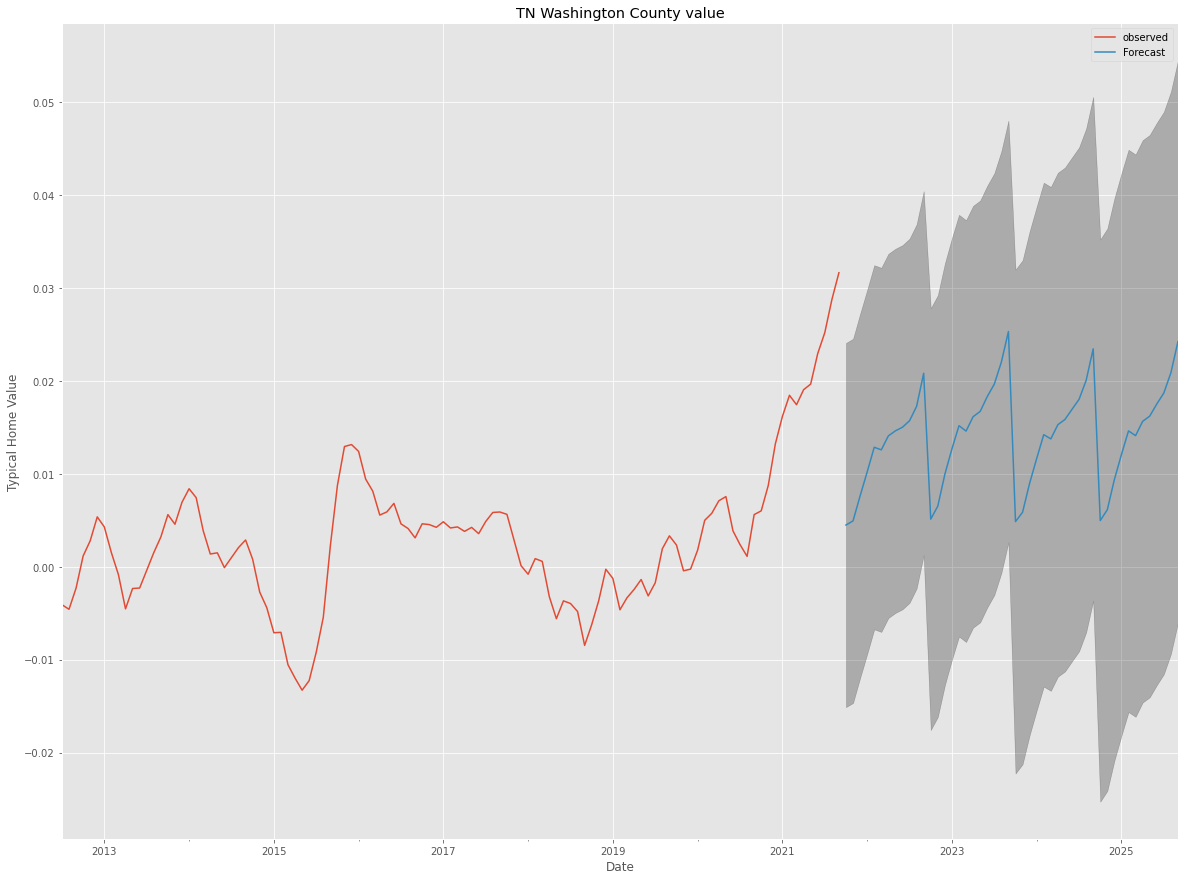

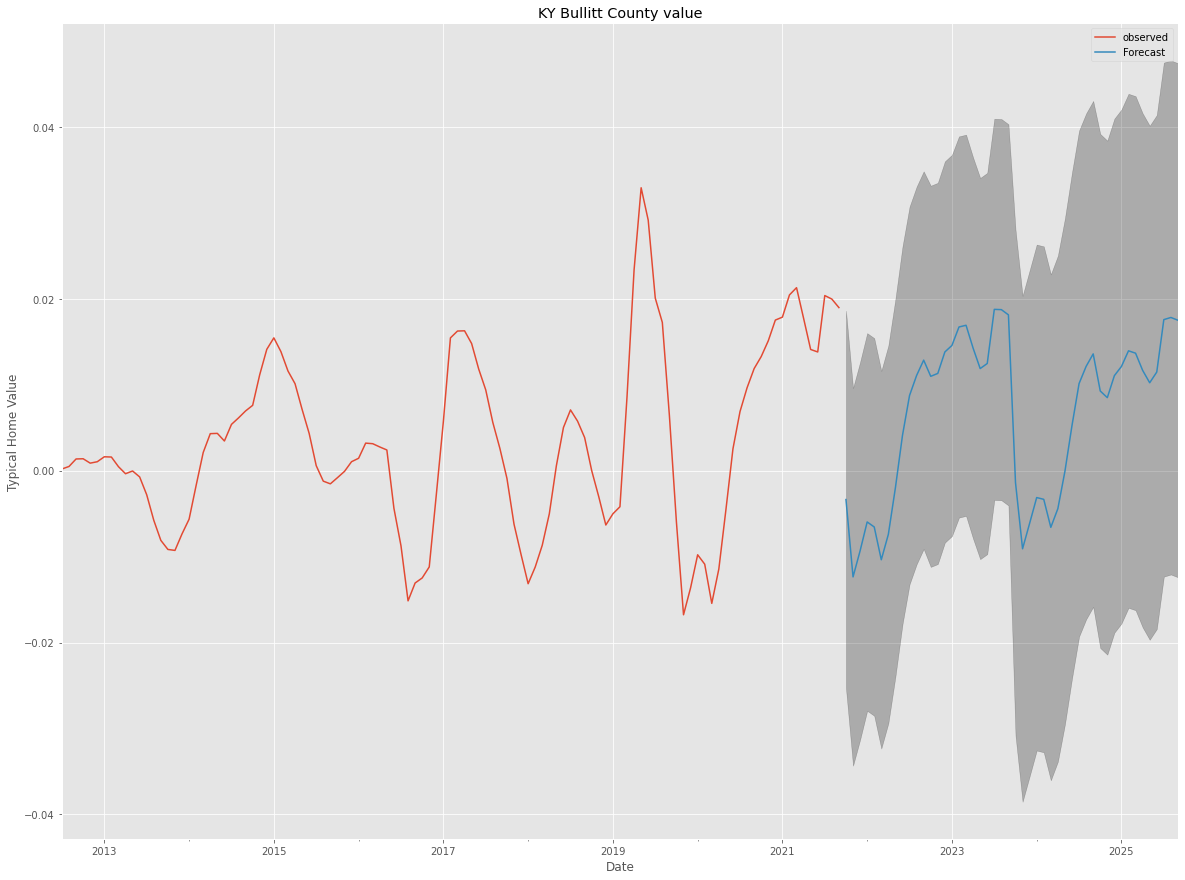

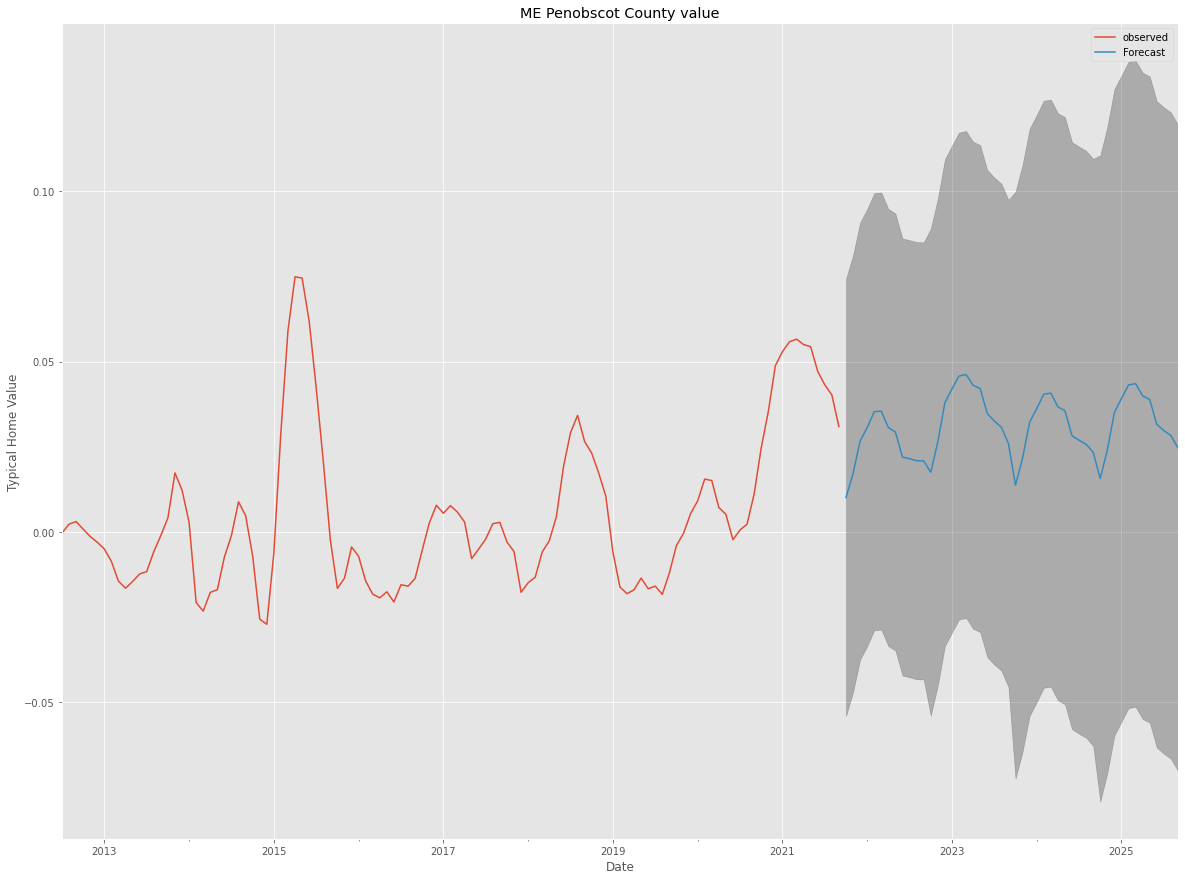

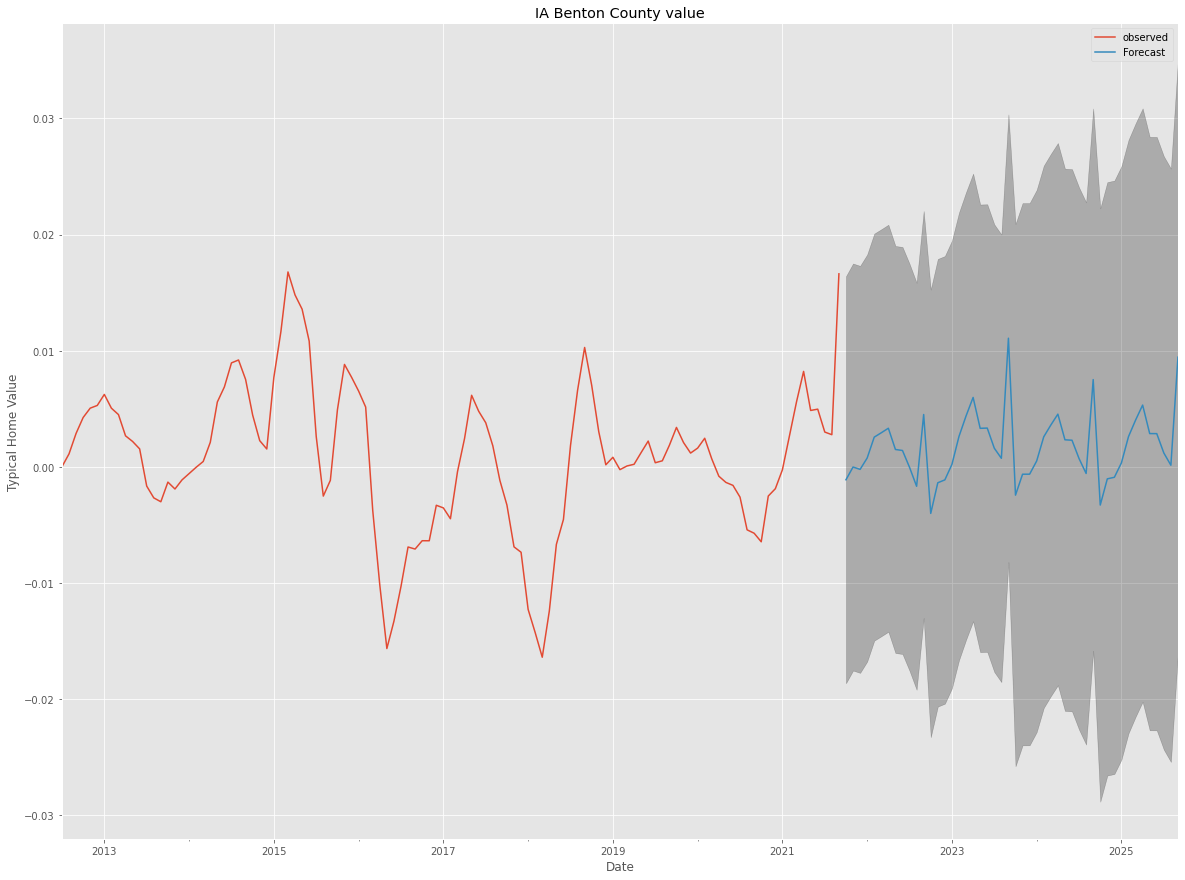

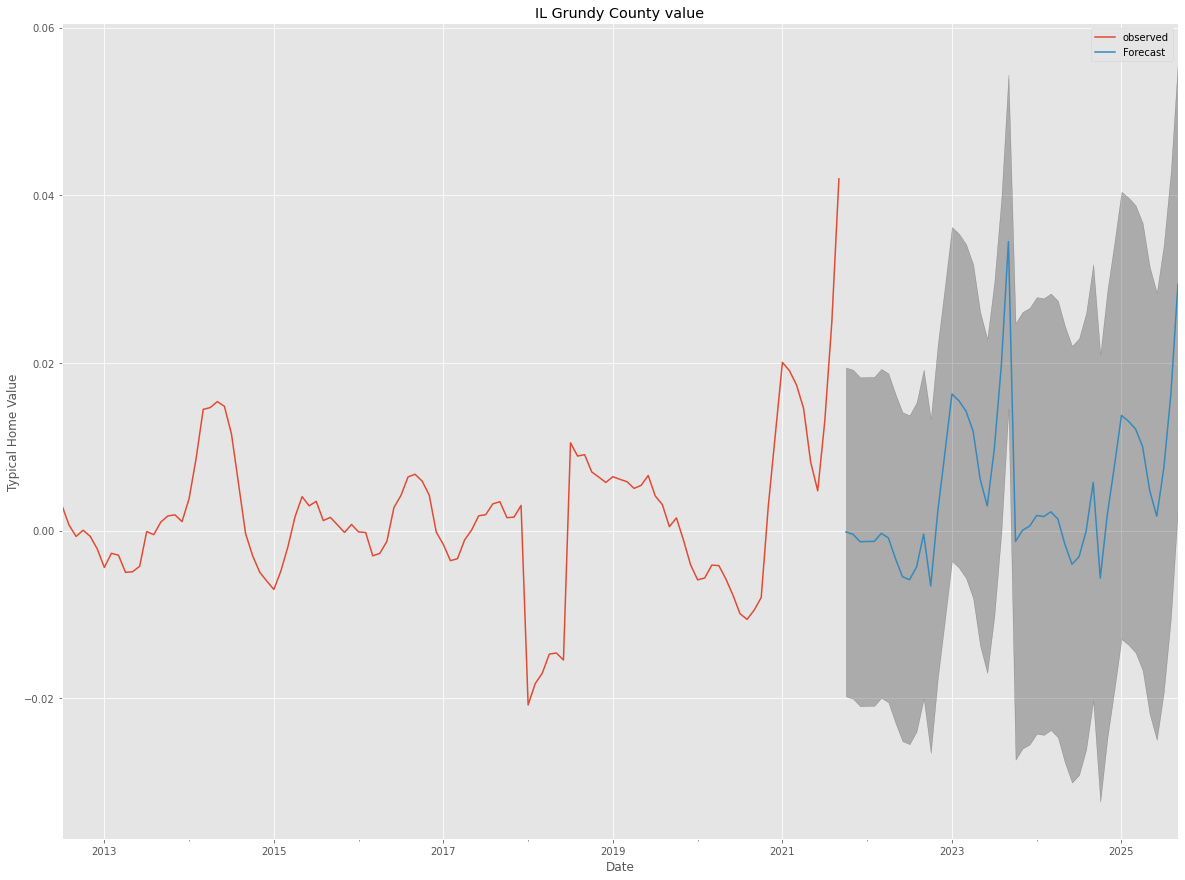

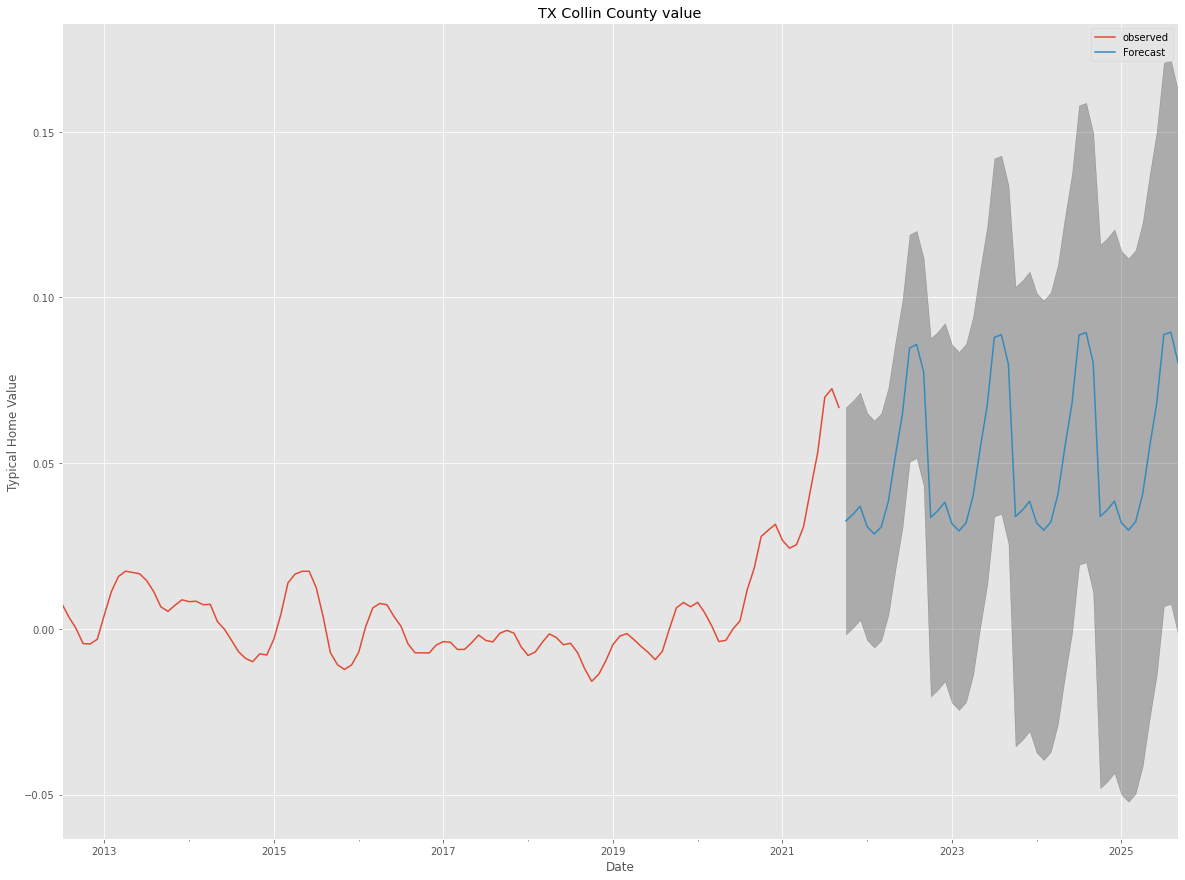

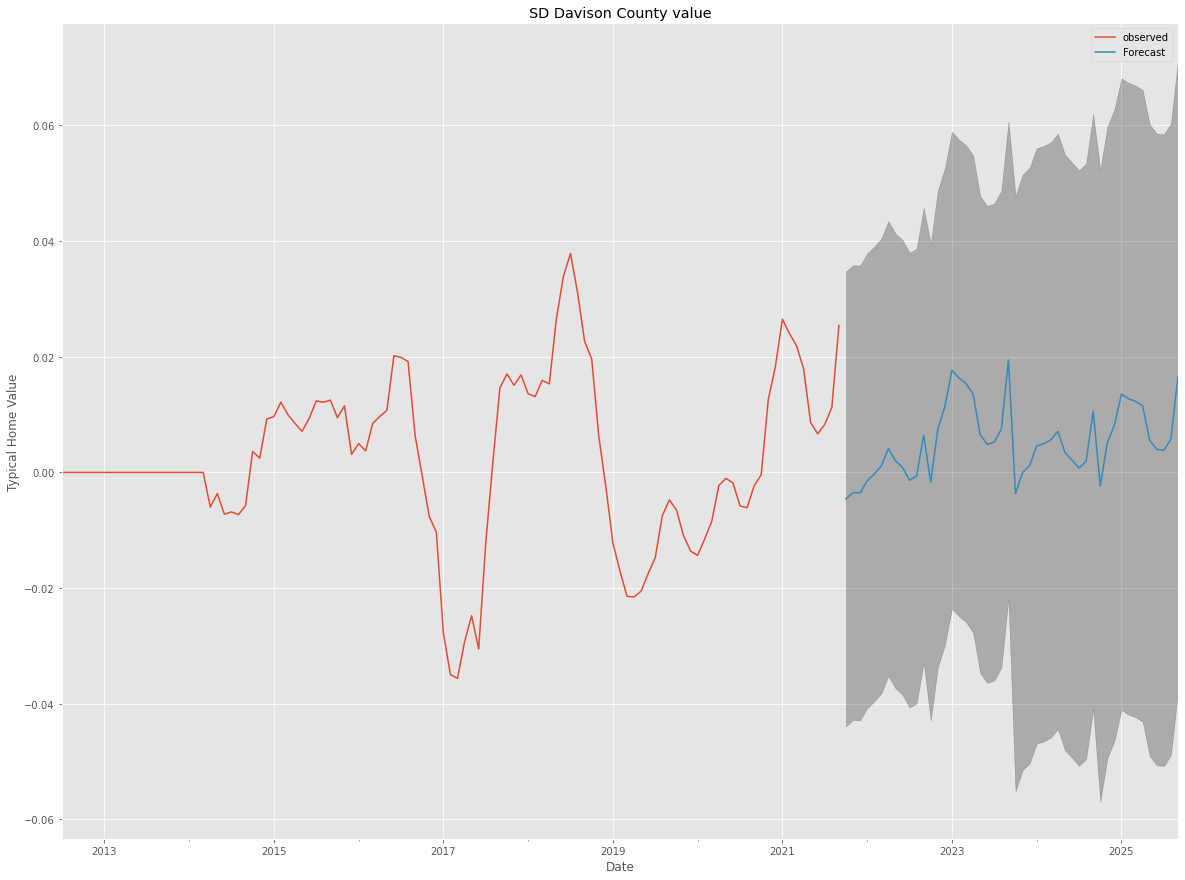

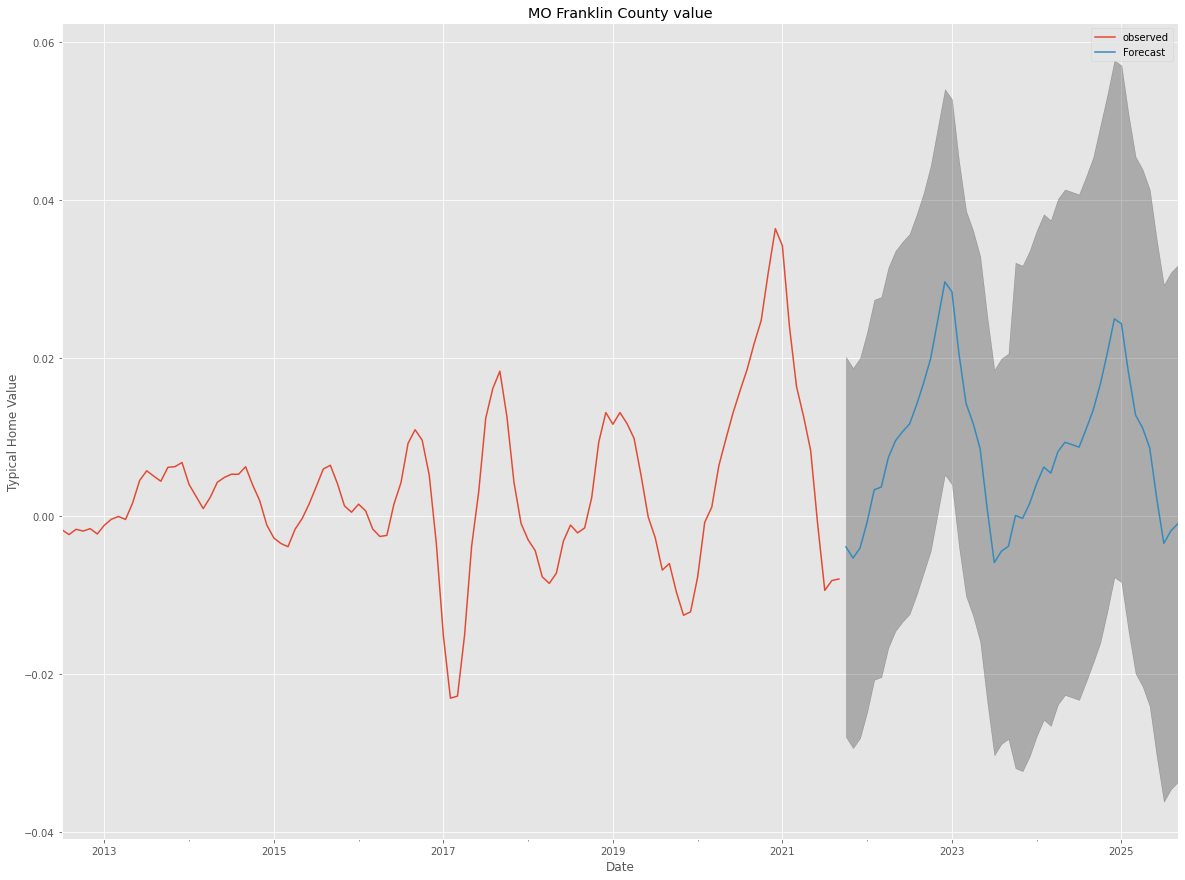

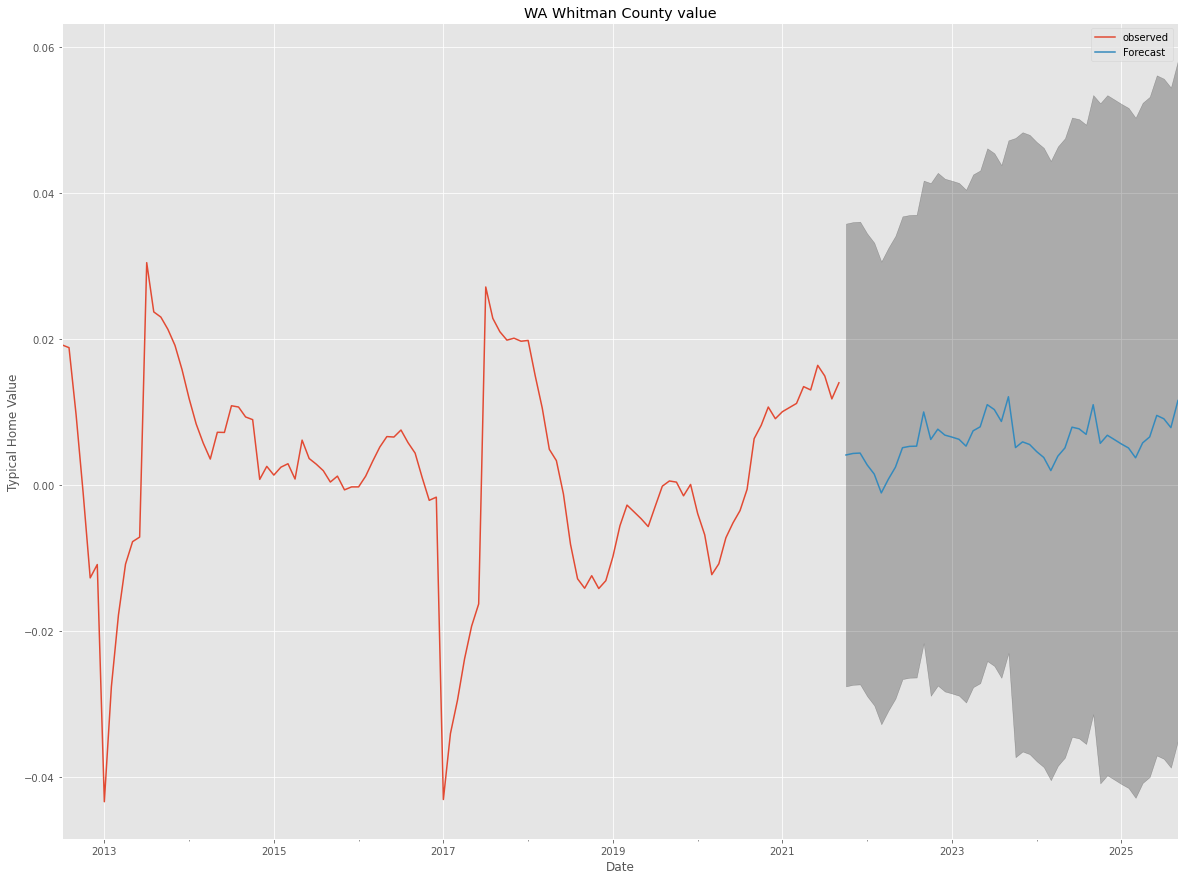

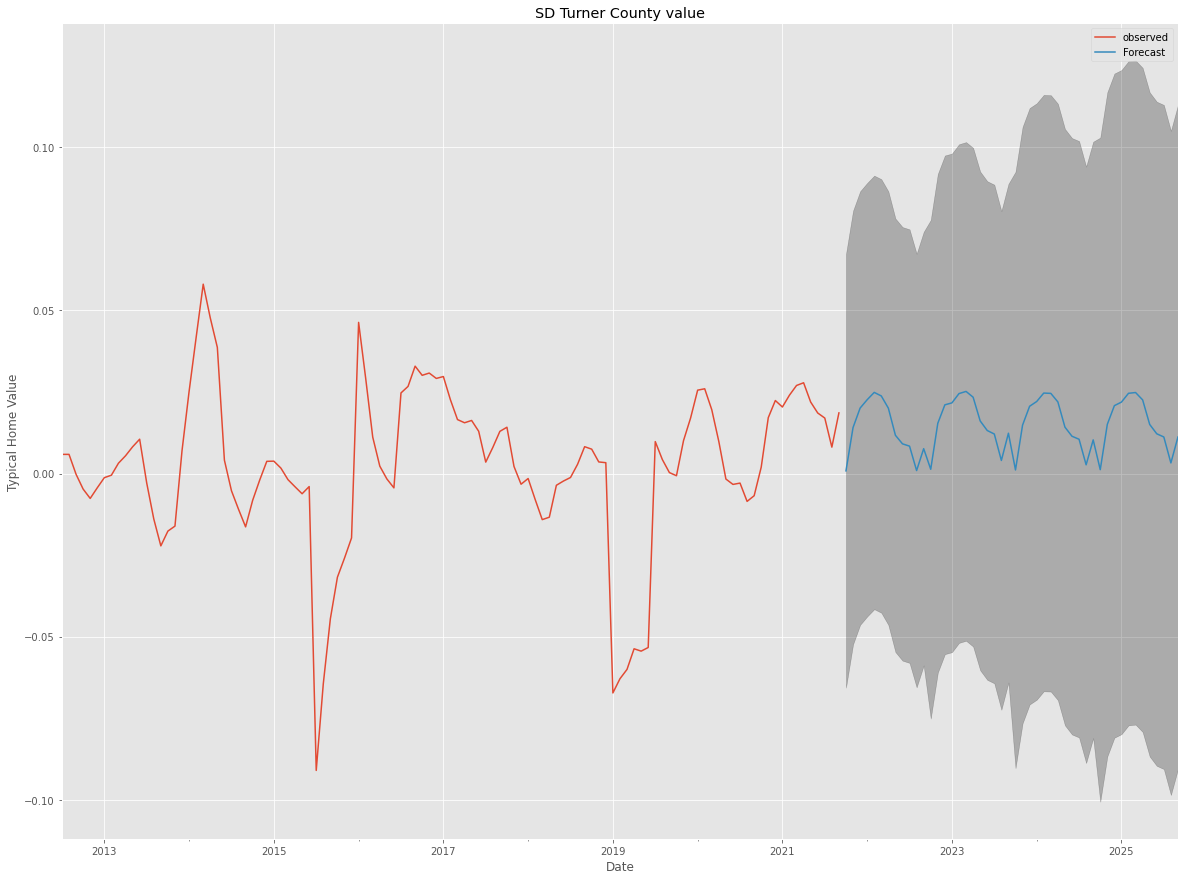

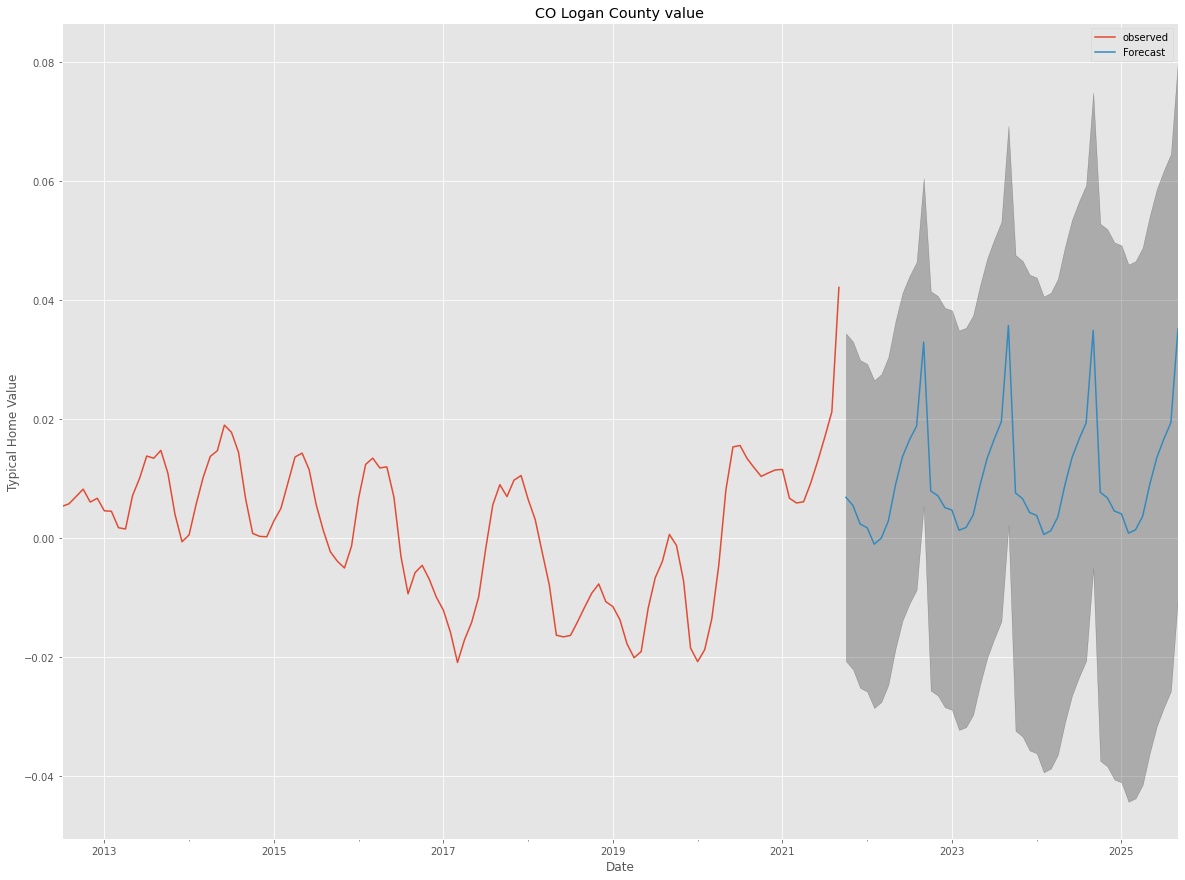

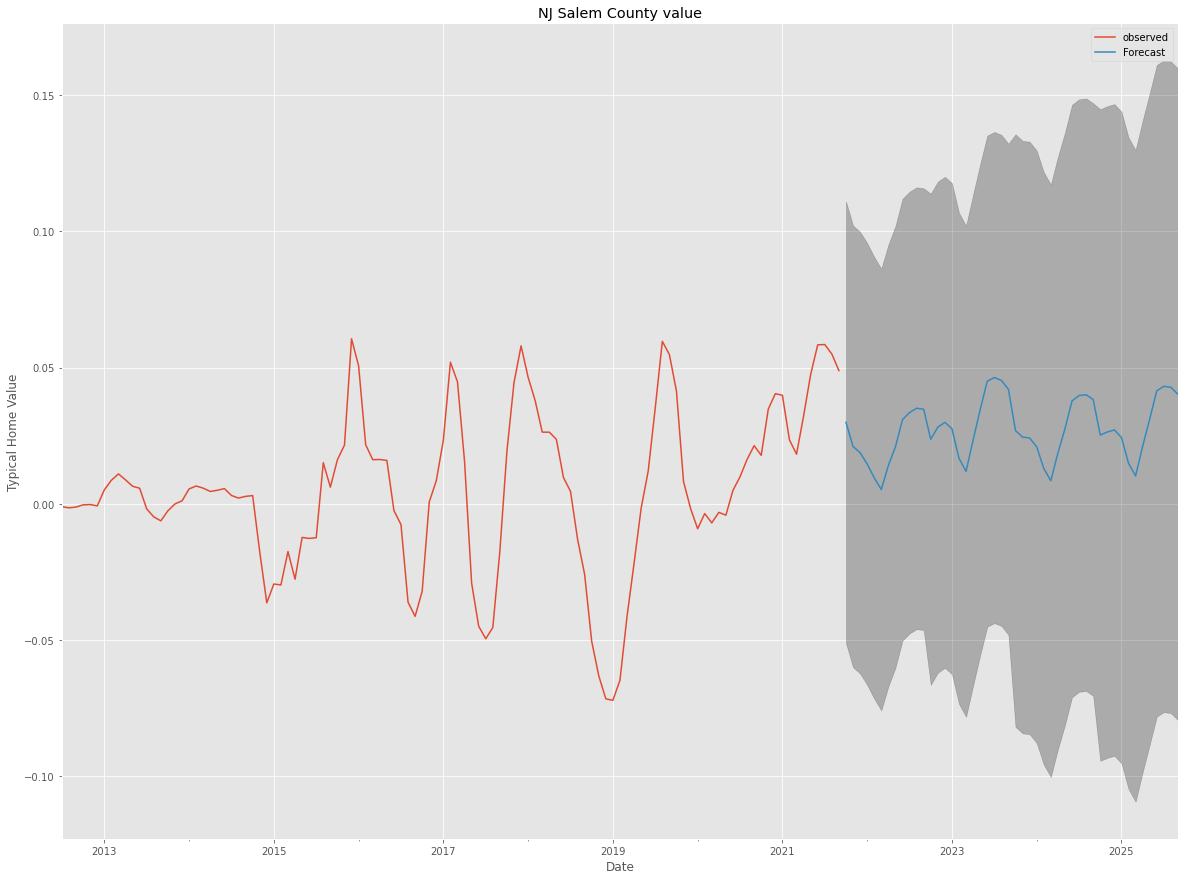

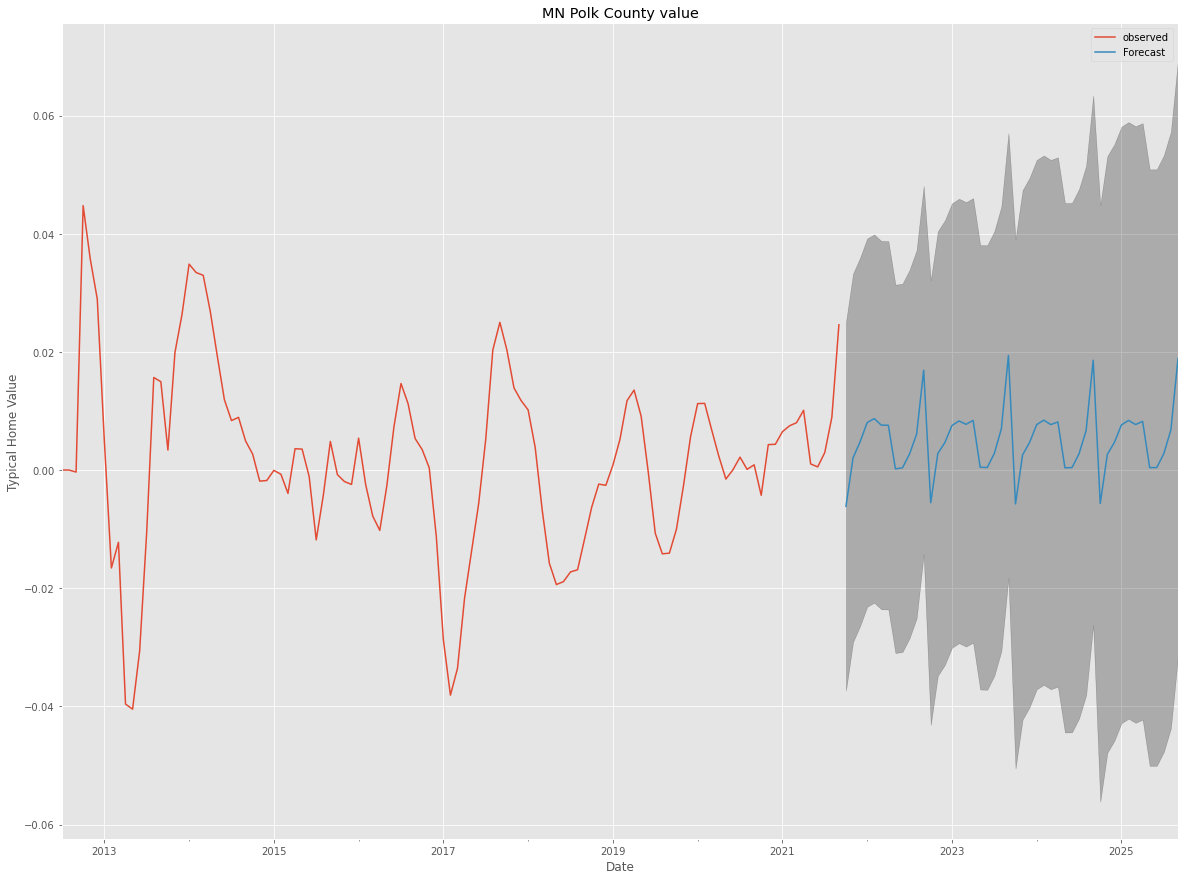

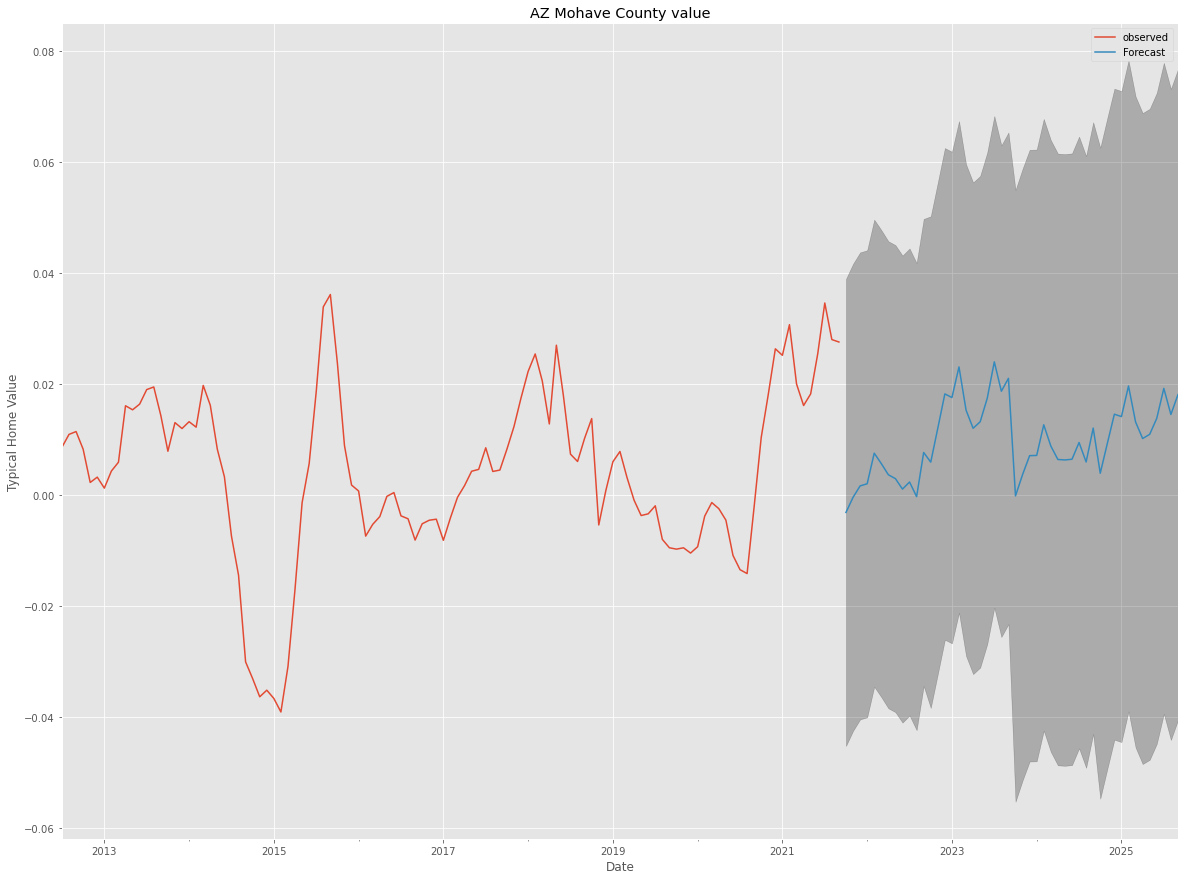

In [23]:
for i in range(len(models)):
    generate_forecast(models[i], data_diff.columns[i], data_diff)

## Next Steps

The next steps would be to better optimize the individual model. With better optimized models one would be able to generate more accurate predictions. After applying those methods to the 2900 other counties, group census data by county to see if there are correlations. Build a map to display results and a filtering program to help the user review what they want to see. Have the program pull data from Zillow and any updates to the census information in real time. 